<a href="https://colab.research.google.com/github/yi-juho/-K_MHAS-_HuggingFace_dataset_MultiBERT_shared/blob/main/%5BK_MHAS%5D_HuggingFace_dataset_MultiBERT_shared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-MHaS (Korean Multi-label Hate Speech Dataset)

## Dataset loading

Loading the K-MHaS dataset from [HuggingFace](https://huggingface.co/datasets/jeanlee/kmhas_korean_hate_speech) and checking meta information (published @COLING2022)


In [3]:
!pip uninstall datasets fsspec -y
!pip install datasets==3.2.0 fsspec[http]==2024.9.0


Found existing installation: datasets 3.2.0
Uninstalling datasets-3.2.0:
  Successfully uninstalled datasets-3.2.0
Found existing installation: fsspec 2024.9.0
Uninstalling fsspec-2024.9.0:
  Successfully uninstalled fsspec-2024.9.0
  Using cached datasets-3.2.0-py3-none-any.whl.metadata (20 kB)
  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
Using cached datasets-3.2.0-py3-none-any.whl (480 kB)
Using cached fsspec-2024.9.0-py3-none-any.whl (179 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which 

In [4]:
!pip install transformers
!pip install datasets

In [5]:
from datasets import load_dataset

dataset = load_dataset("jeanlee/kmhas_korean_hate_speech")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 78977
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 8776
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 21939
    })
})

In [7]:
dataset = load_dataset("jeanlee/kmhas_korean_hate_speech", split="test")

In [8]:
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 21939
})

In [11]:
dataset.features

{'text': Value(dtype='string', id=None),
 'label': Sequence(feature=ClassLabel(names=['origin', 'physical', 'politics', 'profanity', 'age', 'gender', 'race', 'religion', 'not_hate_speech'], id=None), length=-1, id=None)}

In [9]:
# meta information

print(dataset.info.description)
print(dataset.info.homepage)

The K-MHaS (Korean Multi-label Hate Speech) dataset contains 109k utterances from Korean online news comments labeled with 8 fine-grained hate speech classes or Not Hate Speech class.
The fine-grained hate speech classes are politics, origin, physical, age, gender, religion, race, and profanity and these categories are selected in order to reflect the social and historical context.

https://github.com/adlnlp/K-MHaS


In [10]:
print(dataset.info.citation)

@inproceedings{lee-etal-2022-k,
    title = "K-{MH}a{S}: A Multi-label Hate Speech Detection Dataset in {K}orean Online News Comment",
    author = "Lee, Jean  and
      Lim, Taejun  and
      Lee, Heejun  and
      Jo, Bogeun  and
      Kim, Yangsok  and
      Yoon, Heegeun  and
      Han, Soyeon Caren",
    booktitle = "Proceedings of the 29th International Conference on Computational Linguistics",
    month = oct,
    year = "2022",
    address = "Gyeongju, Republic of Korea",
    publisher = "International Committee on Computational Linguistics",
    url = "https://aclanthology.org/2022.coling-1.311",
    pages = "3530--3538",
    abstract = "Online hate speech detection has become an important issue due to the growth of online content, but resources in languages other than English are extremely limited. We introduce K-MHaS, a new multi-label dataset for hate speech detection that effectively handles Korean language patterns. The dataset consists of 109k utterances from news commen

## Data preparation

- Prepare data from train, validation, and test dataset
- Multi-label is converted to multi-label one hot encodding

      class_label:
        names:
          0: origin
          1: physical
          2: politics
          3: profanity
          4: age
          5: gender
          6: race
          7: religion
          8: not_hate_speech

In [12]:
!pip install transformers
!pip install datasets

In [13]:
from datasets import load_dataset

dataset = load_dataset("jeanlee/kmhas_korean_hate_speech")

In [14]:
!pip install keras_preprocessing


In [15]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, hamming_loss
from sklearn.preprocessing import MultiLabelBinarizer

import pandas as pd
import numpy as np
import random
import time
import datetime
from tqdm import tqdm

import csv
import os



In [16]:
# load train, validation, and test dataset from HuggingFace

train = load_dataset("jeanlee/kmhas_korean_hate_speech", split="train")
validation = load_dataset("jeanlee/kmhas_korean_hate_speech", split="validation")
test = load_dataset("jeanlee/kmhas_korean_hate_speech", split="test")

In [17]:
# adding masking (able to remove this step depending on the model)

train_sentences = list(map(lambda x: '[CLS] ' + str(x) + ' [SEP]', train['text']))
validation_sentences = list(map(lambda x: '[CLS] ' + str(x) + ' [SEP]', validation['text']))
test_sentences = list(map(lambda x: '[CLS] ' + str(x) + ' [SEP]', test['text']))

In [18]:
# convert multi-label to multi-label binary (one hot encoding)
# [8] -> [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]

from sklearn.preprocessing import MultiLabelBinarizer

enc = MultiLabelBinarizer()

def multi_label(example):
    enc_label = enc.fit_transform(example['label'])
    float_arr = np.vstack(enc_label[:]).astype(float)
    update_label = float_arr.tolist()
    return update_label

train_labels = multi_label(train)
validation_labels = multi_label(validation)
test_labels = multi_label(test)

In [19]:
test_sentences[:5]

['[CLS] 그만큼 길예르모가 잘했다고 보면되겠지 기대되네 셰이프 오브 워터 [SEP]',
 '[CLS] "1. 8넘의 문재앙" [SEP]',
 '[CLS] "문재인 정권의 내로남불은 타의 추종을 불허하네. 자한당 욕할거리도 없음." [SEP]',
 '[CLS] "짱개들 지나간 곳은 폐허된다 ㅋㅋ" [SEP]',
 '[CLS] 곱창은 자갈치~~~~~ [SEP]']

In [20]:
test_labels[:5]

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]

## Prep for Pytorch

In [21]:
# Tokenizing : bert-base-multilingual-cased

tokenizer = BertTokenizer.from_pretrained('klue/bert-base', do_lower_case=False)

In [22]:
MAX_LEN = 128

def data_to_tensor (sentences, labels):
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

  attention_masks = []

  for seq in input_ids:
      seq_mask = [float(i > 0) for i in seq]
      attention_masks.append(seq_mask)

  tensor_inputs = torch.tensor(input_ids)
  tensor_labels = torch.tensor(labels)
  tensor_masks = torch.tensor(attention_masks)

  return tensor_inputs, tensor_labels, tensor_masks


In [23]:
train_inputs, train_labels, train_masks = data_to_tensor(train_sentences, train_labels)
validation_inputs, validation_labels, validation_masks = data_to_tensor(validation_sentences, validation_labels)
test_inputs, test_labels, test_masks = data_to_tensor(test_sentences, test_labels)

In [24]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [25]:
print('testset size:', len(test_labels))
print('trainset size:', len(train_labels))
print('validset size:', len(validation_labels))

testset size: 21939
trainset size: 78977
validset size: 8776


## 데이터셋 통계 코드

In [32]:
dataset_info_list = []

# ✅ 각 데이터셋 (train, validation, test) 별로 분석
for split in ["train", "validation", "test"]:
    data = dataset[split]

    # ✅ 데이터 개수
    num_samples = len(data)

    # ✅ 정답 레이블 개수 (중복 제거한 고유한 클래스 수)
    unique_labels = set(label for example in data["label"] for label in example)
    num_labels = len(unique_labels)

    # ✅ 문장 토큰화 후 길이 계산
    token_lens = [len(tokenizer.tokenize(sentence)) for sentence in data["text"]]

    # ✅ 토큰 길이 통계 정보
    avg_token_length = np.mean(token_lens)  # 평균 길이
    max_token_length = np.max(token_lens)  # 최대 길이
    min_token_length = np.min(token_lens)  # 최소 길이
    token_length_percentiles = np.percentile(token_lens, [90, 95, 99])  # 90%, 95%, 99% 백분위수

    # ✅ 결과 저장
    dataset_info_list.append({
        "데이터셋": split,
        "총 데이터 개수": num_samples,
        "정답 레이블 개수": num_labels,
        "평균 토큰 길이": avg_token_length,
        "최소 토큰 길이": min_token_length,
        "최대 토큰 길이": max_token_length,
        "90% 백분위수 토큰 길이": token_length_percentiles[0],
        "95% 백분위수 토큰 길이": token_length_percentiles[1],
        "99% 백분위수 토큰 길이": token_length_percentiles[2],
    })

In [33]:
for info in dataset_info_list:
    print(f"📌 데이터셋: {info['데이터셋']}")
    print(f"  - 총 데이터 개수: {info['총 데이터 개수']}")
    print(f"  - 정답 레이블 개수: {info['정답 레이블 개수']}")
    print(f"  - 평균 토큰 길이: {info['평균 토큰 길이']:.2f}")
    print(f"  - 최소 토큰 길이: {info['최소 토큰 길이']}")
    print(f"  - 최대 토큰 길이: {info['최대 토큰 길이']}")
    print(f"  - 90% 백분위수 토큰 길이: {info['90% 백분위수 토큰 길이']}")
    print(f"  - 95% 백분위수 토큰 길이: {info['95% 백분위수 토큰 길이']}")
    print(f"  - 99% 백분위수 토큰 길이: {info['99% 백분위수 토큰 길이']}\n")

📌 데이터셋: train
  - 총 데이터 개수: 78977
  - 정답 레이블 개수: 9
  - 평균 토큰 길이: 20.08
  - 최소 토큰 길이: 1
  - 최대 토큰 길이: 249
  - 90% 백분위수 토큰 길이: 31.0
  - 95% 백분위수 토큰 길이: 45.0
  - 99% 백분위수 토큰 길이: 102.0

📌 데이터셋: validation
  - 총 데이터 개수: 8776
  - 정답 레이블 개수: 9
  - 평균 토큰 길이: 19.79
  - 최소 토큰 길이: 1
  - 최대 토큰 길이: 203
  - 90% 백분위수 토큰 길이: 30.0
  - 95% 백분위수 토큰 길이: 44.0
  - 99% 백분위수 토큰 길이: 94.25

📌 데이터셋: test
  - 총 데이터 개수: 21939
  - 정답 레이블 개수: 9
  - 평균 토큰 길이: 20.06
  - 최소 토큰 길이: 1
  - 최대 토큰 길이: 187
  - 90% 백분위수 토큰 길이: 31.0
  - 95% 백분위수 토큰 길이: 45.0
  - 99% 백분위수 토큰 길이: 103.0



In [34]:
all_texts = dataset["train"]["text"] + dataset["validation"]["text"] + dataset["test"]["text"]
all_labels = dataset["train"]["label"] + dataset["validation"]["label"] + dataset["test"]["label"]

# ✅ 전체 데이터 개수
num_total_samples = len(all_texts)

# ✅ 정답 레이블 개수 (중복 제거한 고유한 클래스 수)
unique_labels = set(label for example in all_labels for label in example)
num_total_labels = len(unique_labels)

# ✅ 문장 토큰화 후 길이 계산
all_token_lens = [len(tokenizer.tokenize(sentence)) for sentence in all_texts]

# ✅ 토큰 길이 통계 정보
avg_token_length_total = np.mean(all_token_lens)  # 평균 길이
max_token_length_total = np.max(all_token_lens)  # 최대 길이
min_token_length_total = np.min(all_token_lens)  # 최소 길이
token_length_percentiles_total = np.percentile(all_token_lens, [90, 95, 99])  # 90%, 95%, 99% 백분위수

# ✅ 전체 데이터셋 통계 출력
print("📌 전체 데이터셋 통계")
print(f"  - 총 데이터 개수: {num_total_samples}")
print(f"  - 정답 레이블 개수: {num_total_labels}")
print(f"  - 평균 토큰 길이: {avg_token_length_total:.2f}")
print(f"  - 최소 토큰 길이: {min_token_length_total}")
print(f"  - 최대 토큰 길이: {max_token_length_total}")
print(f"  - 90% 백분위수 토큰 길이: {token_length_percentiles_total[0]}")
print(f"  - 95% 백분위수 토큰 길이: {token_length_percentiles_total[1]}")
print(f"  - 99% 백분위수 토큰 길이: {token_length_percentiles_total[2]}")

📌 전체 데이터셋 통계
  - 총 데이터 개수: 109692
  - 정답 레이블 개수: 9
  - 평균 토큰 길이: 20.05
  - 최소 토큰 길이: 1
  - 최대 토큰 길이: 249
  - 90% 백분위수 토큰 길이: 31.0
  - 95% 백분위수 토큰 길이: 45.0
  - 99% 백분위수 토큰 길이: 102.0


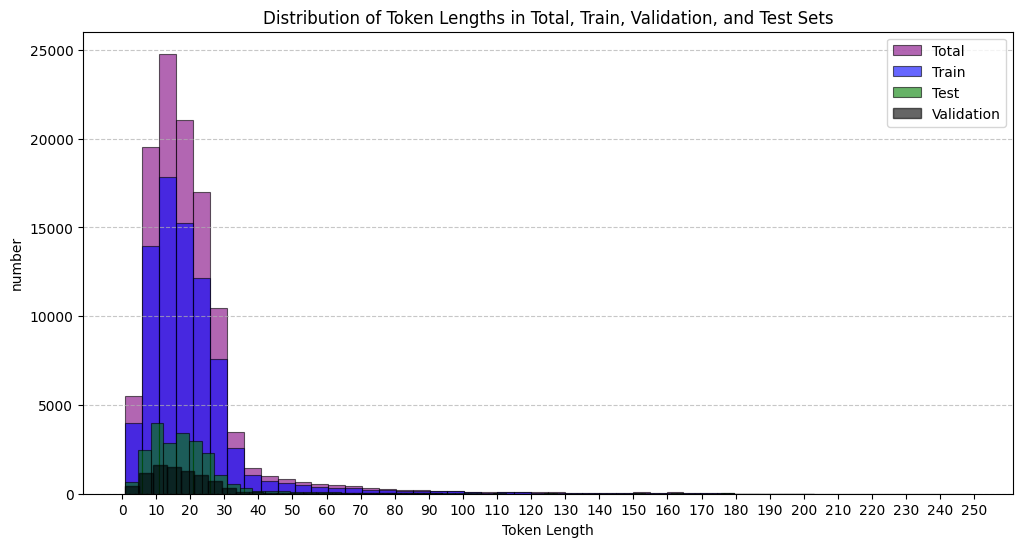

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ 각 데이터셋의 토큰 길이 계산
train_token_lens = [len(tokenizer.tokenize(sentence)) for sentence in dataset["train"]["text"]]
validation_token_lens = [len(tokenizer.tokenize(sentence)) for sentence in dataset["validation"]["text"]]
test_token_lens = [len(tokenizer.tokenize(sentence)) for sentence in dataset["test"]["text"]]
all_token_lens = train_token_lens + validation_token_lens + test_token_lens

# ✅ 전체, train, validation, test 데이터셋의 토큰 길이 분포 시각화
plt.figure(figsize=(12, 6))

# ✅ 전체 데이터셋 토큰 길이 분포
plt.hist(all_token_lens, bins=50, color='purple', alpha=0.6, label="Total", edgecolor='black', linewidth=0.8)

# ✅ Train 데이터셋 토큰 길이 분포
plt.hist(train_token_lens, bins=50, color='blue', alpha=0.6, label="Train", edgecolor='black', linewidth=0.8)

# ✅ Test 데이터셋 토큰 길이 분포
plt.hist(test_token_lens, bins=50, color='green', alpha=0.6, label="Test", edgecolor='black', linewidth=0.8)

# ✅ Validation 데이터셋 토큰 길이 분포
plt.hist(validation_token_lens, bins=50, color='black', alpha=0.6, label="Validation", edgecolor='black', linewidth=1)

# ✅ X축 세부 라벨링
plt.xticks(np.arange(0, max(all_token_lens)+10, step=10))  # 10단위로 라벨링

plt.xlabel("Token Length")
plt.ylabel("number")
plt.title("Distribution of Token Lengths in Total, Train, Validation, and Test Sets")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Multi-BERT model

### GPU setting

In [26]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [27]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Model setting

In [ ]:
#import numpy as np

def top_1200_input(attention_scores):
    """
    1200개의 attention_scores를 120개의 리스트로 나누어 각 리스트를 top 함수에 전달
    """

    # result를 저장할 리스트
    result_arrays = []

    # 120개의 10개짜리 리스트를 top()에 전달
    for i in range(12):
      for k in range(10):
          result = top(*attention_scores[k])  # 리스트의 10개 요소를 개별 인자로 전달
          result_arrays.append(result)  # 결과 저장

    return result_arrays



def float_to_fixed_point(value, int_bits=7, frac_bits=13):
    """
    실수를 32비트 Fixed-Point 바이너리로 변환하는 함수.
    - 31~20 비트: 항상 0 (상위 12비트)
    - 19~13 비트: 정수부 (7비트, Signed, 2의 보수)
    - 12~0 비트: 소수부 (13비트, 항상 양수)

    정수부는 내림하여 변환하고, 소수부를 정확한 2진 변환 방식으로 변환.
    """
    max_frac_value = 2**frac_bits  # 13비트 소수부 정밀도 (8192)

    # ✅ 1. 정수부와 소수부 정확하게 분리 (내림 적용)
    int_part = np.floor(value).astype(int)
    frac_part = abs(value - int_part)  # 소수부 절댓값 유지

    # ✅ 2. 정수부(7비트) 변환 (2의 보수 변환)
    if int_part < 0:
        int_binary = format((1 << int_bits) + int_part, f'0{int_bits}b')  # 7비트 2의 보수 변환
    else:
        int_binary = format(int_part, f'0{int_bits}b')  # 7비트 양수 표현

    # ✅ 3. 앞 12비트는 항상 0으로 유지
    int_binary = "0" * 12 + int_binary

    # ✅ 4. 소수부 변환 (부동소수점 오차 최소화)
    frac_binary = ""
    frac_value = frac_part  # 소수부 값 유지
    for _ in range(frac_bits):  # 13비트 반복
        frac_value *= 2
        if frac_value >= 1:
            frac_binary += "1"
            frac_value -= 1
        else:
            frac_binary += "0"

    # ✅ 5. 최종 32비트 바이너리 생성
    fixed_binary = int_binary + frac_binary
    lower_20_bits = int(fixed_binary, 2) & 0xFFFFF
    return lower_20_bits

def binary_to_decimal(binary_str):
    # 16비트 중 앞 3비트는 정수부, 뒤 13비트는 소수부
    int_part = int(binary_str[:3], 2)  # 정수부
    frac_part = int(binary_str[3:], 2) / (2 ** 13)  # 소수부를 2^13으로 나눔
    return int_part + frac_part  # 정수부와 소수부 합산

def hex_to_binary(hex_str):
    """
    16비트 헥스 값을 16비트 바이너리 문자열로 변환하는 함수

    :param hex_str: 변환할 16비트 헥스 값 (예: "1A2F" 또는 0x1A2F)
    :return: 16비트 바이너리 문자열 (예: "0001101000101111")
    """
    # hex_str가 정수형일 경우 문자열로 변환
    if isinstance(hex_str, int):
        hex_str = format(hex_str, 'X')  # 16진수 대문자로 변환

    # 16진수를 10진수로 변환 후, 16비트 이진수로 변환
    binary_str = bin(int(hex_str, 16))[2:].zfill(16)
    return binary_str

# 테스트 예제


# 테스트 예제


def top(data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10) : #20bit data

    data_11 = float_to_fixed_point(data_1)
    data_22 = float_to_fixed_point(data_2)
    data_33 = float_to_fixed_point(data_3)
    data_44 = float_to_fixed_point(data_4)
    data_55 = float_to_fixed_point(data_5)
    data_66 = float_to_fixed_point(data_6)
    data_77 = float_to_fixed_point(data_7)
    data_88 = float_to_fixed_point(data_8)
    data_99 = float_to_fixed_point(data_9)
    data_1010 = float_to_fixed_point(data_10)

    data_list = [data_11, data_22, data_33, data_44, data_55, data_66, data_77, data_88, data_99, data_1010]
    #data_list = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10]
    int_list = [0] * 10 #exp_int input
    exp_int_output = [0]*10 #exp_int output
    fraction_list=[0]*10 #cordic_exu input
    exp_fraction_output = [0]*10 #cordic_exu output
    exp_whole=[0]*10 #cordic_exu +cordic_int
    exp_trunc=[0]*10
    exp_accum_input=[0]*10 # accumulator input  (exponential)
    exp_accum_output=[0]*1
    x_divider = [0] * 10 #cordic diu input
    y_dividend = [0] * 10 #cordic diu input
    data_out = [0] * 10
    binary_values = [0] * 10
    int_values = [0.0] * 10
    for i in range(10):  # int part
        int_list[i] = data_list[i] >> 13
    exp_int_output[0], exp_int_output[1], exp_int_output[2], exp_int_output[3], exp_int_output[4], exp_int_output[5], exp_int_output[6], exp_int_output[7], exp_int_output[8], exp_int_output[9]=exp_int(int_list[0], int_list[1], int_list[2], int_list[3], int_list[4], int_list[5], int_list[6], int_list[7], int_list[8], int_list[9])

    for i in range(10):  # fraction part
        fraction_list[i] = (data_list[i] & 0x1FFF) << 1  # 하위 13비트를 가져오고, 뒤에 0을 추가
    exp_fraction_output[0], exp_fraction_output[1], exp_fraction_output[2], exp_fraction_output[3], exp_fraction_output[4], exp_fraction_output[5], exp_fraction_output[6], exp_fraction_output[7], exp_fraction_output[8], exp_fraction_output[9] = cordic_exu(fraction_list[0], fraction_list[1], fraction_list[2], fraction_list[3], fraction_list[4], fraction_list[5], fraction_list[6], fraction_list[7], fraction_list[8], fraction_list[9])


    for i in range(10):
       exp_whole[i] = exp_int_output[i] * exp_fraction_output[i]

    for i in range(10):
       exp_trunc[i] = (exp_whole[i] >> 14) & 0xFFFFF  # 33~14 비트를 추출 (20비트)
    for i in range(10):
       exp_accum_input[i] = (exp_trunc[i] >> 4) & 0xFFFF

    exp_accum_output[0] = cordic_accumulator(exp_accum_input[0],exp_accum_input[1],exp_accum_input[2],exp_accum_input[3],exp_accum_input[4],exp_accum_input[5],exp_accum_input[6],exp_accum_input[7],exp_accum_input[8],exp_accum_input[9])



    # denominator_sf[i]에서 18~4 비트 추출 후, 앞에 0을 붙여서 x_divider에 할당
    x_divider[0] = (exp_accum_output[0] >> 4) & 0x7FFF  # 18~4 비트를 추출 (15비트)

    for i in range(10):
    # numerator_sf[i]에서 15~4 비트 추출 후, 앞에 4개의 0을 붙여서 y_dividend에 할당
        y_dividend[i] = (exp_accum_input[i] >> 4)  # 15~4 비트를 추출 (12비트)

    data_out[0],data_out[1],data_out[2],data_out[3],data_out[4],data_out[5],data_out[6],data_out[7],data_out[8],data_out[9], = cordic_diu (x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],y_dividend[0],y_dividend[1],y_dividend[2],y_dividend[3],y_dividend[4],y_dividend[5],y_dividend[6],y_dividend[7],y_dividend[8],y_dividend[9])

    for i in range(10):
        binary_values[i] = hex_to_binary(data_out[i])
       # print(binary_values[i])

    for i in range(10):
        int_values[i] = binary_to_decimal(binary_values[i])

    return int_values[0],int_values[1],int_values[2],int_values[3],int_values[4],int_values[5],int_values[6],int_values[7],int_values[8],int_values[9]

def exp_int(data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10):
    data_list = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10]
    data_to_int = [0]*10
    int_output=[0]*10
    for i in range(10):
        # 이진수로 변환하여 signed_binary_to_int 함수에 전달
        binary_str = bin(data_list[i])[2:].zfill(7)  # 20비트 이진수 문자열로 변환
        data_to_int[i] = signed_binary_to_int(binary_str)

    i_max = max(data_to_int)
    offset=signed_binary_to_int(bin(0b0001011-i_max)[2:].zfill(7)) #offset

    for i in range(10):
        int_reg=data_to_int[i]+offset
        #print(int_reg)
        if int_reg==0 :
            int_output[i]=0b0000_0000_0000_0001_00
        elif int_reg==1 :
            int_output[i]=0b0000_0000_0000_0010_11
        elif int_reg==2 :
            int_output[i]=0b0000_0000_0000_0111_10
        elif int_reg==3 :
            int_output[i]=0b0000_0000_0001_0100_00
        elif int_reg==4 :
            int_output[i]=0b0000_0000_0011_0110_10
        elif int_reg==5 :
            int_output[i]=0b0000_0000_1001_0100_10
        elif int_reg==6 :
            int_output[i]=0b0000_0001_1001_0011_10
        elif int_reg==7 :
            int_output[i]=0b0000_0100_0100_1000_11
        elif int_reg==8 :
            int_output[i]=0b0000_1011_1010_0101_00
        elif int_reg==9 :
            int_output[i]=0b0001_1111_1010_0111_00
        elif int_reg==10 :
            int_output[i]=0b0101_0110_0000_1010_10
        elif int_reg==11 :
            int_output[i]=0b1110_1001_1110_0010_01
        else :
            int_output[i]=0

    return  int_output[0], int_output[1], int_output[2], int_output[3], int_output[4], int_output[5], int_output[6], int_output[7], int_output[8], int_output[9]


def cordic_exu (data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10):
    data_list = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10]
    exp_fraction =[0]*10

    for i in range(10):
        exp_fraction[i]=  cordic_exu_pipe(data_list[i])
        #print(bin(data_list[i]))

    return exp_fraction[0], exp_fraction[1], exp_fraction[2], exp_fraction[3], exp_fraction[4], exp_fraction[5], exp_fraction[6], exp_fraction[7], exp_fraction[8], exp_fraction[9]


def cordic_exu_pipe(z_in):
    x_1, y_1, z_1=exp_unit(0b1001101010001111, 0, z_in, 0b0010001100100111,1)
    x_2, y_2, z_2=exp_unit(x_1, y_1, z_1,0b0001000001011000,2)
    x_3, y_3, z_3 = exp_unit(x_2, y_2, z_2, 0b0000100000001010, 3)
    x_4, y_4, z_4 = exp_unit(x_3, y_3, z_3, 0b0000010000000001, 4)
    x_5, y_5, z_5 = exp_unit(x_4, y_4, z_4, 0b0000001000000000, 5)
    x_6, y_6, z_6 = exp_unit(x_5, y_5, z_5, 0b0000000100000000, 6)
    x_7, y_7, z_7 = exp_unit(x_6, y_6, z_6, 0b0000000010000000, 7)
    x_8, y_8, z_8 = exp_unit(x_7, y_7, z_7, 0b0000000001000000, 8)
    x_9, y_9, z_9 = exp_unit(x_8, y_8, z_8, 0b0000000000100000, 9)
    x_10, y_10, z_10 = exp_unit(x_9, y_9, z_9, 0b0000000000010000, 10)
    x_11, y_11, z_11 = exp_unit(x_10, y_10, z_10, 0b0000000000001000, 11)
    x_12, y_12, z_12 = exp_unit(x_11, y_11, z_11, 0b0000000000000100, 12)
    x_13, y_13, z_13 = exp_unit(x_12, y_12, z_12, 0b0000000000000010, 13)
    x_14, y_14, z_14 = exp_unit(x_13, y_13, z_13, 0b0000000000000010, 14)


    exp_frac_reg=x_14+y_14
    exp_frac = (exp_frac_reg >> 1) & 0xFFFF
    #print(bin(exp_frac))
    return exp_frac



def exp_unit(x_in, y_in, z_in, lut_val, pipe_num):
    # 16-bit 입력 값
    x_cal = 0
    y_cal = 0
    z_cal = 0

    if z_in & (1 << 15):  # z_in[15] = MSB를 확인 (시계방향: z_in[15]가 1)
        # 시계방향 (downward)
        x_cal = x_in - (y_in >> pipe_num)
        y_cal = y_in - (x_in >> pipe_num)
        z_cal = z_in + lut_val
    else:
        # 반시계방향 (upward)
        x_cal = x_in + (y_in >> pipe_num)
        y_cal = y_in + (x_in >> pipe_num)
        z_cal = z_in - lut_val

    if z_cal < 0:
        # 음수일 경우 2의 보수를 구하고 16비트로 마스킹
        z_cal = (z_cal + (1 << 16)) & 0xFFFF
    else:
        z_cal = z_cal & 0xFFFF
    # 결과값 반환 (튜플로 출력)

    return x_cal, y_cal, z_cal


def signed_binary_to_int(binary_str):
    # 이진수의 길이
    n = len(binary_str)

    # 부호 비트 확인 (최상위 비트가 1이면 음수)
    if binary_str[0] == '1':
        # 2의 보수 방법으로 음수 변환
        return int(binary_str, 2) - (1 << n)
    else:
        # 양수는 그냥 변환
        return int(binary_str, 2)

def accumulator(sequence_in, exponential, state):
    """
    입력값을 받아 sum1, sum2, denominator_sf 값을 업데이트하고 출력.
    """

    # accumulator_SEL 토글
    state["accumulator_SEL"] = (state["accumulator_SEL"] + sequence_in) & 1

    # valid 시프트 레지스터 갱신
    state["valid"] = [sequence_in] + state["valid"][:-1]

    if state["accumulator_SEL"]:  # accumulator 1 사용
        state["sum1"] += exponential
        if sequence_in:
            state["sum2"] = exponential  # sum2 리셋
        if state["valid"][9]:
            state["denominator_sf"] = state["sum1"]  # denominator_sf 업데이트
    else:  # accumulator 2 사용
        state["sum2"] += exponential
        if sequence_in:
            state["sum1"] = exponential  # sum1 리셋
        if state["valid"][9]:
            state["denominator_sf"] = state["sum2"]  # denominator_sf 업데이트

    sequence_out = state["valid"][0]

    return  state["denominator_sf"]


def cordic_accumulator (data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10):
    data_list = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10]
    exp_fraction =[0]*10

    state_accumulator = {
    "denominator_sf": 0,
    "accumulator_SEL": 0,
    "valid": [0] * 11,
    "sum1": 0,
    "sum2": 0
}

    exp_fraction[0]=  accumulator(1,data_list[0],state_accumulator)
    exp_fraction[1]=  accumulator( 0 ,data_list[1],state_accumulator)
    exp_fraction[2]=  accumulator( 0 ,data_list[2],state_accumulator)
    exp_fraction[3]=  accumulator( 0 ,data_list[3],state_accumulator)
    exp_fraction[4]=  accumulator( 0 ,data_list[4],state_accumulator)
    exp_fraction[5]=  accumulator( 0 ,data_list[5],state_accumulator)
    exp_fraction[6]=  accumulator( 0 ,data_list[6],state_accumulator)
    exp_fraction[7]=  accumulator( 0 ,data_list[7],state_accumulator)
    exp_fraction[8]=  accumulator( 0 ,data_list[8],state_accumulator)
    exp_fraction[9]=  accumulator( 0 ,data_list[9],state_accumulator)
    #print(hex(exp_fraction[9]))

    return  exp_fraction[9]



def fifo(exponential, state):


        # FIFO 시프트 (FIFO_reg[i] = FIFO_reg[i-1])
    state["FIFO_reg"] = [exponential] + state["FIFO_reg"][:-1]

    numerator_sf = state["FIFO_reg"][9]


    return numerator_sf




def div_unit(x_in, y_in, z_in, lut_val, pipe_num):
    # 16-bit 입력 값

    y_cal = 0
    z_cal = 0

    if y_in & (1 << 15):  # z_in[15] = MSB를 확인 (시계방향: z_in[15]가 1)


        y_cal = y_in + (x_in >> pipe_num)
        z_cal = z_in - lut_val
    else:


        y_cal = y_in - (x_in >> pipe_num)
        z_cal = z_in + lut_val

    if z_cal < 0:
        # 음수일 경우 2의 보수를 구하고 16비트로 마스킹
        z_cal = (z_cal + (1 << 16)) & 0xFFFF
    else:
        z_cal = z_cal & 0xFFFF
    # 결과값 반환 (튜플로 출력)

    return  y_cal, z_cal
def cordic_diu_pipe(x_in, y_in):
    y_1, z_1 = div_unit(x_in, y_in, 0, 0b0010000000000000, 0)
    y_2, z_2 = div_unit(x_in, y_1, z_1, 0b0001000000000000, 1)
    y_3, z_3 = div_unit(x_in, y_2, z_2, 0b0000100000000000, 2)
    y_4, z_4 = div_unit(x_in, y_3, z_3, 0b0000010000000000, 3)
    y_5, z_5 = div_unit(x_in, y_4, z_4, 0b0000001000000000, 4)
    y_6, z_6 = div_unit(x_in, y_5, z_5, 0b0000000100000000, 5)
    y_7, z_7 = div_unit(x_in, y_6, z_6, 0b0000000010000000, 6)
    y_8, z_8 = div_unit(x_in, y_7, z_7, 0b0000000001000000, 7)
    y_9, z_9 = div_unit(x_in, y_8, z_8, 0b0000000000100000, 8)
    y_10, z_10 = div_unit(x_in, y_9, z_9, 0b0000000000010000, 9)
    y_11, z_11 = div_unit(x_in, y_10, z_10, 0b0000000000001000, 10)
    y_12, z_12 = div_unit(x_in, y_11, z_11, 0b0000000000000100, 11)
    y_13, z_13 = div_unit(x_in, y_12, z_12, 0b0000000000000010, 12)
    y_14, z_14 = div_unit(x_in, y_13, z_13, 0b0000000000000001, 13)
    divided_val = z_14  # Final z value representing atan(y/x)
    return divided_val

def cordic_diu (data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10,data_11, data_12, data_13, data_14, data_15, data_16, data_17, data_18, data_19, data_20):
    data_list_x = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10]
    data_list_y = [data_11, data_12, data_13, data_14, data_15, data_16, data_17, data_18, data_19, data_20]
    exp_fraction =[0]*10

    for i in range(10):
        exp_fraction[i]=  cordic_diu_pipe(data_list_x[i],data_list_y[i])
        #print(bin(data_list[i]))

    return exp_fraction[0], exp_fraction[1], exp_fraction[2], exp_fraction[3], exp_fraction[4], exp_fraction[5], exp_fraction[6], exp_fraction[7], exp_fraction[8], exp_fraction[9]


top(1.548621,
2.154268,
0.15548,
1.358942,
3.54985,
2.1578712,
-1.58952,
-0.248623,
1.6685123,
-2.68856
)



(0.0682373046875,
 0.1251220703125,
 0.0164794921875,
 0.0567626953125,
 0.5108642578125,
 0.1251220703125,
 0.0018310546875,
 0.0106201171875,
 0.0772705078125,
 0.0001220703125)

In [ ]:
#import numpy as np

import torch
import numpy as np

def top_1200_input(attention_scores):
    """
    1200개의 attention_scores를 120개의 리스트로 나누어 각 리스트를 top 함수에 전달
    결과는 원본 형태 (1, 12, 10, 10)로 반환
    """
    if isinstance(attention_scores, torch.Tensor):
        attention_scores = attention_scores.detach().cpu().numpy()  # ✅ detach() 추가

    batch_size, num_heads, seq_length, _ = attention_scores.shape
    result_arrays = np.zeros((batch_size, num_heads, seq_length, seq_length))

    for head in range(num_heads):
        for row in range(seq_length):
            for col in range(seq_length // 10):
                input_values = attention_scores[0, head, row, col * 10:(col + 1) * 10]
                result = top(*input_values)
                result_arrays[0, head, row, col * 10:(col + 1) * 10] = result

    # ✅ numpy -> torch 변환할 때 `.to(device)` 추가
    return torch.tensor(result_arrays, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")



import numpy as np
import torch

def float_to_fixed_point(value, int_bits=7, frac_bits=13):
    """
    실수를 32비트 Fixed-Point 바이너리로 변환하는 함수.
    - 정수부는 7비트 (Signed, 2의 보수)
    - 소수부는 13비트 (항상 양수)
    """

    # ✅ PyTorch Tensor 처리
    if isinstance(value, torch.Tensor):
        value = value.detach().cpu().numpy()

    # ✅ NaN 또는 Inf 값 체크 후 예외 처리
    if np.isnan(value) or np.isinf(value):
        raise ValueError(f"float_to_fixed_point() - NaN 또는 무한대 값 감지: {value}")

    # ✅ **최대/최소 값 제한 (7비트 표현 범위)**
    value = max(min(value, 63), -64)

    # ✅ 정수부와 소수부 분리
    int_part = np.floor(value).astype(int)
    frac_part = abs(value - int_part)  # 소수 부분

    # ✅ 2의 보수 변환 (음수 처리)
    if int_part < 0:
        int_part = (1 << int_bits) + int_part

    int_binary = format(int_part, f'0{int_bits}b')

    # ✅ 12비트 0 추가 (BERT 출력 형식 유지)
    int_binary = "0" * 12 + int_binary

    # ✅ 소수부 변환 (13비트)
    frac_binary = ""
    for _ in range(frac_bits):
        frac_part *= 2
        if frac_part >= 1:
            frac_binary += "1"
            frac_part -= 1
        else:
            frac_binary += "0"

    # ✅ 최종 32비트 바이너리 문자열 생성
    binary_string = int_binary + frac_binary

    # ✅ `binary_string`이 음수 값을 포함하는지 확인 후 처리
    if "-" in binary_string:
        raise ValueError(f"[ERROR] 잘못된 바이너리 문자열 변환 감지: {binary_string}")

    # ✅ 20비트 정수 변환 (부호 처리)
    fixed_binary = int(binary_string, 2)
    if value < 0:
        fixed_binary = (1 << 20) - fixed_binary  # 2의 보수 변환

    lower_20_bits = fixed_binary & 0xFFFFF  # 20비트 마스킹

    return lower_20_bits






def binary_to_decimal(binary_str):
    # 16비트 중 앞 3비트는 정수부, 뒤 13비트는 소수부
    int_part = int(binary_str[:3], 2)  # 정수부
    frac_part = int(binary_str[3:], 2) / (2 ** 13)  # 소수부를 2^13으로 나눔
    return int_part + frac_part  # 정수부와 소수부 합산

def hex_to_binary(hex_str):
    """
    16비트 헥스 값을 16비트 바이너리 문자열로 변환하는 함수

    :param hex_str: 변환할 16비트 헥스 값 (예: "1A2F" 또는 0x1A2F)
    :return: 16비트 바이너리 문자열 (예: "0001101000101111")
    """
    # hex_str가 정수형일 경우 문자열로 변환
    if isinstance(hex_str, int):
        hex_str = format(hex_str, 'X')  # 16진수 대문자로 변환

    # 16진수를 10진수로 변환 후, 16비트 이진수로 변환
    binary_str = bin(int(hex_str, 16))[2:].zfill(16)
    return binary_str

# 테스트 예제


# 테스트 예제


def top(data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10) : #20bit data

    data_11 = float_to_fixed_point(data_1)
    data_22 = float_to_fixed_point(data_2)
    data_33 = float_to_fixed_point(data_3)
    data_44 = float_to_fixed_point(data_4)
    data_55 = float_to_fixed_point(data_5)
    data_66 = float_to_fixed_point(data_6)
    data_77 = float_to_fixed_point(data_7)
    data_88 = float_to_fixed_point(data_8)
    data_99 = float_to_fixed_point(data_9)
    data_1010 = float_to_fixed_point(data_10)

    data_list = [data_11, data_22, data_33, data_44, data_55, data_66, data_77, data_88, data_99, data_1010]
    #data_list = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10]
    int_list = [0] * 10 #exp_int input
    exp_int_output = [0]*10 #exp_int output
    fraction_list=[0]*10 #cordic_exu input
    exp_fraction_output = [0]*10 #cordic_exu output
    exp_whole=[0]*10 #cordic_exu +cordic_int
    exp_trunc=[0]*10
    exp_accum_input=[0]*10 # accumulator input  (exponential)
    exp_accum_output=[0]*1
    x_divider = [0] * 10 #cordic diu input
    y_dividend = [0] * 10 #cordic diu input
    data_out = [0] * 10
    binary_values = [0] * 10
    int_values = [0.0] * 10
    for i in range(10):  # int part
        int_list[i] = data_list[i] >> 13
    exp_int_output[0], exp_int_output[1], exp_int_output[2], exp_int_output[3], exp_int_output[4], exp_int_output[5], exp_int_output[6], exp_int_output[7], exp_int_output[8], exp_int_output[9]=exp_int(int_list[0], int_list[1], int_list[2], int_list[3], int_list[4], int_list[5], int_list[6], int_list[7], int_list[8], int_list[9])

    for i in range(10):  # fraction part
        fraction_list[i] = (data_list[i] & 0x1FFF) << 1  # 하위 13비트를 가져오고, 뒤에 0을 추가
    exp_fraction_output[0], exp_fraction_output[1], exp_fraction_output[2], exp_fraction_output[3], exp_fraction_output[4], exp_fraction_output[5], exp_fraction_output[6], exp_fraction_output[7], exp_fraction_output[8], exp_fraction_output[9] = cordic_exu(fraction_list[0], fraction_list[1], fraction_list[2], fraction_list[3], fraction_list[4], fraction_list[5], fraction_list[6], fraction_list[7], fraction_list[8], fraction_list[9])


    for i in range(10):
       exp_whole[i] = exp_int_output[i] * exp_fraction_output[i]

    for i in range(10):
       exp_trunc[i] = (exp_whole[i] >> 14) & 0xFFFFF  # 33~14 비트를 추출 (20비트)
    for i in range(10):
       exp_accum_input[i] = (exp_trunc[i] >> 4) & 0xFFFF

    exp_accum_output[0] = cordic_accumulator(exp_accum_input[0],exp_accum_input[1],exp_accum_input[2],exp_accum_input[3],exp_accum_input[4],exp_accum_input[5],exp_accum_input[6],exp_accum_input[7],exp_accum_input[8],exp_accum_input[9])



    # denominator_sf[i]에서 18~4 비트 추출 후, 앞에 0을 붙여서 x_divider에 할당
    x_divider[0] = (exp_accum_output[0] >> 4) & 0x7FFF  # 18~4 비트를 추출 (15비트)

    for i in range(10):
    # numerator_sf[i]에서 15~4 비트 추출 후, 앞에 4개의 0을 붙여서 y_dividend에 할당
        y_dividend[i] = (exp_accum_input[i] >> 4)  # 15~4 비트를 추출 (12비트)

    data_out[0],data_out[1],data_out[2],data_out[3],data_out[4],data_out[5],data_out[6],data_out[7],data_out[8],data_out[9], = cordic_diu (x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],x_divider[0],y_dividend[0],y_dividend[1],y_dividend[2],y_dividend[3],y_dividend[4],y_dividend[5],y_dividend[6],y_dividend[7],y_dividend[8],y_dividend[9])

    for i in range(10):
        binary_values[i] = hex_to_binary(data_out[i])
       # print(binary_values[i])

    for i in range(10):
        int_values[i] = binary_to_decimal(binary_values[i])

    return int_values[0],int_values[1],int_values[2],int_values[3],int_values[4],int_values[5],int_values[6],int_values[7],int_values[8],int_values[9]

def exp_int(data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10):
    data_list = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10]
    data_to_int = [0]*10
    int_output=[0]*10
    for i in range(10):
        # 이진수로 변환하여 signed_binary_to_int 함수에 전달
        binary_str = bin(data_list[i])[2:].zfill(7)  # 20비트 이진수 문자열로 변환
        data_to_int[i] = signed_binary_to_int(binary_str)

    i_max = max(data_to_int)
    offset=signed_binary_to_int(bin(0b0001011-i_max)[2:].zfill(7)) #offset

    for i in range(10):
        int_reg=data_to_int[i]+offset
        #print(int_reg)
        if int_reg==0 :
            int_output[i]=0b0000_0000_0000_0001_00
        elif int_reg==1 :
            int_output[i]=0b0000_0000_0000_0010_11
        elif int_reg==2 :
            int_output[i]=0b0000_0000_0000_0111_10
        elif int_reg==3 :
            int_output[i]=0b0000_0000_0001_0100_00
        elif int_reg==4 :
            int_output[i]=0b0000_0000_0011_0110_10
        elif int_reg==5 :
            int_output[i]=0b0000_0000_1001_0100_10
        elif int_reg==6 :
            int_output[i]=0b0000_0001_1001_0011_10
        elif int_reg==7 :
            int_output[i]=0b0000_0100_0100_1000_11
        elif int_reg==8 :
            int_output[i]=0b0000_1011_1010_0101_00
        elif int_reg==9 :
            int_output[i]=0b0001_1111_1010_0111_00
        elif int_reg==10 :
            int_output[i]=0b0101_0110_0000_1010_10
        elif int_reg==11 :
            int_output[i]=0b1110_1001_1110_0010_01
        else :
            int_output[i]=0

    return  int_output[0], int_output[1], int_output[2], int_output[3], int_output[4], int_output[5], int_output[6], int_output[7], int_output[8], int_output[9]


def cordic_exu (data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10):
    data_list = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10]
    exp_fraction =[0]*10

    for i in range(10):
        exp_fraction[i]=  cordic_exu_pipe(data_list[i])
        #print(bin(data_list[i]))

    return exp_fraction[0], exp_fraction[1], exp_fraction[2], exp_fraction[3], exp_fraction[4], exp_fraction[5], exp_fraction[6], exp_fraction[7], exp_fraction[8], exp_fraction[9]


def cordic_exu_pipe(z_in):
    x_1, y_1, z_1=exp_unit(0b1001101010001111, 0, z_in, 0b0010001100100111,1)
    x_2, y_2, z_2=exp_unit(x_1, y_1, z_1,0b0001000001011000,2)
    x_3, y_3, z_3 = exp_unit(x_2, y_2, z_2, 0b0000100000001010, 3)
    x_4, y_4, z_4 = exp_unit(x_3, y_3, z_3, 0b0000010000000001, 4)
    x_5, y_5, z_5 = exp_unit(x_4, y_4, z_4, 0b0000001000000000, 5)
    x_6, y_6, z_6 = exp_unit(x_5, y_5, z_5, 0b0000000100000000, 6)
    x_7, y_7, z_7 = exp_unit(x_6, y_6, z_6, 0b0000000010000000, 7)
    x_8, y_8, z_8 = exp_unit(x_7, y_7, z_7, 0b0000000001000000, 8)
    x_9, y_9, z_9 = exp_unit(x_8, y_8, z_8, 0b0000000000100000, 9)
    x_10, y_10, z_10 = exp_unit(x_9, y_9, z_9, 0b0000000000010000, 10)
    x_11, y_11, z_11 = exp_unit(x_10, y_10, z_10, 0b0000000000001000, 11)
    x_12, y_12, z_12 = exp_unit(x_11, y_11, z_11, 0b0000000000000100, 12)
    x_13, y_13, z_13 = exp_unit(x_12, y_12, z_12, 0b0000000000000010, 13)
    x_14, y_14, z_14 = exp_unit(x_13, y_13, z_13, 0b0000000000000010, 14)


    exp_frac_reg=x_14+y_14
    exp_frac = (exp_frac_reg >> 1) & 0xFFFF
    #print(bin(exp_frac))
    return exp_frac



def exp_unit(x_in, y_in, z_in, lut_val, pipe_num):
    # 16-bit 입력 값
    x_cal = 0
    y_cal = 0
    z_cal = 0

    if z_in & (1 << 15):  # z_in[15] = MSB를 확인 (시계방향: z_in[15]가 1)
        # 시계방향 (downward)
        x_cal = x_in - (y_in >> pipe_num)
        y_cal = y_in - (x_in >> pipe_num)
        z_cal = z_in + lut_val
    else:
        # 반시계방향 (upward)
        x_cal = x_in + (y_in >> pipe_num)
        y_cal = y_in + (x_in >> pipe_num)
        z_cal = z_in - lut_val

    if z_cal < 0:
        # 음수일 경우 2의 보수를 구하고 16비트로 마스킹
        z_cal = (z_cal + (1 << 16)) & 0xFFFF
    else:
        z_cal = z_cal & 0xFFFF
    # 결과값 반환 (튜플로 출력)

    return x_cal, y_cal, z_cal


def signed_binary_to_int(binary_str):
    """
    2의 보수 표현된 이진수를 정수로 변환하는 함수.
    """
    # ✅ "0b" 제거
    binary_str = binary_str.replace("0b", "")

    # ✅ 이진수 길이 확인
    n = len(binary_str)

    # ✅ 부호 비트 확인 (최상위 비트가 1이면 음수)
    if binary_str[0] == '1':
        # 2의 보수 변환 (음수)
        return int(binary_str, 2) - (1 << n)
    else:
        # 양수 변환
        return int(binary_str, 2)


def accumulator(sequence_in, exponential, state):
    """
    입력값을 받아 sum1, sum2, denominator_sf 값을 업데이트하고 출력.
    """

    # accumulator_SEL 토글
    state["accumulator_SEL"] = (state["accumulator_SEL"] + sequence_in) & 1

    # valid 시프트 레지스터 갱신
    state["valid"] = [sequence_in] + state["valid"][:-1]

    if state["accumulator_SEL"]:  # accumulator 1 사용
        state["sum1"] += exponential
        if sequence_in:
            state["sum2"] = exponential  # sum2 리셋
        if state["valid"][9]:
            state["denominator_sf"] = state["sum1"]  # denominator_sf 업데이트
    else:  # accumulator 2 사용
        state["sum2"] += exponential
        if sequence_in:
            state["sum1"] = exponential  # sum1 리셋
        if state["valid"][9]:
            state["denominator_sf"] = state["sum2"]  # denominator_sf 업데이트

    sequence_out = state["valid"][0]

    return  state["denominator_sf"]


def cordic_accumulator (data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10):
    data_list = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10]
    exp_fraction =[0]*10

    state_accumulator = {
    "denominator_sf": 0,
    "accumulator_SEL": 0,
    "valid": [0] * 11,
    "sum1": 0,
    "sum2": 0
}

    exp_fraction[0]=  accumulator(1,data_list[0],state_accumulator)
    exp_fraction[1]=  accumulator( 0 ,data_list[1],state_accumulator)
    exp_fraction[2]=  accumulator( 0 ,data_list[2],state_accumulator)
    exp_fraction[3]=  accumulator( 0 ,data_list[3],state_accumulator)
    exp_fraction[4]=  accumulator( 0 ,data_list[4],state_accumulator)
    exp_fraction[5]=  accumulator( 0 ,data_list[5],state_accumulator)
    exp_fraction[6]=  accumulator( 0 ,data_list[6],state_accumulator)
    exp_fraction[7]=  accumulator( 0 ,data_list[7],state_accumulator)
    exp_fraction[8]=  accumulator( 0 ,data_list[8],state_accumulator)
    exp_fraction[9]=  accumulator( 0 ,data_list[9],state_accumulator)
    #print(hex(exp_fraction[9]))

    return  exp_fraction[9]



def fifo(exponential, state):


        # FIFO 시프트 (FIFO_reg[i] = FIFO_reg[i-1])
    state["FIFO_reg"] = [exponential] + state["FIFO_reg"][:-1]

    numerator_sf = state["FIFO_reg"][9]


    return numerator_sf




def div_unit(x_in, y_in, z_in, lut_val, pipe_num):
    # 16-bit 입력 값

    y_cal = 0
    z_cal = 0

    if y_in & (1 << 15):  # z_in[15] = MSB를 확인 (시계방향: z_in[15]가 1)


        y_cal = y_in + (x_in >> pipe_num)
        z_cal = z_in - lut_val
    else:


        y_cal = y_in - (x_in >> pipe_num)
        z_cal = z_in + lut_val

    if z_cal < 0:
        # 음수일 경우 2의 보수를 구하고 16비트로 마스킹
        z_cal = (z_cal + (1 << 16)) & 0xFFFF
    else:
        z_cal = z_cal & 0xFFFF
    # 결과값 반환 (튜플로 출력)

    return  y_cal, z_cal
def cordic_diu_pipe(x_in, y_in):
    y_1, z_1 = div_unit(x_in, y_in, 0, 0b0010000000000000, 0)
    y_2, z_2 = div_unit(x_in, y_1, z_1, 0b0001000000000000, 1)
    y_3, z_3 = div_unit(x_in, y_2, z_2, 0b0000100000000000, 2)
    y_4, z_4 = div_unit(x_in, y_3, z_3, 0b0000010000000000, 3)
    y_5, z_5 = div_unit(x_in, y_4, z_4, 0b0000001000000000, 4)
    y_6, z_6 = div_unit(x_in, y_5, z_5, 0b0000000100000000, 5)
    y_7, z_7 = div_unit(x_in, y_6, z_6, 0b0000000010000000, 6)
    y_8, z_8 = div_unit(x_in, y_7, z_7, 0b0000000001000000, 7)
    y_9, z_9 = div_unit(x_in, y_8, z_8, 0b0000000000100000, 8)
    y_10, z_10 = div_unit(x_in, y_9, z_9, 0b0000000000010000, 9)
    y_11, z_11 = div_unit(x_in, y_10, z_10, 0b0000000000001000, 10)
    y_12, z_12 = div_unit(x_in, y_11, z_11, 0b0000000000000100, 11)
    y_13, z_13 = div_unit(x_in, y_12, z_12, 0b0000000000000010, 12)
    y_14, z_14 = div_unit(x_in, y_13, z_13, 0b0000000000000001, 13)
    divided_val = z_14  # Final z value representing atan(y/x)
    return divided_val

def cordic_diu (data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10,data_11, data_12, data_13, data_14, data_15, data_16, data_17, data_18, data_19, data_20):
    data_list_x = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10]
    data_list_y = [data_11, data_12, data_13, data_14, data_15, data_16, data_17, data_18, data_19, data_20]
    exp_fraction =[0]*10

    for i in range(10):
        exp_fraction[i]=  cordic_diu_pipe(data_list_x[i],data_list_y[i])
        #print(bin(data_list[i]))

    return exp_fraction[0], exp_fraction[1], exp_fraction[2], exp_fraction[3], exp_fraction[4], exp_fraction[5], exp_fraction[6], exp_fraction[7], exp_fraction[8], exp_fraction[9]


top(1.548621,
2.154268,
0.15548,
1.358942,
3.54985,
2.1578712,
-1.58952,
-0.248623,
1.6685123,
-2.68856
)



(0.0528564453125,
 0.0977783203125,
 0.0128173828125,
 0.0438232421875,
 0.3963623046875,
 0.0980224609375,
 0.0552978515625,
 0.0140380859375,
 0.0599365234375,
 0.1666259765625)

In [ ]:
from transformers.models.bert.modeling_bert import BertSelfAttention

class BertSelfAttentionModified(BertSelfAttention):

    def forward(self, hidden_states, attention_mask=None, head_mask=None,
                encoder_hidden_states=None, encoder_attention_mask=None,
                past_key_value=None, output_attentions=False):

        mixed_query_layer = self.query(hidden_states)
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        else:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        query_layer = self.transpose_for_scores(mixed_query_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / (self.attention_head_size ** 0.5)

        # ✅ Softmax 이전 Attention Score 저장 (CORDIC 적용 전)
        self.raw_attention_scores_cordic = attention_scores.clone()

        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        # ✅ 기존 Softmax -> CORDIC 적용
        attention_probs = top_1200_input(attention_scores)
        attention_probs = torch.as_tensor(attention_probs, dtype=torch.float32, device=hidden_states.device)

        attention_probs = self.dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        # ✅ `self.raw_attention_scores_cordic`을 반환하도록 수정
        outputs = (context_layer, attention_probs, self.raw_attention_scores_cordic) if output_attentions else (context_layer,)
        return outputs


In [ ]:
"""
def top_1200_input(attention_scores):
    """
   # 1200개의 attention_scores를 120개의 리스트로 나누어 각 리스트를 top 함수에 전달
   # 결과는 원본 형태 (1, 12, 10, 10)로 반환
    """
    # ✅ PyTorch Tensor이면 numpy 배열로 변환
    if isinstance(attention_scores, torch.Tensor):
        attention_scores = attention_scores.cpu().numpy()

    batch_size, num_heads, seq_length, _ = attention_scores.shape  # (1, 12, 10, 10)

    # ✅ 결과를 저장할 배열
    result_arrays = np.zeros((batch_size, num_heads, seq_length, seq_length))  # (1, 12, 10, 10)

    # ✅ 12개 Attention Head에 대해 반복
    for head in range(num_heads):
        for row in range(seq_length):
            for col in range(seq_length // 10):  # ✅ 10개씩 처리
                # ✅ top()에 정확히 10개의 값을 전달
                input_values = attention_scores[0, head, row, col * 10:(col + 1) * 10]  # 10개 추출
                result = top(*input_values)  # top() 호출하여 변환

                # ✅ 결과를 다시 같은 위치에 저장
                result_arrays[0, head, row, col * 10:(col + 1) * 10] = result

    # ✅ numpy 배열을 다시 PyTorch Tensor로 변환
    return torch.tensor(result_arrays, dtype=torch.float32)
    """

In [ ]:
'''
def float_to_fixed_point(value, int_bits=7, frac_bits=13):
    """
    실수를 32비트 Fixed-Point 바이너리로 변환하는 함수.
    - 정수부는 7비트 (Signed, 2의 보수)
    - 소수부는 13비트
    """

    # ✅ PyTorch Tensor인지 확인 후 변환
    if isinstance(value, torch.Tensor):
        int_part = torch.floor(value).int()  # 정수 부분
        frac_part = torch.abs(value - int_part)  # 소수 부분
    else:
        int_part = np.floor(value).astype(int)
        frac_part = abs(value - int_part)

    # ✅ 정수부 변환 (7비트, 2의 보수 적용)
    if int_part < 0:
        int_binary = format((1 << int_bits) + int_part, f'0{int_bits}b')  # 음수 변환
    else:
        int_binary = format(int_part, f'0{int_bits}b')

    # ✅ 12비트 0 추가 (BERT 출력 형식 유지)
    int_binary = "0" * 12 + int_binary

    # ✅ 소수부 변환 (13비트)
    frac_binary = ""
    for _ in range(frac_bits):
        frac_part *= 2
        if frac_part >= 1:
            frac_binary += "1"
            frac_part -= 1
        else:
            frac_binary += "0"

    # ✅ 2진수를 20비트 정수로 변환
    fixed_binary = int_binary + frac_binary  # 32비트 전체 바이너리 문자열
    if fixed_binary[0] == "1":  # 음수인 경우 2의 보수 변환 적용
        lower_20_bits = (int(fixed_binary, 2) - (1 << 32)) & 0xFFFFF
    else:
        lower_20_bits = int(fixed_binary, 2) & 0xFFFFF

    return lower_20_bits
'''


In [ ]:
'''
def signed_binary_to_int(binary_str):
    """
    2의 보수 표현된 이진수를 정수로 변환하는 함수.
    """
    # ✅ "0b" 제거
    binary_str = binary_str.replace("0b", "")

    # ✅ 이진수 길이 확인
    n = len(binary_str)

    # ✅ 부호 비트 확인 (최상위 비트가 1이면 음수)
    if binary_str[0] == '1':
        # 2의 보수 변환 (음수)
        return int(binary_str, 2) - (1 << n)
    else:
        # 양수 변환
        return int(binary_str, 2)
'''

In [ ]:
'''
import torch
from transformers import BertTokenizer, BertModel, BertConfig
from transformers.models.bert.modeling_bert import BertSelfAttention, BertEncoder

# === Softmax 이전 Attention Score 추출을 위한 BertSelfAttention 수정 ===
class BertSelfAttentionWithRawScores(BertSelfAttention):
    def __init__(self, config):
        super().__init__(config)
        self.raw_attention_scores = None  # Softmax 이전 Attention Score 저장

    def forward(self, hidden_states, attention_mask=None, head_mask=None,
                encoder_hidden_states=None, encoder_attention_mask=None,
                past_key_value=None, output_attentions=False):

        # === Query, Key, Value 생성 ===
        mixed_query_layer = self.query(hidden_states)
        key_layer = self.transpose_for_scores(self.key(hidden_states))
        value_layer = self.transpose_for_scores(self.value(hidden_states))
        query_layer = self.transpose_for_scores(mixed_query_layer)

        # === Softmax 이전 Attention Score 저장 ===
        self.raw_attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2)) / (self.attention_head_size ** 0.5)

        if attention_mask is not None:
            self.raw_attention_scores = self.raw_attention_scores + attention_mask

        # ✅ 기존 Softmax → top() 함수 적용
        attention_probs = top_1200_input(self.raw_attention_scores)
        attention_probs = torch.tensor(attention_probs, dtype=torch.float32, device=hidden_states.device)

        # ✅ Debugging 코드 추가
        print("\n=== Debugging ===")
        print("✅ attention_probs is not None" if attention_probs is not None else "⚠️ Warning: attention_probs is None!", flush=True)
        print("📌 Type of attention_probs:", type(attention_probs), flush=True)
        try:
            print("📏 Shape of attention_probs after top():", attention_probs.shape, flush=True)
        except AttributeError:
            print("❌ Error: attention_probs has no shape attribute!", flush=True)

        # ✅ 값 일부 출력
        if isinstance(attention_probs, (torch.Tensor, np.ndarray)):
            print("🔢 First few values of attention_probs:\n", attention_probs.flatten()[:10], flush=True)

        attention_probs = self.dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)
        return outputs

# === BERT Encoder에서 Custom BertSelfAttention 적용 ===
class BertEncoderWithRawAttention(BertEncoder):
    def __init__(self, config):
        super().__init__(config)
        for i in range(config.num_hidden_layers):
            self.layer[i].attention.self = BertSelfAttentionWithRawScores(config)

# === 새로운 BERT 모델 정의 ===
class BertWithRawAttention(BertModel):
    def __init__(self, config):
        super().__init__(config)
        self.encoder = BertEncoderWithRawAttention(config)  # 수정된 Encoder 적용

    def forward(self, input_ids, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, inputs_embeds=None,
                output_attentions=True, output_hidden_states=True, return_dict=True):

        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=True,
            output_hidden_states=True,
            return_dict=True,
        )

        # === Softmax 이후 Attention Score ===
        softmax_attention = outputs.attentions[0]

        # === Softmax 이전 Attention Score ===
        raw_attention = self.encoder.layer[0].attention.self.raw_attention_scores

        return raw_attention, softmax_attention

# === 모델 로드 ===
model_name = "klue/bert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)
config = BertConfig.from_pretrained(model_name)
model = BertWithRawAttention.from_pretrained(model_name, config=config)

# === 입력 문장 ===
text = "BERT 모델이 잘 동작하는지 확인합니다."
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=10)

# === 모델 실행 ===
model.eval()
with torch.no_grad():
    raw_attention, softmax_attention = model(**inputs)

# === Softmax 이전 Attention Score 확인 ===
layer_1_raw_attention = raw_attention.numpy()
print(f"Softmax 이전 Attention Score (Shape: {raw_attention.shape}):")
print(layer_1_raw_attention)
'''


=== Debugging ===
✅ attention_probs is not None
📌 Type of attention_probs: <class 'torch.Tensor'>
📏 Shape of attention_probs after top(): torch.Size([1, 12, 10, 10])
🔢 First few values of attention_probs:
 tensor([0.5282, 0.0175, 0.0284, 0.0304, 0.0116, 0.1454, 0.0135, 0.0262, 0.1268,
        0.0663])

=== Debugging ===
✅ attention_probs is not None
📌 Type of attention_probs: <class 'torch.Tensor'>
📏 Shape of attention_probs after top(): torch.Size([1, 12, 10, 10])
🔢 First few values of attention_probs:
 tensor([0.8615, 0.0099, 0.0060, 0.0118, 0.0116, 0.0314, 0.0118, 0.0079, 0.0157,
        0.0216])

=== Debugging ===
✅ attention_probs is not None
📌 Type of attention_probs: <class 'torch.Tensor'>
📏 Shape of attention_probs after top(): torch.Size([1, 12, 10, 10])
🔢 First few values of attention_probs:
 tensor([0.1925, 0.0587, 0.0736, 0.0360, 0.0468, 0.1896, 0.0765, 0.0441, 0.0446,
        0.2384])

=== Debugging ===
✅ attention_probs is not None
📌 Type of attention_probs: <class 'torc

In [ ]:
from transformers.models.bert.modeling_bert import BertEncoder

class BertEncoderModified(BertEncoder):
    def __init__(self, config):
        super().__init__(config)
        for i in range(config.num_hidden_layers):
            self.layer[i].attention.self = BertSelfAttentionModified(config)  # 수정된 Attention 적용


In [ ]:
from transformers import BertForSequenceClassification

class BertWithModifiedAttentionForClassification(BertForSequenceClassification):
    def __init__(self, config):
        config.num_labels = 9  # ✅ num_labels를 config에서 설정
        super().__init__(config)  # ✅ BertForSequenceClassification 초기화
        self.bert.encoder = BertEncoderModified(config)  # ✅ Softmax 변경된 Encoder 적용


In [ ]:
import torch
from transformers import BertForSequenceClassification

# ✅ KLUE-BERT 가중치를 저장 (한 번만 수행)
if not os.path.exists("klue_bert_base.pth"):
    original_model = BertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=9)
    torch.save(original_model.state_dict(), "klue_bert_base.pth")
    print("모델 가중치를 저장했습니다.")


In [ ]:
from transformers import BertConfig

# ✅ KLUE-BERT 설정 불러오기
config = BertConfig.from_pretrained("klue/bert-base")
config.num_labels = 9  # ✅ config에 num_labels 추가

# ✅ Softmax를 변경한 분류 모델 로드
model = BertWithModifiedAttentionForClassification.from_pretrained("klue/bert-base", config=config)

# ✅ Hugging Face에서 불러온 기존 가중치를 적용 (Softmax 부분만 변경됨)
model.load_state_dict(torch.load("klue_bert_base.pth"), strict=False)

# ✅ GPU 이동
model.cuda()

Some weights of BertWithModifiedAttentionForClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertWithModifiedAttentionForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoderModified(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttentionModified(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [ ]:
# ✅ KLUE-BERT 설정 불러오기
config = BertConfig.from_pretrained("klue/bert-base")
config.num_labels = 9  # ✅ num_labels 추가

# ✅ `from_pretrained()`을 사용하지 않고 직접 모델 생성 (랜덤 가중치 초기화)
model = BertWithModifiedAttentionForClassification(config)

# ✅ 이후 학습된 가중치를 로드해야 함
model.load_state_dict(torch.load("./model/BERT_multilabel_model.pt"), strict=False)
model.cuda()

<ipython-input-125-4003a10afa3d>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./model/BERT_multilabel_model.pt"), strict=False)


BertWithModifiedAttentionForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoderModified(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttentionModified(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [ ]:
attention_probs = top_1200_input(layer_1_raw_attention)

print("attention_probs shape:", attention_probs)  # ✅ shape 확인

attention_probs shape: tensor([[[[0.5197, 0.0167, 0.0282,  ..., 0.0255, 0.1251, 0.0646],
          [0.0096, 0.0516, 0.5985,  ..., 0.0194, 0.0079, 0.0118],
          [0.0665, 0.2189, 0.1095,  ..., 0.0126, 0.0323, 0.0116],
          ...,
          [0.0155, 0.0177, 0.0253,  ..., 0.0604, 0.1564, 0.2931],
          [0.0497, 0.0057, 0.0187,  ..., 0.1427, 0.0624, 0.5743],
          [0.0626, 0.0155, 0.0077,  ..., 0.0577, 0.4943, 0.1134]],

         [[0.1466, 0.0516, 0.0673,  ..., 0.0782, 0.0975, 0.1290],
          [0.2443, 0.0763, 0.0887,  ..., 0.0895, 0.0853, 0.1132],
          [0.0770, 0.0704, 0.0929,  ..., 0.0529, 0.1866, 0.1542],
          ...,
          [0.0809, 0.0624, 0.0861,  ..., 0.0785, 0.1002, 0.1534],
          [0.1732, 0.0834, 0.0770,  ..., 0.1317, 0.0927, 0.1029],
          [0.1136, 0.0887, 0.0995,  ..., 0.0687, 0.0985, 0.1407]],

         [[0.1464, 0.0057, 0.0148,  ..., 0.0067, 0.4884, 0.0897],
          [0.0155, 0.1835, 0.4349,  ..., 0.0734, 0.0089, 0.0231],
          [0.0338, 

In [ ]:
from transformers import BertTokenizer

# ✅ 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained("klue/bert-base")

# ✅ 입력 문장 설정
text = "BERT 모델이 잘 동작하는지 확인합니다."

# ✅ 입력 데이터를 토큰화하여 `inputs` 변수 생성
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=10)

# ✅ `inputs`을 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = {key: value.to(device) for key, value in inputs.items()}

# === 모델 실행 ===
model.eval()
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

# ✅ Softmax 이후 Attention Score (첫 번째 레이어만 가져오기)
if hasattr(outputs, "attentions"):  # ✅ Attention Score가 있는 경우
    softmax_attention = outputs.attentions[11].cpu().numpy()  # ✅ 첫 번째 레이어의 Attention Score 가져오기
else:
    print("Error: outputs.attentions not found.")

# ✅ Softmax 이전 Attention Score (첫 번째 레이어만 가져오기)
if hasattr(model.bert.encoder.layer[0].attention.self, "raw_attention_scores_cordic"):
    raw_attention = model.bert.encoder.layer[0].attention.self.raw_attention_scores_cordic.cpu().numpy()
else:
    print("Error: raw_attention_scores_cordic not found in model.")

# ✅ 결과 출력 (첫 번째 레이어만 확인)
print(f"Softmax 이전 Attention Score (Layer 1): {raw_attention.shape}")
print(f"Softmax 이후 Attention Score (Layer 1): {softmax_attention.shape}")
print(type(model))


Softmax 이전 Attention Score (Layer 1): (1, 12, 10, 10)
Softmax 이후 Attention Score (Layer 1): (1, 12, 10, 10)
<class '__main__.BertWithModifiedAttentionForClassification'>


In [ ]:
raw_attention_scores_list = []
for i in range(len(model.bert.encoder.layer)):
    raw_attention_scores_list.append(model.bert.encoder.layer[i].attention.self.raw_attention_scores_cordic.cpu().numpy())

# ✅ 모든 레이어의 Attention Score를 리스트로 저장
print(f"Total Layers: {len(raw_attention_scores_list)}")
for i, attn in enumerate(raw_attention_scores_list):
    print(f"Layer {i+1} Attention Shape: {attn.shape}")


Total Layers: 12
Layer 1 Attention Shape: (1, 12, 10, 10)
Layer 2 Attention Shape: (1, 12, 10, 10)
Layer 3 Attention Shape: (1, 12, 10, 10)
Layer 4 Attention Shape: (1, 12, 10, 10)
Layer 5 Attention Shape: (1, 12, 10, 10)
Layer 6 Attention Shape: (1, 12, 10, 10)
Layer 7 Attention Shape: (1, 12, 10, 10)
Layer 8 Attention Shape: (1, 12, 10, 10)
Layer 9 Attention Shape: (1, 12, 10, 10)
Layer 10 Attention Shape: (1, 12, 10, 10)
Layer 11 Attention Shape: (1, 12, 10, 10)
Layer 12 Attention Shape: (1, 12, 10, 10)


In [28]:
num_labels = 9

model = BertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=num_labels, problem_type="multi_label_classification")
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [29]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

# change epochs for improving results (our paper : epochs = 4)
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [30]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))  # hh:mm:ss

In [31]:
def multi_label_metrics(predictions, labels, threshold=0.5):

    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))

    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1

    # finally, compute metrics
    y_true = labels
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=0)
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0)
    f1_weighted_average = f1_score(y_true=y_true, y_pred=y_pred, average='weighted', zero_division=0)
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    hamming = hamming_loss(y_true, y_pred)

    # return as dictionary
    metrics = {'accuracy': accuracy,
               'f1_macro': f1_macro_average,
               'f1_micro': f1_micro_average,
               'f1_weighted': f1_weighted_average,
               'roc_auc': roc_auc,
               'hamming_loss': hamming}

    return metrics

### Model training

In [ ]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.zero_grad()
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0

    model.train()

    for step, batch in tqdm(enumerate(train_dataloader)):
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # gradient clipping if it is over a threshold
        optimizer.step()
        scheduler.step()

        model.zero_grad()

    avg_train_loss = total_loss / len(train_dataloader)

    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...


35it [00:21,  1.66it/s]


KeyboardInterrupt: 

In [38]:
# ========================================
#               Validation
# ========================================

print("")
print("Running Validation...")

t0 = time.time()
model.eval()
accum_logits, accum_label_ids = [], []

for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    for b in logits:
        accum_logits.append(list(b))

    for b in label_ids:
        accum_label_ids.append(list(b))

accum_logits = np.array(accum_logits)
accum_label_ids = np.array(accum_label_ids)
results = multi_label_metrics(accum_logits, accum_label_ids)

print("Accuracy: {0:.4f}".format(results['accuracy']))
print("F1 (Macro) Score: {0:.4f}".format(results['f1_macro']))
print("F1 (Micro) Score: {0:.4f}".format(results['f1_micro']))
print("F1 (Weighted) Score: {0:.4f}".format(results['f1_weighted']))
print("ROC-AUC: {0:.4f}".format(results['roc_auc']))
print("Hamming Loss: {0:.4f}".format(results['hamming_loss']))
print("Validation took: {:}".format(format_time(time.time() - t0)))


Running Validation...
Accuracy: 0.6939
F1 (Macro) Score: 0.5411
F1 (Micro) Score: 0.7149
F1 (Weighted) Score: 0.6874
ROC-AUC: 0.8269
Hamming Loss: 0.0689
Validation took: 0:00:05


In [35]:
import torch
import numpy as np
from keras_preprocessing.sequence import pad_sequences
import time

# 다양한 MAX_LEN 값을 테스트하기 위한 리스트 (8부터 128까지 4단위 증가)
max_len_values = list(range(8, 132, 4))  # 8, 12, 16, ..., 128

# 결과 저장을 위한 리스트
validation_results = []

def data_to_tensor(sentences, labels, max_length):
    """ 주어진 max_length로 데이터를 변환하는 함수 """
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    input_ids = pad_sequences(input_ids, maxlen=max_length, dtype="long", truncating="post", padding="post")

    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i > 0) for i in seq]
        attention_masks.append(seq_mask)

    tensor_inputs = torch.tensor(input_ids)
    tensor_labels = torch.tensor(labels)
    tensor_masks = torch.tensor(attention_masks)

    return tensor_inputs, tensor_labels, tensor_masks

# 여러 max_length에 대해 반복
for MAX_LEN in max_len_values:
    print(f"\nRunning Validation for MAX_LEN = {MAX_LEN}...")

    # 데이터 변환
    train_inputs, train_labels, train_masks = data_to_tensor(train_sentences, train_labels, MAX_LEN)
    validation_inputs, validation_labels, validation_masks = data_to_tensor(validation_sentences, validation_labels, MAX_LEN)
    test_inputs, test_labels, test_masks = data_to_tensor(test_sentences, test_labels, MAX_LEN)

    # 데이터 로더 생성
    batch_size = 32
    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    # Validation 실행
    t0 = time.time()
    model.eval()
    accum_logits, accum_label_ids = [], []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        accum_logits.extend(logits)
        accum_label_ids.extend(label_ids)

    # 결과 계산
    accum_logits = np.array(accum_logits)
    accum_label_ids = np.array(accum_label_ids)
    results = multi_label_metrics(accum_logits, accum_label_ids)

    # 결과 저장
    validation_results.append({
        "MAX_LEN": MAX_LEN,
        "Accuracy": results['accuracy'],
        "F1 Macro": results['f1_macro'],
        "F1 Micro": results['f1_micro'],
        "F1 Weighted": results['f1_weighted'],
        "ROC-AUC": results['roc_auc'],
        "Hamming Loss": results['hamming_loss'],
        "Validation Time": format_time(time.time() - t0)
    })

# 결과 출력
import pandas as pd
df_results = pd.DataFrame(validation_results)
import ace_tools as tools
tools.display_dataframe_to_user(name="Validation Results", dataframe=df_results)



Running Validation for MAX_LEN = 8...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 12...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 16...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 20...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 24...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 28...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 32...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 36...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 40...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 44...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 48...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 52...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 56...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 60...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 64...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 68...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 72...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 76...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 80...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 84...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 88...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 92...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 96...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 100...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 104...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 108...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 112...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 116...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 120...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 124...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)



Running Validation for MAX_LEN = 128...


<ipython-input-35-bdf60685f893>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_labels = torch.tensor(labels)


ModuleNotFoundError: No module named 'ace_tools'

### Evaluation

In [ ]:
# model save
#path = '/content/model/'
#torch.save(model.state_dict(), path+"BERT_model.pt")

In [33]:
print(type(model.bert.encoder.layer[0].attention.self))


<class 'transformers.models.bert.modeling_bert.BertSdpaSelfAttention'>


In [34]:
# load the saved model

path = '/content/model/'
#torch.save(model.state_dict(), path+"BERT_multilabel_model.pt")
model.load_state_dict(torch.load(path+"BERT_multilabel_model.pt"))
model.to(device)

<ipython-input-34-d28ce5f3d4a8>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path+"BERT_multilabel_model.pt"))


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [2]:
%mkdir model

In [ ]:
t0 = time.time()
model.eval()
accum_logits, accum_label_ids = [], []
for batch in validation_dataloader:
 batch = tuple(t.to(device) for t in batch)
 b_input_ids, b_input_mask, b_labels = batch
 with torch.no_grad():
  outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
 logits = outputs[0]
 logits = logits.detach().cpu().numpy()
 label_ids = b_labels.to('cpu').numpy()
 for b in logits:
  accum_logits.append(list(b))
 for b in label_ids:
  accum_label_ids.append(list(b))
accum_logits = np.array(accum_logits)
accum_label_ids = np.array(accum_label_ids)
results = multi_label_metrics(accum_logits, accum_label_ids)
print("Accuracy: {0:.4f}".format(results['accuracy']))
print("F1 (Macro) Score: {0:.4f}".format(results['f1_macro']))
print("F1 (Micro) Score: {0:.4f}".format(results['f1_micro']))
print("F1 (Weighted) Score: {0:.4f}".format(results['f1_weighted']))
print("ROC-AUC: {0:.4f}".format(results['roc_auc']))

In [ ]:
t0 = time.time()
model.eval()
accum_logits, accum_label_ids = [], []

for step, batch in tqdm(enumerate(test_dataloader)):
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    for b in logits:
        accum_logits.append(list(b))

    for b in label_ids:
        accum_label_ids.append(list(b))

accum_logits = np.array(accum_logits)
accum_label_ids = np.array(accum_label_ids)
results = multi_label_metrics(accum_logits, accum_label_ids)

print("")
print("Accuracy: {0:.4f}".format(results['accuracy']))
print("F1 (Macro) Score: {0:.4f}".format(results['f1_macro']))
print("F1 (Micro) Score: {0:.4f}".format(results['f1_micro']))
print("F1 (Weighted) Score: {0:.4f}".format(results['f1_weighted']))
print("ROC-AUC: {0:.4f}".format(results['roc_auc']))
print("Hamming Loss: {0:.4f}".format(results['hamming_loss']))
print("Test took: {:}".format(format_time(time.time() - t0)))

accum_results = []
accum_results.append(list(results.values()))

### Break down evaluation

In [ ]:
num_labels = 9

In [ ]:
for i in range(num_labels):
    ith_label_ids, ith_logits = [], []

    for j, labels in enumerate(accum_label_ids):
        if len(np.where(labels)[0]) == i+1:
            ith_label_ids.append(accum_label_ids[j].tolist())
            ith_logits.append(accum_logits[j].tolist())

    ith_label_ids = np.array(ith_label_ids)
    ith_logits = np.array(ith_logits)

    if len(ith_label_ids) == 0 and len(ith_logits) == 0:
        continue

    results = multi_label_metrics(ith_logits, ith_label_ids)
    accum_results.append(list(results.values()))

    print('# of labels:', i+1)
    print("Accuracy: {0:.4f}".format(results['accuracy']))
    print("F1 (Macro) Score: {0:.4f}".format(results['f1_macro']))
    print("F1 (Micro) Score: {0:.4f}".format(results['f1_micro']))
    print("F1 (Weighted) Score: {0:.4f}".format(results['f1_weighted']))
    print("ROC-AUC: {0:.4f}".format(results['roc_auc']))
    print("Hamming Loss: {0:.4f}".format(results['hamming_loss']))

    print('\n')

AttributeError: 'list' object has no attribute 'tolist'

In [ ]:
from transformers import pipeline
pipe = pipeline("text-classification", model=model.cuda(), tokenizer=tokenizer,
device=0, max_length=10,
 return_all_scores=True, function_to_apply='sigmoid')
result = pipe('틀니들은 왜 그렇게 민폐를 끼치냐?')
print(result)
label_dict = {'LABEL_0' : '출신차별', 'LABEL_1' : '외모차별', 'LABEL_2' : '정치성향차별', 'LABEL_3': '혐오욕설', 'LABEL_4': '연령차별', 'LABEL_5': '성차별', 'LABEL_6' : '인종차별', 'LABEL_7': '종교차별', 'LABEL_8': '해당사항없음'}
def prediction(text):
 result = pipe(text)
 return [label_dict[res['label']] for res in result[0] if res['score'] > 0.5]
prediction('틀니들은 왜 그렇게 민폐를 끼치냐?')

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
The model 'BertWithModifiedAttentionForClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DiffLlamaForSeque

[[{'label': 'LABEL_0', 'score': 0.008654873818159103}, {'label': 'LABEL_1', 'score': 0.005973606836050749}, {'label': 'LABEL_2', 'score': 0.012951507233083248}, {'label': 'LABEL_3', 'score': 0.01412633154541254}, {'label': 'LABEL_4', 'score': 0.9889735579490662}, {'label': 'LABEL_5', 'score': 0.015626506879925728}, {'label': 'LABEL_6', 'score': 0.0015867083566263318}, {'label': 'LABEL_7', 'score': 0.0029260695446282625}, {'label': 'LABEL_8', 'score': 0.004060054663568735}]]


['연령차별']

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
from torch.nn.functional import sigmoid, softmax
from itertools import chain
import itertools
import pickle


label_names = ['출신차별', '외모차별', '정치성향차별', '혐오욕설', '연령차별', '성차별', '인종차별', '종교차별', '혐오아님']
threshold = 0.1 # 임계값 설정

def predict_labels(text, model, tokenizer, label_names, threshold=0.1):
    # 텍스트를 모델의 입력 형식으로 인코딩
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = 10,
                        padding = 'max_length',
                        truncation=True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        )

    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)

    # 모델을 사용하여 예측
    with torch.no_grad():
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask)

    # 예측 결과에서 확률 추출
    logits = outputs.logits
    #print(logits)
    probs = sigmoid(logits)
    #print(probs)

    # CPU로 이동 후 numpy 배열로 변환
    probs = probs.detach().cpu().numpy()
    #print(probs)

    # 예측된 레이블 결정
    predicted_labels = [label_names[i] for i in range(len(label_names)) if probs[0][i] >= threshold]

    return predicted_labels

In [ ]:
text = "늙은 천주교 신자들은 다 속물이다"
predicted_labels = predict_labels(text, model, tokenizer, label_names)
print(f"Text: {text} & Predicted labels: {predicted_labels}")

Text: 늙은 천주교 신자들은 다 속물이다 & Predicted labels: ['연령차별', '종교차별']


In [ ]:
label_names = ['출신차별', '외모차별', '정치성향차별', '혐오욕설', '연령차별', '성차별', '인종차별', '종교차별', '혐오아님']
threshold = 0.1
text = "못생긴 경상도 여자들은 나가라"
predicted_labels = predict_labels(text, model, tokenizer, label_names)
print(f"Text: {text} -> Predicted labels: {predicted_labels}")

Text: 못생긴 경상도 여자들은 나가라 -> Predicted labels: ['출신차별', '외모차별', '성차별']


In [ ]:
# VSCode 쪽 코드 (receive_data.py)
outputs_2 = []

import pickle
with open("/./content/model/attention_scores.pkl", "rb") as f:
    outputs_2 = pickle.load(f)

print(outputs_2)

(1, 12, 10, 10)
[[[[5.28198242e-01 1.74560547e-02 2.84423828e-02 ... 2.62451172e-02
    1.26831055e-01 6.62841797e-02]
   [9.64355469e-03 5.16357422e-02 5.98510742e-01 ... 1.94091797e-02
    7.93457031e-03 1.18408203e-02]
   [6.65283203e-02 2.18872070e-01 1.09497070e-01 ... 1.25732422e-02
    3.23486328e-02 1.15966797e-02]
   ...
   [1.55029297e-02 1.77001953e-02 2.52685547e-02 ... 6.04248047e-02
    1.56372070e-01 2.93090820e-01]
   [4.96826172e-02 5.73730469e-03 1.86767578e-02 ... 1.42700195e-01
    6.23779297e-02 5.74340820e-01]
   [6.26220703e-02 1.55029297e-02 7.69042969e-03 ... 5.77392578e-02
    4.94262695e-01 1.13403320e-01]]

  [[3.52783203e-02 1.10229492e-01 1.44409180e-01 ... 6.65283203e-02
    5.33447266e-02 2.77221680e-01]
   [1.69677734e-02 5.48095703e-02 2.04223633e-01 ... 4.69970703e-02
    4.91943359e-02 2.60131836e-01]
   [7.01904297e-02 7.62939453e-02 5.84716797e-02 ... 1.02661133e-01
    2.91748047e-02 3.37768555e-01]
   ...
   [6.26220703e-02 9.87548828e-02 1.37573

In [ ]:
result = pipe('문재앙')
print(result)

[[{'label': 'LABEL_0', 'score': 0.003936369903385639}, {'label': 'LABEL_1', 'score': 0.0030427202582359314}, {'label': 'LABEL_2', 'score': 0.9820743203163147}, {'label': 'LABEL_3', 'score': 0.006504593882709742}, {'label': 'LABEL_4', 'score': 0.0036117739509791136}, {'label': 'LABEL_5', 'score': 0.00385338650085032}, {'label': 'LABEL_6', 'score': 0.0013950665015727282}, {'label': 'LABEL_7', 'score': 0.0018360329559072852}, {'label': 'LABEL_8', 'score': 0.008802443742752075}]]


In [ ]:
from transformers import pipeline

# GPU 사용 여부 확인
device = "cpu"

# 모델을 CPU로 이동
model = model.to(device)

pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device, max_length=10, return_all_scores=True)

result = pipe('깜둥이들은 왜 그렇게 민폐를 끼치냐?')
print(result)

Device set to use cpu


[[{'label': 'LABEL_0', 'score': 0.14709047973155975}, {'label': 'LABEL_1', 'score': 0.26493778824806213}, {'label': 'LABEL_2', 'score': 0.026825927197933197}, {'label': 'LABEL_3', 'score': 0.03060534968972206}, {'label': 'LABEL_4', 'score': 0.08758819103240967}, {'label': 'LABEL_5', 'score': 0.09902970492839813}, {'label': 'LABEL_6', 'score': 0.8641231060028076}, {'label': 'LABEL_7', 'score': 0.14547504484653473}, {'label': 'LABEL_8', 'score': 0.11148741096258163}]]


In [ ]:
text = "ㅅ발 천주교도들은 너무 말이 많아"
predicted_labels = predict_labels(text, model, tokenizer, label_names)
print(f"Text: {text} & Predicted labels: {predicted_labels}")

Text: ㅅ발 천주교도들은 너무 말이 많아 & Predicted labels: ['출신차별', '혐오욕설', '종교차별']


In [ ]:
# 파일을 열고 읽은 다음 내용을 출력하는 코드
file_path = '/home/jyhan/HW-output-files/example.txt'  # 읽고자 하는 파일의 경로

try:
    with open(file_path, 'r') as file:  # 파일을 읽기 모드로 열기
        content = file.read()  # 파일의 내용을 전체 읽기
    print(content)  # 읽은 내용 출력
except FileNotFoundError:
    print(f"The file {file_path} does not exist.")  # 파일이 존재하지 않을 경우 에러 메시지 출력

The file /home/jyhan/HW-output-files/example.txt does not exist.


In [ ]:
import pickle

def pickle_to_text(pickle_file_path, text_file_path):
    # 피클 파일 불러오기
    with open(pickle_file_path, "rb") as f:
        data = pickle.load(f)

    # 텍스트 파일로 저장하기
    with open(text_file_path, "w") as f:
        for sublist in data:
            # 각 서브리스트를 반복하고 숫자를 문자열로 변환하여 저장
            for number in sublist:
                f.write(f"{number} ")
            f.write("\n\n\n")  # 각 서브리스트 끝에 줄바꿈 추가

In [ ]:
import torch
import torch.nn.functional as F

def tanh_new(x) :
    result = (F.tanh(x) + 1) /2
    return result

In [ ]:
def encode_number(num):
    """숫자를 7비트 2의 보수 형식으로 인코딩하는 함수, 음수 소수 부분을 고려"""
    num = float(num)  # 입력된 숫자가 문자열이라면, 실수형으로 변환

    # Extract integer and fractional parts
    int_num = int(num)
    frac_num = abs(num - int_num)

    # Round integer part towards zero if num is negative and has a fractional part
    if num < 0:
        if frac_num > 0:
            int_num = int_num - 1  # Round integer part one more negative
            frac_num = 1 - frac_num  # Subtract fractional part from 1 to make it positive

    # Clamp the values to fit within the 7-bit range
    if int_num < -64:
        int_num = -64
    elif int_num > 63:
        int_num = 63

    # Apply 2's complement if the number is negative
    if int_num < 0:
        int_num = (1 << 7) + int_num  # 1 << 7 is 128, representing the range of 7-bit integers

    # Format the number into 7-bit binary
    int_part_bin = format(int_num & 0b1111111, '07b')  # Only the last 7 bits are used

    # Convert the fractional part to binary (13 bits)
    decimal_part_bin = format(int(frac_num * (1 << 13)), '013b')

    # Combine all parts
    encoded = int_part_bin + '_' + decimal_part_bin
    return encoded

In [ ]:
def encode_numbers_input(numbers):
    """리스트의 숫자들을 인코딩하는 함수"""
    return [encode_number(num) for num in numbers]

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
from torch.nn.functional import sigmoid, softmax
from itertools import chain
import itertools

In [ ]:
def encode_number_output(num):
    """숫자를 3비트 정수와 13비트 소수 형식으로 인코딩하는 함수, 값은 0부터 1 사이의 양수"""
    num = float(num)  # 입력된 숫자가 문자열이라면, 실수형으로 변환

    # Clamp the values to fit within the 0 to 1 range
    if num < 0:
        num = 0
    elif num > 1:
        num = 1

    # Extract integer and fractional parts
    int_num = int(num)
    frac_num = num - int_num

    # Convert the fractional part to binary (13 bits)
    decimal_part_bin = format(int(frac_num * (1 << 13)), '013b')

    # Combine all parts
    encoded = '000' + '_' + decimal_part_bin
    return encoded

In [ ]:
def encode_numbers_output(numbers):
    """리스트의 숫자들을 인코딩하는 함수"""
    return [encode_number_output(num) for num in numbers]

In [ ]:
probs = [0.0301, 0.0112, 0.0040, 0.7632, 0.0040, 0.0072, 0.0068, 0.8885, 0.0117]
encoded_numbers = encode_numbers_output(probs)
print(encoded_numbers)

['000_0000011110110', '000_0000001011011', '000_0000000100000', '000_1100001101100', '000_0000000100000', '000_0000000111010', '000_0000000110111', '000_1110001101110', '000_0000001011111']


In [ ]:
probs = [-3.0061, -4.5561, -3.7781, -4.6988, -1.8251, -4.0483, -4.8075,  4.6085, -5.1693]
encoded_numbers = encode_numbers_input(probs)
print(encoded_numbers)

probs = [0.0472, 0.0104, 0.0224, 0.0090, 0.1388, 0.0172, 0.0081, 0.9901, 0.0057]
encoded_numbers = encode_numbers_output(probs)
print(encoded_numbers)

['1111100_1111111001110', '1111011_0111000110100', '1111100_0011100011001', '1111011_0100110100011', '1111110_0010110011000', '1111011_1111001110100', '1111011_0011000101000', '0000100_1001101111000', '1111010_1101010010101']
['000_0000110000010', '000_0000001010101', '000_0000010110111', '000_0000001001001', '000_0010001110001', '000_0000010001100', '000_0000001000010', '000_1111110101110', '000_0000000101110']


In [ ]:
def decode_number(encoded):
    """7비트 2의 보수 형식으로 인코딩된 값을 float으로 디코딩하는 함수"""
    int_part_bin, decimal_part_bin = encoded.split('.')

    # Integer part processing
    if int(int_part_bin, 2) & (1 << 6):  # Negative number (2의 보수)
        int_num = int(int_part_bin, 2) - (1 << 7)
    else:  # Positive number
        int_num = int(int_part_bin, 2)

    # Fractional part processing
    frac_num = int(decimal_part_bin, 2) / (1 << 13)

    # Adjust for negative numbers
    if int_num < 0:
        if frac_num > 0:
            int_num += 1
            frac_num = 1 - frac_num
        result = int_num - frac_num
    else:
        result = int_num + frac_num

    return result

# Test the function with provided values
encoded_values = [
    "0000000.0101010000101",
    "0000000.0010111100000",
    "0000000.0010110110000",
    "0000000.0010001111011",
    "0000000.0010001101110",
    "0000000.0001110010000",
    "0000000.0001100000110",
    "0000000.0000000000010",
    "1111111.1101100010111",
    "1111111.1101011100011"
]

decoded_values = [decode_number(value) for value in encoded_values]
decoded_values

[0.3287353515625,
 0.18359375,
 0.177734375,
 0.1400146484375,
 0.138427734375,
 0.111328125,
 0.094482421875,
 0.000244140625,
 -0.1534423828125,
 -0.1597900390625]

In [ ]:
def decode_number(encoded):
    """7비트 2의 보수 형식으로 인코딩된 값을 float으로 디코딩하는 함수"""
    # 입력 문자열을 반으로 나누어 정수 부분과 소수 부분으로 분리
    mid_index = len(encoded) // 2
    int_part_bin = encoded[:mid_index]
    decimal_part_bin = encoded[mid_index:]

    # 정수 부분 처리
    if int(int_part_bin, 2) & (1 << 6):  # 음수인 경우 (2의 보수)
        int_num = int(int_part_bin, 2) - (1 << 7)
    else:  # 양수인 경우
        int_num = int(int_part_bin, 2)

    # 소수 부분 처리
    frac_num = int(decimal_part_bin, 2) / (1 << 13)

    # 음수 조정
    if int_num < 0:
        if frac_num > 0:
            int_num += 1
            frac_num = 1 - frac_num
        result = int_num - frac_num
    else:
        result = int_num + frac_num

    return result

# 제공된 값으로 함수를 테스트합니다
encoded_values = [
    "00000000101010000101",
    "00000000010111100000",
    "00000000010110110000",
    "00000000010001111011",
    "00000000010001101110",
    "00000000001110010000",
    "00000000001100000110",
    "00000000000000000010",
    "11111111101100010111",
    "11111111101011100011"
]

decoded_values = [decode_number(value) for value in encoded_values]
decoded_values

[2.0787353515625,
 1.05859375,
 1.052734375,
 1.0150146484375,
 1.013427734375,
 0.111328125,
 0.094482421875,
 0.000244140625,
 894.0965576171875,
 894.0902099609375]

In [ ]:
def decode_int3_float13(encoded):
    """3비트 정수 + 13비트 소수 형식으로 인코딩된 값을 float으로 디코딩하는 함수"""
    int_part_bin = encoded[:3]
    decimal_part_bin = encoded[3:]

    # 정수 부분 처리 (3비트)
    if int(int_part_bin, 2) & (1 << 2):  # 음수인 경우 (2의 보수)
        int_num = int(int_part_bin, 2) - (1 << 3)
    else:  # 양수인 경우
        int_num = int(int_part_bin, 2)

    # 소수 부분 처리 (13비트)
    frac_num = int(decimal_part_bin, 2) / (1 << 13)

    # 음수 조정
    if int_num < 0:
        if frac_num > 0:
            int_num += 1
            frac_num = 1 - frac_num
        result = int_num - frac_num
    else:
        result = int_num + frac_num

    return result

# 제공된 값으로 함수를 테스트합니다
encoded_values = [
    "0001000101001100",
    "0000011001010100",
    "0000000111011100",
    "0000000111010100",
    "0000000110110100",
    "0000000100000100",
    "0000000011010100",
    "0000000001100100",
    "0000000001010100",
    "0000000001000100"
]

decoded_values = [decode_int3_float13(value) for value in encoded_values]

# 결과 출력
for encoded, decoded in zip(encoded_values, decoded_values):
    print(f"Encoded: {encoded} -> Decoded: {decoded}")

Encoded: 0001000101001100 -> Decoded: 0.54052734375
Encoded: 0000011001010100 -> Decoded: 0.19775390625
Encoded: 0000000111011100 -> Decoded: 0.05810546875
Encoded: 0000000111010100 -> Decoded: 0.05712890625
Encoded: 0000000110110100 -> Decoded: 0.05322265625
Encoded: 0000000100000100 -> Decoded: 0.03173828125
Encoded: 0000000011010100 -> Decoded: 0.02587890625
Encoded: 0000000001100100 -> Decoded: 0.01220703125
Encoded: 0000000001010100 -> Decoded: 0.01025390625
Encoded: 0000000001000100 -> Decoded: 0.00830078125


In [ ]:
def format_hex_input(hex_input):
    # 공백을 기준으로 입력값을 분할하여 리스트로 변환
    hex_list = hex_input.split()

    # 리스트를 문자열 형식으로 변환
    formatted_hex_list = "[" + ", ".join(f'"{hex_value}"' for hex_value in hex_list) + "]"

    return formatted_hex_list

# 입력값
hex_input = "06dc 05c4 0494 03c4 039c 02e4 017c 0144 00e4 00ac"
formatted_hex_list = format_hex_input(hex_input)

print(formatted_hex_list)

["06dc", "05c4", "0494", "03c4", "039c", "02e4", "017c", "0144", "00e4", "00ac"]


In [ ]:
def hexa_to_binary(hex_strings):
    binary_strings = [bin(int(hex_string, 16))[2:].zfill(16) for hex_string in hex_strings]
    return binary_strings

def decode_int3_float13(encoded):
    """3비트 정수 + 13비트 소수 형식으로 인코딩된 값을 float으로 디코딩하는 함수"""
    int_part_bin = encoded[:3]
    decimal_part_bin = encoded[3:]

    # 정수 부분 처리 (3비트)
    int_num = int(int_part_bin, 2)

    # 소수 부분 처리 (13비트)
    frac_num = int(decimal_part_bin, 2) / (1 << 13)

    # 결과 계산
    result = int_num + frac_num

    return result

def hexa_to_float(hex_strings):
    binary_strings = hexa_to_binary(hex_strings)
    float_values = [decode_int3_float13(binary_string) for binary_string in binary_strings]
    return float_values

# 새로운 입력값
hex_strings = ["06dc", "05c4", "0494", "03c4", "039c", "02e4", "017c", "0144", "00e4", "00ac"]

float_values = hexa_to_float(hex_strings)

# 변환된 결과 출력
for hex_string, float_value in zip(hex_strings, float_values):
    print(f"{float_value}")

0.21435546875
0.18017578125
0.14306640625
0.11767578125
0.11279296875
0.09033203125
0.04638671875
0.03955078125
0.02783203125
0.02099609375


In [ ]:
def format_hex_input(hex_input):
    # 공백을 기준으로 입력값을 분할하여 리스트로 변환
    hex_list = hex_input.split()
    return hex_list

def hexa_to_binary(hex_strings):
    binary_strings = [bin(int(hex_string, 16))[2:].zfill(16) for hex_string in hex_strings]
    return binary_strings

def decode_int3_float13(encoded):
    """3비트 정수 + 13비트 소수 형식으로 인코딩된 값을 float으로 디코딩하는 함수"""
    int_part_bin = encoded[:3]
    decimal_part_bin = encoded[3:]

    # 정수 부분 처리 (3비트)
    int_num = int(int_part_bin, 2)

    # 소수 부분 처리 (13비트)
    frac_num = int(decimal_part_bin, 2) / (1 << 13)

    # 결과 계산
    result = int_num + frac_num

    return result

def hexa_to_float(hex_strings):
    binary_strings = hexa_to_binary(hex_strings)
    float_values = [decode_int3_float13(binary_string) for binary_string in binary_strings]
    return float_values

def convert_hex_input_to_float(hex_input):
    hex_strings = format_hex_input(hex_input)
    float_values = hexa_to_float(hex_strings)
    return float_values

def chunk_floats(float_values, chunk_size=10):
    # float 값을 chunk_size 크기로 분할하고 각 chunk 사이에 두 개의 엔터를 추가
    chunked_result = ""
    for i in range(0, len(float_values), chunk_size):
        chunk = float_values[i:i + chunk_size]
        chunked_result += "\n".join(map(str, chunk)) + "\n\n"
    return chunked_result.strip()

# 입력값
hex_input = """
1404
026c
0234
0214
0184
017c
015c
001c
001c
0004
"""

float_values = convert_hex_input_to_float(hex_input)

# 변환된 결과 출력
chunked_result = chunk_floats(float_values)

print(chunked_result)

0.62548828125
0.07568359375
0.06884765625
0.06494140625
0.04736328125
0.04638671875
0.04248046875
0.00341796875
0.00341796875
0.00048828125


In [ ]:
def decode_int3_float13(encoded):
    """3비트 정수 + 13비트 소수 형식으로 인코딩된 값을 float으로 디코딩하는 함수"""
    int_part_bin = encoded[:3]
    decimal_part_bin = encoded[3:]

    # 정수 부분 처리 (3비트)
    int_num = int(int_part_bin, 2)

    # 소수 부분 처리 (13비트)
    frac_num = int(decimal_part_bin, 2) / (1 << 13)

    # 결과 계산
    result = int_num + frac_num

    return result

# 제공된 값으로 함수를 테스트합니다
encoded_values = [
    "0000110101000100",
    "0000100000100100",
    "0000001101111100",
    "0000001011111100",
    "0000000111000100",
    "0000000100000100",
    "0000000001110100",
    "0000000001000100",
    "0000000000111100",
    "0000000000110100"
]

decoded_values = [decode_int3_float13(value) for value in encoded_values]

# 결과 출력
for decoded in decoded_values:
    print(decoded)


0.41455078125
0.25439453125
0.10888671875
0.09326171875
0.05517578125
0.03173828125
0.01416015625
0.00830078125
0.00732421875
0.00634765625


In [ ]:
# 새로운 입력값
new_hex_strings = ["0d44", "0824", "037c", "02fc", "01c4", "0104", "0074", "0044", "003c", "0034"]
new_binary_strings = hexa_to_binary(new_hex_strings)

# 변환된 결과 출력
for hex_string, binary_string in zip(new_hex_strings, new_binary_strings):
    print(f"{binary_string}")


0000110101000100
0000100000100100
0000001101111100
0000001011111100
0000000111000100
0000000100000100
0000000001110100
0000000001000100
0000000000111100
0000000000110100


In [ ]:
def hexa_to_binary(hex_strings):
    binary_strings = [bin(int(hex_string, 16))[2:].zfill(16) for hex_string in hex_strings]
    return binary_strings

# 새로운 입력값
hex_strings = ["069c", "046c", "045c", "0434", "02fc", "02a4", "026c", "01d4", "00e4"]
binary_strings = hexa_to_binary(hex_strings)

# 변환된 결과 출력
for hex_string, binary_string in zip(hex_strings, binary_strings):
    print(f"{binary_string}")

0000011010011100
0000010001101100
0000010001011100
0000010000110100
0000001011111100
0000001010100100
0000001001101100
0000000111010100
0000000011100100


In [ ]:
# 새로운 입력값
hex_strings = ["045c", "0404", "03b4", "039c", "0374", "034c", "031c", "027c", "022c", "01bc"]
binary_strings = hexa_to_binary(hex_strings)

# 변환된 결과 출력
for hex_string, binary_string in zip(hex_strings, binary_strings):
    print(f"{binary_string}")


0000010001011100
0000010000000100
0000001110110100
0000001110011100
0000001101110100
0000001101001100
0000001100011100
0000001001111100
0000001000101100
0000000110111100


In [ ]:
def calculate_error_rates(actual_values, predicted_values):
    """
    여러 개의 실제 값과 예측 값에 대한 오차율을 계산하는 함수.

    매개변수:
    actual_values (list of float): 실제 값 리스트
    predicted_values (list of float): 예측 값 리스트

    반환값:
    list of float: 각 데이터에 대한 오차율 (백분율) 리스트
    """
    if len(actual_values) != len(predicted_values):
        raise ValueError("실제 값 리스트와 예측 값 리스트의 길이는 같아야 합니다.")

    error_rates = []
    for actual, predicted in zip(actual_values, predicted_values):
        if actual == 0:
            error_rate = 0
        else:
            error = actual - predicted
            error_rate = abs((error / actual) * 100)
        error_rates.append(error_rate)

    return error_rates

def calculate_average_error_rate(actual_values, predicted_values):
    """
    여러 개의 실제 값과 예측 값에 대한 평균 오차율을 계산하는 함수.

    매개변수:
    actual_values (list of float): 실제 값 리스트
    predicted_values (list of float): 예측 값 리스트

    반환값:
    float: 평균 오차율 (백분율)
    """
    error_rates = calculate_error_rates(actual_values, predicted_values)
    average_error_rate = sum(error_rates) / len(error_rates)
    return average_error_rate

In [ ]:
# 예제 사용
actual_values = [3.447215, 2.4453104, 1.2259121, 1.2043934, 1.1346276, 0.6330924, 0.4353165, -0.2769869, -0.47311664, -0.6537097]
predicted_values = [3.447215, 2.4453104, 1.2259121, 1.2043934, 1.1346276, 0.6330924, 0.4353165, -0.2769869, -0.47311664, -0.6537097]
average_error_rate = calculate_average_error_rate(actual_values, predicted_values)

print(f"최종 오차율: {average_error_rate}%")

최종 오차율: 0.0%


In [ ]:
import time
import numpy as np

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

# 10개의 값을 생성
values = np.random.rand(10)

# 실행 시간 측정
start_time = time.time()
softmax_values = softmax(values)
end_time = time.time()

print(f"Softmax output: {softmax_values}")
print(f"Execution time: {end_time - start_time} seconds")

Softmax output: [0.07587164 0.0910116  0.07831849 0.06958124 0.12896939 0.12623521
 0.12722802 0.1129899  0.10400488 0.08578965]
Execution time: 0.0046842098236083984 seconds


In [ ]:
import timeit
import numpy as np

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

# 10개의 값을 생성
values = np.random.rand(10)

# 실행 시간 측정 (timeit 모듈 사용)
execution_time = timeit.timeit(lambda: softmax(values), number=100000)
print(f"Average execution time over 1000 runs: {execution_time / 100000} seconds")


Average execution time over 1000 runs: 8.994136329999946e-06 seconds


In [ ]:
import time

def my_function():
    # 실행할 코드
    time.sleep(2)  # 예시로 2초 지연

start_time = time.time()
my_function()
end_time = time.time()

print(f"Execution time: {end_time - start_time} seconds")

Execution time: 2.0002713203430176 seconds


In [ ]:
import timeit

def my_function():
    # 실행할 코드
    time.sleep(2)  # 예시로 2초 지연

execution_time = timeit.timeit(my_function, number=1)
print(f"Execution time: {execution_time} seconds")


Execution time: 2.0001646370000117 seconds


In [ ]:
import time

def measure_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Execution time: {end_time - start_time} seconds")
        return result
    return wrapper

@measure_time
def my_function():
    # 실행할 코드
    time.sleep(2)  # 예시로 2초 지연

my_function()

Execution time: 2.0001087188720703 seconds


In [ ]:

import socket

# HW -> SW connect
# This should be fixed later when connecting with hardware.
def receive_from_hardware(host: str, port: int, buffer_size: int = 1024) -> bytes:
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((host, port))
        attention_probs_hw = s.recv(buffer_size)
    return attention_probs_hw

# HW 2진수 -> SW Decode
def decode_values(encoded_values_list: list) -> list:
    encoded_values = tuple(encoded_values_list)
    decoded_values = []

    for encoded_value in encoded_values:
        special_value_bit = encoded_value[0]
        if special_value_bit == '1':
            decoded_values.append(0.0)
        else:
            sign_bit = encoded_value[1]
            sign = -1 if sign_bit == '1' else 1

            integer_part = int(encoded_value[2:5], 2)
            fractional_part = int(encoded_value[5:], 2) / (1 << 13)

            decoded_value = sign * (integer_part + fractional_part)
            decoded_values.append(round(decoded_value, 7))

    return decoded_values

# 1D -> 4D 변환 코드
def convert_to_4d(input_list):
    # Step 1: Divide the list into sublists of 10 elements each
    sublists = [input_list[i:i + 10] for i in range(0, len(input_list), 10)]

    # Step 2: Group every 10 sublists into a larger list to form a [12, 10, 10] shape
    grouped_sublists = [sublists[i:i + 10] for i in range(0, len(sublists), 10)]

    # Step 3: Convert the final list to a tensor and add an extra dimension to form [1, 12, 10, 10]
    attention_probs_4d = torch.tensor(grouped_sublists).unsqueeze(0)
    return attention_probs_4d

In [ ]:
import pickle
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# attention_scores 저장 함수 정의
def save_attention_scores(attention_scores, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(attention_scores, f)


# 파일 경로 지정
file_path = './model/attention_scores.pkl'

# 함수 호출
save_attention_scores(layer_1_raw_attention, file_path)

print(f"Attention scores가 {file_path}에 저장되었습니다!")

NameError: name 'raw_attention_scores_cordic' is not defined

In [ ]:
import pickle
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# attention_scores 저장 함수 정의
def save_attention_scores(attention_scores, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(attention_scores, f)


# 파일 경로 지정
file_path = './model/softmax_bert_layer1.pkl'

# 함수 호출
save_attention_scores(layer_1_softmax_attention, file_path)

print(f"Attention scores가 {file_path}에 저장되었습니다!")

Attention scores가 ./model/softmax_bert_layer1.pkl에 저장되었습니다!


In [ ]:
pickle_file_path = "/./content/model/attention_scores.pkl"
text_file_path = "/./content/model/attention_scores_2.txt"
pickle_to_text(pickle_file_path, text_file_path)

In [ ]:
import pickle
import math
attention_scores = layer_1_attention
attention_scores = attention_scores / math.sqrt(self.attention_head_size)
self.all_head_size = self.num_attention_heads * self.attention_head_size
 #Pickle 파일 저장
if attention_mask is not None:
 # Apply the attention mask is (precomputed for all layers in BertModel
 attention_scores = attention_scores + attention_mask
 # attention_scores를 피클 파일로 저장합니다.
attention_scores_list = attention_scores.tolist()  # torch.Tensor를 Python 리스트로 변환
with open("/./content/model/attention_scores.pkl", "wb") as f:
 pickle.dump(attention_scores_list, f)
 #저장된 Pickle 파일 불러와서 plot
with open("/./content/model/attention_scores.pkl", "rb") as f:
 outputs = pickle.load(f)
out_chain3 = list(itertools.chain(*outputs))
out_chain2 = list(itertools.chain(*out_chain3))
out_chain1 = list(itertools.chain(*out_chain2))
print(out_chain1)
max_value = torch.max(attention_scores)
min_value = torch.min(attention_scores)
print("Max value in attention_scores:", max_value.item())

NameError: name 'self' is not defined

In [ ]:
from typing import Optional, Tuple
def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
        mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:
            # reuse k,v, cross_attentions
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
        elif is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        elif past_key_value is not None:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        query_layer = self.transpose_for_scores(mixed_query_layer)

        use_cache = past_key_value is not None
        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_layer, value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            query_length, key_length = query_layer.shape[2], key_layer.shape[2]
            if use_cache:
                position_ids_l = torch.tensor(key_length - 1, dtype=torch.long, device=hidden_states.device).view(
                    -1, 1
                )
            else:
                position_ids_l = torch.arange(query_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
            position_ids_r = torch.arange(key_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
            distance = position_ids_l - position_ids_r

            positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
            positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

            if self.position_embedding_type == "relative_key":
                relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores
            elif self.position_embedding_type == "relative_key_query":
                relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        if self.is_decoder:
            outputs = outputs + (past_key_value,)
        return outputs

In [ ]:
#아무래도 진짜..코드 위에선  outputs.last_hidden_state 로 써서 12번째 레이어의 값으로 KQV 계산했을 수 있다.
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn

class BertWithRawAttention(BertModel):
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, inputs_embeds=None, output_attentions=True, output_hidden_states=False, return_dict=True):
        # BERT 모델의 기본 동작 수행
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=True,  # 어텐션 값 반환 활성화
            output_hidden_states=True,  # 히든 스테이트 반환 활성화
            return_dict=True,
        )

        # 모델 설정값 가져오기
        num_heads = self.config.num_attention_heads  # KLUE-BERT의 멀티헤드 개수 (12)
        hidden_dim = self.config.hidden_size  # BERT의 Hidden Dimension (768)
        head_dim = hidden_dim // num_heads  # 각 Head의 크기 (64)
        d_k = head_dim ** 0.5  # sqrt(d_k)

        # === 첫 번째 Transformer 레이어에서 Query (Q), Key (K) 직접 가져오기 ===
        first_layer = self.encoder.layer[0]  # 첫 번째 Transformer 레이어
        input_tensor = outputs.hidden_states[0]  # 첫 번째 레이어 입력 (Embedding 후 결과)

        # Query, Key 생성
        Q = first_layer.attention.self.query(input_tensor)  # (1, 10, 768)
        K = first_layer.attention.self.key(input_tensor)  # (1, 10, 768)

        # === Multi-Head 형태로 변환 ===
        # Query, Key의 shape을 (batch_size, num_heads, sequence_length, head_dim)로 변환
        Q = Q.view(1, 10, num_heads, head_dim).transpose(1, 2)  # (1, 12, 10, 64)
        K = K.view(1, 10, num_heads, head_dim).transpose(1, 2)  # (1, 12, 10, 64)

        # === Softmax 이전 Attention Score 계산 ===
        raw_attention = torch.matmul(Q, K.transpose(-2, -1)) / d_k  # (1, 12, 10, 10)

        return raw_attention, outputs.attentions[0]  # Softmax 이전 & 이후 값 반환

# === 모델 로드 ===
model_name = "klue/bert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertWithRawAttention.from_pretrained(model_name)

# === 입력 문장 ===
text = "BERT 모델이 잘 동작하는지 확인합니다."
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=10)

# === 모델 실행 ===
model.eval()
with torch.no_grad():
    raw_attention, softmax_attention = model(**inputs)

# === 첫 번째 레이어의 Softmax 이전 Attention Score 확인 ===
layer_1_raw_attention = raw_attention.numpy()
print(f"Layer 1 Softmax 이전 Attention Score (Shape: {layer_1_raw_attention.shape}):")
print(layer_1_raw_attention)


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Layer 1 Softmax 이전 Attention Score (Shape: (1, 12, 10, 10)):
[[[[ 3.479377    0.11714409  0.5856975  ...  0.49772462  2.0617602
     1.4053444 ]
   [ 1.6703308   3.3466518   5.793112   ...  2.3886065   1.5484276
     1.9099072 ]
   [ 3.3168168   4.502995    3.8073637  ...  1.6874914   2.6028967
     1.5656495 ]
   ...
   [ 1.6387088   1.7666457   2.1017816  ...  2.9609547   3.9101954
     4.537689  ]
   [ 3.3072975   1.2618201   2.365435   ...  4.3632503   3.529175
     5.7495446 ]
   [ 4.5703983   3.1162205   2.4864216  ...  4.4660215   6.618206
     5.1483626 ]]

  [[-1.0886638   0.02555725  0.311149   ... -0.46038562 -0.6803706
     0.9627847 ]
   [-1.7430696  -0.5790163   0.7301598  ... -0.7375137  -0.6899191
     0.97234195]
   [-0.43296996 -0.34776625 -0.61825126 ... -0.0585902  -1.3146526
     1.1253307 ]
   ...
   [-0.35978922  0.09165996  0.42240837 ... -0.33630806 -0.56914496
     0.99600965]
   [-0.96181583  0.22939461  0.1490941  ...  0.6880506  -0.33433583
     0.4417293 ]

In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, BertConfig
from transformers.models.bert.modeling_bert import BertSelfAttention, BertEncoder

# === Softmax 이전 Attention Score 추출을 위한 BertSelfAttention 수정 ===
class BertSelfAttentionWithRawScores(BertSelfAttention):
    def __init__(self, config):
        super().__init__(config)
        self.raw_attention_scores = None  # Softmax 이전 Attention Score 저장

    def forward(self, hidden_states, attention_mask=None, head_mask=None,
                encoder_hidden_states=None, encoder_attention_mask=None,
                past_key_value=None, output_attentions=False):

        # === Query, Key, Value 생성 ===
        mixed_query_layer = self.query(hidden_states)  # (batch, seq_len, hidden_dim)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        # === Multi-Head Attention 변환 ===
        batch_size, seq_length, hidden_dim = hidden_states.shape
        num_heads = self.num_attention_heads
        head_dim = self.attention_head_size  # hidden_dim // num_heads (768/12=64)

        assert hidden_dim == num_heads * head_dim  # 차원 검증

        # Query, Key, Value를 (batch, num_heads, seq_len, head_dim) 형태로 변환
        query_layer = mixed_query_layer.view(batch_size, seq_length, num_heads, head_dim).transpose(1, 2)
        key_layer = mixed_key_layer.view(batch_size, seq_length, num_heads, head_dim).transpose(1, 2)
        value_layer = mixed_value_layer.view(batch_size, seq_length, num_heads, head_dim).transpose(1, 2)

        # === Softmax 이전 Attention Score 저장 ===
        self.raw_attention_scores = torch.matmul(query_layer, key_layer.transpose(-2, -1)) / (head_dim ** 0.5)

        # === Softmax 적용 ===
        attention_probs = nn.functional.softmax(self.raw_attention_scores, dim=-1)

        # === Softmax 이후 Attention Score ===
        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.transpose(1, 2).contiguous()
        context_layer = context_layer.view(batch_size, seq_length, hidden_dim)

        # Softmax 이전과 이후 값 반환 (BERT 내부 연산 유지)
        if output_attentions:
            return context_layer, attention_probs, self.raw_attention_scores  # Softmax 이후 값, Softmax 이전 값
        return context_layer, attention_probs

# === BERT Encoder에서 Custom BertSelfAttention 적용 ===
class BertEncoderWithRawAttention(BertEncoder):
    def __init__(self, config):
        super().__init__(config)
        # 기존 BERT의 레이어를 유지하면서, BertSelfAttention을 수정한 레이어로 교체
        for i in range(config.num_hidden_layers):
            self.layer[i].attention.self = BertSelfAttentionWithRawScores(config)

# === 새로운 BERT 모델 정의 ===
class BertWithRawAttention(BertModel):
    def __init__(self, config):
        super().__init__(config)
        self.encoder = BertEncoderWithRawAttention(config)  # 수정된 Encoder 적용

    def forward(self, input_ids, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, inputs_embeds=None,
                output_attentions=True, output_hidden_states=True, return_dict=True):

        # BERT의 기본 forward 호출
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=True,
            output_hidden_states=True,
            return_dict=True,
        )

        # === Softmax 이후 Attention Score ===
        softmax_attention = outputs.attentions[0]

        # === Softmax 이전 Attention Score ===
        raw_attention = self.encoder.layer[0].attention.self.raw_attention_scores

        return raw_attention, softmax_attention

# === 모델 로드 ===
model_name = "klue/bert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)
config = BertConfig.from_pretrained(model_name)  # 모델 설정값 로드
model = BertWithRawAttention.from_pretrained(model_name, config=config)  # 기존 가중치 로드

# === 입력 문장 ===
text = "BERT 모델이 잘 동작하는지 확인합니다."
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=10)

# === 모델 실행 ===
model.eval()
with torch.no_grad():
    raw_attention, softmax_attention = model(**inputs)

# === Softmax 이전 Attention Score 확인 ===
layer_1_raw_attention = raw_attention.numpy()
print(f"Softmax 이전 Attention Score (Shape: {raw_attention.shape}):")
print(layer_1_raw_attention)

# === Softmax 이후 Attention Score 확인 ===
layer_1_softmax_attention = softmax_attention.numpy()
print(f"Softmax 이후 Attention Score (Shape: {softmax_attention.shape}):")
print(layer_1_softmax_attention)


Softmax 이전 Attention Score (Shape: torch.Size([1, 12, 10, 10])):
[[[[ 3.479377    0.11714409  0.5856975  ...  0.49772462  2.0617602
     1.4053444 ]
   [ 1.6703308   3.3466518   5.793112   ...  2.3886065   1.5484276
     1.9099072 ]
   [ 3.3168168   4.502995    3.8073637  ...  1.6874914   2.6028967
     1.5656495 ]
   ...
   [ 1.6387088   1.7666457   2.1017816  ...  2.9609547   3.9101954
     4.537689  ]
   [ 3.3072975   1.2618201   2.365435   ...  4.3632503   3.529175
     5.7495446 ]
   [ 4.5703983   3.1162205   2.4864216  ...  4.4660215   6.618206
     5.1483626 ]]

  [[-1.0886638   0.02555725  0.311149   ... -0.46038562 -0.6803706
     0.9627847 ]
   [-1.7430696  -0.5790163   0.7301598  ... -0.7375137  -0.6899191
     0.97234195]
   [-0.43296996 -0.34776625 -0.61825126 ... -0.0585902  -1.3146526
     1.1253307 ]
   ...
   [-0.35978922  0.09165996  0.42240837 ... -0.33630806 -0.56914496
     0.99600965]
   [-0.96181583  0.22939461  0.1490941  ...  0.6880506  -0.33433583
     0.44172

In [ ]:
file_path = './model/attention_scores_2.txt'  # 읽고자 하는 파일의 경로

try:
    with open(file_path, 'r') as file:  # 파일을 읽기 모드로 열기
        content = file.read()  # 파일의 내용을 전체 읽기
    print(content)  # 읽은 내용 출력
except FileNotFoundError:
    print(f"The file {file_path} does not exist.")  # 파일이 존재하지 않을 경우 에러 메시지 출력

[[ 3.479377    0.11714409  0.5856975   0.6307755  -0.30920362  2.1947367
  -0.14835791  0.49772462  2.0617602   1.4053444 ]
 [ 1.6703308   3.3466518   5.793112    4.621073    3.812749    2.3419719
   1.8878778   2.3886065   1.5484276   1.9099072 ]
 [ 3.3168168   4.502995    3.8073637   5.2124023   2.3082643   3.0351076
   2.4797425   1.6874914   2.6028967   1.5656495 ]
 [ 2.5718498   4.652975    6.7969666   3.8015726   5.3321524   2.659658
   2.719986    2.416732    2.1785326   3.108758  ]
 [ 0.62522817  4.6419153   3.3077164   5.064213    3.339889    2.7762215
   1.873533    3.4980125   2.023627    2.5917144 ]
 [ 3.9795005   2.6142015   2.2757936   2.9215946   3.511932    3.220555
   3.0432897   2.8711824   4.3125715   4.3036885 ]
 [ 1.7959094   2.6852992   1.6750463   1.3191165   4.1721644   3.331105
   2.4741642   4.5505824   2.6400094   3.1753776 ]
 [ 1.6387088   1.7666457   2.1017816   2.1071794   3.422982    3.3852067
   4.2240024   2.9609547   3.9101954   4.537689  ]
 [ 3.307297

In [ ]:
import pickle
import numpy as np

# ✅ 지수 표기법 억제 (출력 시 적용됨)
np.set_printoptions(suppress=True)

# 1. 파일 로드
file_path = "/./content/model/attention_scores.pkl"  # 파일 경로
with open(file_path, "rb") as f:
    attention_scores = pickle.load(f)

# ✅ dtype을 float32로 유지하여 값의 정밀도를 유지
attention_scores = attention_scores.astype(np.float32)

# 2. 원본 값을 유지하면서 내림차순 정렬 (argsort 사용)
sorted_attention_scores = np.zeros_like(attention_scores)  # 동일한 크기의 배열 생성
for i in range(attention_scores.shape[0]):  # 첫 번째 차원 순회
    for j in range(attention_scores.shape[1]):  # 두 번째 차원 순회
        for k in range(attention_scores.shape[2]):  # 세 번째 차원 순회
            # ✅ 원본 값의 순서를 유지하면서 내림차순 정렬
            indices = np.argsort(-attention_scores[i, j, k])  # 내림차순 정렬된 인덱스 가져오기
            sorted_attention_scores[i, j, k] = attention_scores[i, j, k][indices]  # 원본 값 유지

# 3. 정렬된 데이터를 새로운 파일로 저장
sorted_file_path = "/./content/model/sorted_attention_scores.pkl"
with open(sorted_file_path, "wb") as f:
    pickle.dump(sorted_attention_scores.astype(np.float32), f)  # ✅ 저장 시에도 float32 유지

print(f"정렬된 attention_scores가 {sorted_file_path}에 저장되었습니다! 🚀")



정렬된 attention_scores가 /./content/model/sorted_attention_scores.pkl에 저장되었습니다! 🚀


In [ ]:
import pickle
import numpy as np

# ✅ 지수 표기법 억제 (출력 시 적용됨)
np.set_printoptions(suppress=True)

# 1. 파일 로드
file_path = "/./content/model/softmax_bert_layer1.pkl"  # 파일 경로
with open(file_path, "rb") as f:
    attention_scores = pickle.load(f)

# ✅ dtype을 float32로 유지하여 값의 정밀도를 유지
attention_scores = attention_scores.astype(np.float32)

# 2. 원본 값을 유지하면서 내림차순 정렬 (argsort 사용)
sorted_attention_scores = np.zeros_like(attention_scores)  # 동일한 크기의 배열 생성
for i in range(attention_scores.shape[0]):  # 첫 번째 차원 순회
    for j in range(attention_scores.shape[1]):  # 두 번째 차원 순회
        for k in range(attention_scores.shape[2]):  # 세 번째 차원 순회
            # ✅ 원본 값의 순서를 유지하면서 내림차순 정렬
            indices = np.argsort(-attention_scores[i, j, k])  # 내림차순 정렬된 인덱스 가져오기
            sorted_attention_scores[i, j, k] = attention_scores[i, j, k][indices]  # 원본 값 유지

# 3. 정렬된 데이터를 새로운 파일로 저장
sorted_file_path = "/./content/model/sorted_SM_bert.pkl"
with open(sorted_file_path, "wb") as f:
    pickle.dump(sorted_attention_scores.astype(np.float32), f)  # ✅ 저장 시에도 float32 유지

print(f"정렬된 attention_scores가 {sorted_file_path}에 저장되었습니다! 🚀")



정렬된 attention_scores가 /./content/model/sorted_SM_bert.pkl에 저장되었습니다! 🚀


In [ ]:
outputs_2 = []

import pickle
with open("/./content/model/sorted_attention_scores.pkl", "rb") as f:
    outputs_2 = pickle.load(f)

print(outputs_2)

[[[[ 3.479377    0.11714409  0.5856975  ...  0.49772462  2.0617602
     1.4053444 ]
   [ 1.6703308   3.3466518   5.793112   ...  2.3886065   1.5484276
     1.9099072 ]
   [ 3.3168168   4.502995    3.8073637  ...  1.6874914   2.6028967
     1.5656495 ]
   ...
   [ 1.6387088   1.7666457   2.1017816  ...  2.9609547   3.9101954
     4.537689  ]
   [ 3.3072975   1.2618201   2.365435   ...  4.3632503   3.529175
     5.7495446 ]
   [ 4.5703983   3.1162205   2.4864216  ...  4.4660215   6.618206
     5.1483626 ]]

  [[-1.0886638   0.02555725  0.311149   ... -0.46038562 -0.6803706
     0.9627847 ]
   [-1.7430696  -0.5790163   0.7301598  ... -0.7375137  -0.6899191
     0.97234195]
   [-0.43296996 -0.34776625 -0.61825126 ... -0.0585902  -1.3146526
     1.1253307 ]
   ...
   [-0.35978922  0.09165996  0.42240837 ... -0.33630806 -0.56914496
     0.99600965]
   [-0.96181583  0.22939461  0.1490941  ...  0.6880506  -0.33433583
     0.4417293 ]
   [-0.60645354 -0.3579516   0.47387433 ... -0.10441241 -0.4

In [ ]:
pickle_file_path = "/./content/model/sorted_attention_scores.pkl"
text_file_path = "/./content/model/sorted_attention_scores_2.txt"
pickle_to_text(pickle_file_path, text_file_path)

In [ ]:
# 파일을 열고 읽은 다음 내용을 출력하는 코드
file_path = "/./content/model/sorted_attention_scores_2.txt"  # 읽고자 하는 파일의 경로

try:
    with open(file_path, 'r') as file:  # 파일을 읽기 모드로 열기
        content = file.read()  # 파일의 내용을 전체 읽기
    print(content)  # 읽은 내용 출력
except FileNotFoundError:
    print(f"The file {file_path} does not exist.")  # 파일이 존재하지 않을 경우 에러 메시지 출력

[[ 3.479377    2.1947367   2.0617602   1.4053444   0.6307755   0.5856975
   0.49772462  0.11714409 -0.14835791 -0.30920362]
 [ 5.793112    4.621073    3.812749    3.3466518   2.3886065   2.3419719
   1.9099072   1.8878778   1.6703308   1.5484276 ]
 [ 5.2124023   4.502995    3.8073637   3.3168168   3.0351076   2.6028967
   2.4797425   2.3082643   1.6874914   1.5656495 ]
 [ 6.7969666   5.3321524   4.652975    3.8015726   3.108758    2.719986
   2.659658    2.5718498   2.416732    2.1785326 ]
 [ 5.064213    4.6419153   3.4980125   3.339889    3.3077164   2.7762215
   2.5917144   2.023627    1.873533    0.62522817]
 [ 4.3125715   4.3036885   3.9795005   3.511932    3.220555    3.0432897
   2.9215946   2.8711824   2.6142015   2.2757936 ]
 [ 4.5505824   4.1721644   3.331105    3.1753776   2.6852992   2.6400094
   2.4741642   1.7959094   1.6750463   1.3191165 ]
 [ 4.537689    4.2240024   3.9101954   3.422982    3.3852067   2.9609547
   2.1071794   2.1017816   1.7666457   1.6387088 ]
 [ 5.7495

In [ ]:
import numpy as np
import pickle

# 1. 파일에서 attention_scores 로드
file_path = "./model/attention_scores.pkl"
with open(file_path, "rb") as f:
    attention_scores = pickle.load(f)

# 2. Softmax 함수 정의
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Overflow 방지를 위해 x에서 최대값을 뺌
    return exp_x / exp_x.sum()

# 3. attention_scores에 Softmax 연산 적용
softmax_values = np.zeros_like(attention_scores)  # 원래 크기의 배열 생성
for i in range(attention_scores.shape[0]):  # 첫 번째 차원 순회
    for j in range(attention_scores.shape[1]):  # 두 번째 차원 순회
        for k in range(attention_scores.shape[2]):  # 세 번째 차원 순회
            softmax_values[i, j, k] = softmax(attention_scores[i, j, k])  # 최소 단위(10개)에 Softmax 적용

# 4. Softmax 결과 확인
print("Softmax 값:")
print(softmax_values)

# 5. Softmax 값의 합 (확률 분포인지 확인)
print(f"Softmax 값의 합 (각 10개 묶음에서):")
for i in range(softmax_values.shape[0]):
    for j in range(softmax_values.shape[1]):
        for k in range(softmax_values.shape[2]):
            print(f"Sum of softmax values in [{i}, {j}, {k}]: {softmax_values[i, j, k].sum()}")

# 6. Softmax 값을 새로운 파일로 저장
softmax_file_path = "./model/softmax_attention_scores.pkl"
with open(softmax_file_path, "wb") as f:
    pickle.dump(softmax_values, f)

print(f"Softmax attention_scores가 {softmax_file_path}에 저장되었습니다!")


Softmax 값:
[[[[0.14792055 0.09109741 0.09164357 ... 0.09258842 0.09229336
    0.09513694]
   [0.12004586 0.10268968 0.10120098 ... 0.09385469 0.09336554
    0.09450836]
   [0.09188308 0.11296417 0.10104739 ... 0.09287033 0.09284727
    0.09269542]
   ...
   [0.09724706 0.09072162 0.09059814 ... 0.09612775 0.12209511
    0.1143846 ]
   [0.09323013 0.09044815 0.09189644 ... 0.11774409 0.09348241
    0.13755944]
   [0.10347308 0.09130668 0.09073301 ... 0.10249271 0.0964129
    0.10287845]]

  [[0.09785708 0.1010711  0.09990909 ... 0.1006773  0.09957507
    0.11400125]
   [0.09519613 0.09198768 0.10206269 ... 0.09563526 0.09920019
    0.12259457]
   [0.0963392  0.09690202 0.09143765 ... 0.10719077 0.10062093
    0.12747219]
   ...
   [0.09908457 0.09758333 0.09906299 ... 0.0961072  0.0978529
    0.12674263]
   [0.09308667 0.10304288 0.09866013 ... 0.10144265 0.09808288
    0.10579788]
   [0.09461471 0.1043413  0.0984853  ... 0.10681042 0.09746661
    0.11155472]]

  [[0.10933199 0.09290536

In [ ]:
import pickle

# 파일 경로
file_path = "./model/attention_scores.pkl"

# 파일에서 데이터 로드
with open(file_path, "rb") as f:
    attention_scores = pickle.load(f)

# 데이터 형태 확인
print(f"Shape of attention_scores: {np.array(attention_scores).shape}")


Shape of attention_scores: (1, 12, 10, 10)


In [ ]:
import pickle
import numpy as np

# 1. 파일 로드
file_path = "./model/attention_scores.pkl"  # 기존 파일 경로
with open(file_path, "rb") as f:
    attention_scores = pickle.load(f)

# 2. 정렬 및 인덱스 저장
sorted_attention_scores = np.zeros_like(attention_scores)
original_indices = np.zeros_like(attention_scores, dtype=int)

for i in range(attention_scores.shape[0]):  # 첫 번째 차원 순회
    for j in range(attention_scores.shape[1]):  # 두 번째 차원 순회
        for k in range(attention_scores.shape[2]):  # 세 번째 차원 순회
            # 원래 인덱스와 정렬된 배열 저장
            sorted_indices = np.argsort(attention_scores[i, j, k])[::-1]  # 내림차순 인덱스
            sorted_attention_scores[i, j, k] = attention_scores[i, j, k][sorted_indices]
            original_indices[i, j, k] = sorted_indices  # 원래의 순서 저장

# 3. 정렬된 데이터를 새로운 파일로 저장
sorted_file_path = "./model/sorted_attention_scores.pkl"
with open(sorted_file_path, "wb") as f:
    pickle.dump(sorted_attention_scores, f)

# 4. 원래 인덱스 데이터를 새로운 파일로 저장
indices_file_path = "./model/original_indices.pkl"
with open(indices_file_path, "wb") as f:
    pickle.dump(original_indices, f)

print(f"정렬된 attention_scores와 원래 인덱스가 각각 {sorted_file_path}, {indices_file_path}에 저장되었습니다!")


정렬된 attention_scores와 원래 인덱스가 각각 ./model/sorted_attention_scores.pkl, ./model/original_indices.pkl에 저장되었습니다!


In [ ]:
import numpy as np
import pickle

# 1. 파일에서 attention_scores 로드
file_path = "./model/sorted_attention_scores.pkl"
with open(file_path, "rb") as f:
    attention_scores = pickle.load(f)

# 2. Softmax 함수 정의
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Overflow 방지를 위해 x에서 최대값을 뺌
    return exp_x / exp_x.sum()

# 3. attention_scores에 Softmax 연산 적용
softmax_values = np.zeros_like(attention_scores)  # 원래 크기의 배열 생성
for i in range(attention_scores.shape[0]):  # 첫 번째 차원 순회
    for j in range(attention_scores.shape[1]):  # 두 번째 차원 순회
        for k in range(attention_scores.shape[2]):  # 세 번째 차원 순회
            softmax_values[i, j, k] = softmax(attention_scores[i, j, k])  # 최소 단위(10개)에 Softmax 적용

# 4. Softmax 결과 확인
print("Softmax 값:")
print(softmax_values)

# 5. Softmax 값의 합 (확률 분포인지 확인)
print(f"Softmax 값의 합 (각 10개 묶음에서):")
for i in range(softmax_values.shape[0]):
    for j in range(softmax_values.shape[1]):
        for k in range(softmax_values.shape[2]):
            print(f"Sum of softmax values in [{i}, {j}, {k}]: {softmax_values[i, j, k].sum()}")

# 6. Softmax 값을 새로운 파일로 저장
softmax_file_path2 = "./model/softmax_sorted_attention_scores.pkl"
with open(softmax_file_path2, "wb") as f:
    pickle.dump(softmax_values, f)

print(f"Softmax sorted_attention_scores가 {softmax_file_path2}에 저장되었습니다!")

Softmax 값:
[[[[0.52837735 0.14622849 0.12802094 0.06640536 0.0306064  0.02925736
    0.02679347 0.01831239 0.01404232 0.01195596]
   [0.59860635 0.18540919 0.08261914 0.05183908 0.01988765 0.01898149
    0.01232217 0.01205369 0.00969707 0.00858417]
   [0.44448107 0.21865611 0.1090568  0.06677455 0.05038093 0.03270087
    0.02891174 0.02435579 0.01309194 0.01159014]
   [0.669667   0.15477407 0.07847571 0.03349468 0.01675291 0.01135661
    0.01069175 0.00979296 0.00838585 0.00660843]
   [0.39969283 0.26201427 0.08347073 0.07126267 0.06900645 0.04055686
    0.0337236  0.01910807 0.01644492 0.00471954]
   [0.2187059  0.21677174 0.15675072 0.09820805 0.0733844  0.06146365
    0.05442105 0.05174557 0.04001914 0.02852982]
   [0.35450202 0.24281408 0.1047144  0.0896138  0.05489547 0.05246472
    0.04444693 0.0225569  0.01998892 0.01400267]
   [0.293395   0.21439777 0.15665188 0.09623688 0.09266932 0.06062973
    0.02581641 0.02567743 0.01836554 0.01616001]
   [0.5748314  0.14370786 0.08371508 

In [ ]:
pickle_file_path = "/./content/model/softmax_attention_scores.pkl"
text_file_path = "/./content/model/softmax_attention_scores_2.txt"
pickle_to_text(pickle_file_path, text_file_path)

In [ ]:
pickle_file_path = "/./content/model/softmax_sorted_attention_scores.pkl"
text_file_path = "/./content/model/softmax_sorted_attention_scores_2.txt"
pickle_to_text(pickle_file_path, text_file_path)

In [ ]:
pickle_file_path = "/./content/model/sorted_SM_bert.pkl"
text_file_path = "/./content/model/sorted_SM_bert_2.txt"
pickle_to_text(pickle_file_path, text_file_path)

In [ ]:
pickle_file_path = "/./content/model/softmax_bert_layer1.pkl"
text_file_path = "/./content/model/softmax_bert_layer1_2.txt"
pickle_to_text(pickle_file_path, text_file_path)

In [ ]:
pickle_file_path = "/./content/model/restored_softmax.pkl"
text_file_path = "/./content/model/restored_softmax_2.txt"
pickle_to_text(pickle_file_path, text_file_path)

In [ ]:
pickle_file_path = "/./content/model/softmax_bert_layer1.pkl"
text_file_path = "/./content/model/softmax_bert_layer1.txt"
pickle_to_text(pickle_file_path, text_file_path)

Pickle 데이터를 텍스트 파일로 저장 완료: /./content/model/softmax_bert_layer1.txt


In [ ]:
try:
    with open("/./content/model/softmax_sorted_attention_scores_2.txt", 'r') as file:  # 파일을 읽기 모드로 열기
        content = file.read()  # 파일의 내용을 전체 읽기
    print(content)  # 읽은 내용 출력
except FileNotFoundError:
    print(f"The file {file_path} does not exist.")  # 파일이 존재하지 않을 경우 에러 메시지 출력

[[0.14792053 0.10749399 0.09632882 0.0954031  0.09513693 0.09258841
  0.09229334 0.09164356 0.0910974  0.0900939 ]
 [0.12004588 0.10565753 0.10268969 0.10120098 0.09709173 0.0958351
  0.09575053 0.09450836 0.0938547  0.09336555]
 [0.13786007 0.11296417 0.10104739 0.09357624 0.09350549 0.09287033
  0.09284727 0.09269542 0.09188308 0.09075052]
 [0.11074849 0.10814226 0.10393477 0.10047178 0.10030901 0.09913348
  0.09670201 0.09443171 0.09372903 0.09239744]
 [0.1193184  0.10324923 0.10189565 0.09932904 0.09908514 0.09784093
  0.09755905 0.0950703  0.09426644 0.09238588]
 [0.1328674  0.10326969 0.09898279 0.09854479 0.09625035 0.09615592
  0.0958468  0.09484941 0.09185758 0.0913753 ]
 [0.11864013 0.1089671  0.10785589 0.10248473 0.09685351 0.09558748
  0.09497281 0.09192704 0.0917357  0.0909756 ]
 [0.12209511 0.1143846  0.10398746 0.09853819 0.09724706 0.09612775
  0.09440193 0.09189809 0.09072162 0.09059814]
 [0.13755944 0.11774409 0.09577599 0.0939422  0.09348241 0.09323013
  0.09304722 

In [ ]:
try:
    with open( "/./content/model/softmax_attention_scores_2.txt", 'r') as file:  # 파일을 읽기 모드로 열기
        content = file.read()  # 파일의 내용을 전체 읽기
    print(content)  # 읽은 내용 출력
except FileNotFoundError:
    print(f"The file {file_path} does not exist.")  # 파일이 존재하지 않을 경우 에러 메시지 출력

[[0.14792055 0.09109741 0.09164357 0.09009392 0.09632883 0.09540311
  0.107494   0.09258842 0.09229336 0.09513694]
 [0.12004586 0.10268968 0.10120098 0.09575053 0.09583508 0.09709172
  0.10565752 0.09385469 0.09336554 0.09450836]
 [0.09188308 0.11296417 0.10104739 0.13786007 0.09357624 0.09350549
  0.09075052 0.09287033 0.09284727 0.09269542]
 [0.11074849 0.10814226 0.10393477 0.09670201 0.09913348 0.10047178
  0.10030901 0.09443171 0.09239744 0.09372903]
 [0.09755905 0.09238588 0.09932904 0.10189565 0.09426644 0.1193184
  0.09908514 0.09784093 0.0950703  0.10324923]
 [0.09625035 0.09185757 0.09137529 0.09854478 0.09584679 0.0948494
  0.09615591 0.13286738 0.09898278 0.10326968]
 [0.10248473 0.0909756  0.09192704 0.0917357  0.09685351 0.10785589
  0.09497281 0.1089671  0.09558748 0.11864013]
 [0.09724706 0.09072162 0.09059814 0.09189809 0.09440193 0.09853819
  0.10398746 0.09612775 0.12209511 0.1143846 ]
 [0.09323013 0.09044815 0.09189644 0.09287393 0.09304722 0.0939422
  0.09577599 0.

In [ ]:
import pickle
import numpy as np

# 1. 정렬된 데이터와 원래 인덱스 로드
sorted_file_path3 = "./model/sorted_attention_scores.pkl"
indices_file_path3 = "./model/original_indices.pkl"
restored_file_path3 = "./model/restored_softmax.pkl"

with open(sorted_file_path3, "rb") as f:
    sorted_attention_scores = pickle.load(f)

with open(indices_file_path3, "rb") as f:
    original_indices = pickle.load(f)

# 2. 원래 순서로 복원
restored_attention_scores = np.zeros_like(sorted_attention_scores)
for i in range(sorted_attention_scores.shape[0]):  # 첫 번째 차원 순회
    for j in range(sorted_attention_scores.shape[1]):  # 두 번째 차원 순회
        for k in range(sorted_attention_scores.shape[2]):  # 세 번째 차원 순회
            # 원래 순서로 복원
            inverse_indices = np.argsort(original_indices[i, j, k])  # 원래 순서 찾기
            restored_attention_scores[i, j, k] = sorted_attention_scores[i, j, k][inverse_indices]

# 3. 복원된 결과를 새로운 파일에 저장
with open(restored_file_path3, "wb") as f:
    pickle.dump(restored_attention_scores, f)

print(f"복원된 softmax attention_scores가 {restored_file_path3}에 저장되었습니다!")


복원된 softmax attention_scores가 ./model/restored_softmax.pkl에 저장되었습니다!


In [ ]:
try:
    with open("/./content/model/attention_probs.txt", 'r') as file:  # 파일을 읽기 모드로 열기
        content = file.read()  # 파일의 내용을 전체 읽기
    print(content)  # 읽은 내용 출력
except FileNotFoundError:
    print(f"The file {file_path} does not exist.")  # 파일이 존재하지 않을 경우 에러 메시지 출력

5.28198242e-01
1.74560547e-02
2.84423828e-02
...
2.62451172e-02
1.26831055e-01
6.62841797e-02
9.64355469e-03
5.16357422e-02
5.98510742e-01
...
1.94091797e-02
7.93457031e-03
1.18408203e-02
6.65283203e-02
2.18872070e-01
1.09497070e-01
...
1.25732422e-02
3.23486328e-02
1.15966797e-02
...
1.55029297e-02
1.77001953e-02
2.52685547e-02
...
6.04248047e-02
1.56372070e-01
2.93090820e-01
4.96826172e-02
5.73730469e-03
1.86767578e-02
...
1.42700195e-01
6.23779297e-02
5.74340820e-01
6.26220703e-02
1.55029297e-02
7.69042969e-03
...
5.77392578e-02
4.94262695e-01
1.13403320e-01
3.52783203e-02
1.10229492e-01
1.44409180e-01
...
6.65283203e-02
5.33447266e-02
2.77221680e-01
1.69677734e-02
5.48095703e-02
2.04223633e-01
...
4.69970703e-02
4.91943359e-02
2.60131836e-01
7.01904297e-02
7.62939453e-02
5.84716797e-02
...
1.02661133e-01
2.91748047e-02
3.37768555e-01
...
6.26220703e-02
9.87548828e-02
1.37573242e-01
...
6.40869141e-02
5.06591797e-02
2.44262695e-01
3.43017578e-02
1.13647461e-01
1.04858398e-01
...
1.8

In [ ]:
import numpy as np

def parse_text_file(file_path):
    with open(file_path, "r") as f:
        data = f.read()

    # 데이터 전처리: 불필요한 문자 제거 및 정리
    data = data.replace("\n", " ")  # 줄바꿈 제거
    data = data.replace("[", "").replace("]", "")  # 대괄호 제거
    data = data.split()  # 공백 기준으로 나눔

    # 문자열을 float으로 변환
    try:
        data_list = [float(value) for value in data]
        return np.array(data_list)  # numpy 배열로 변환
    except ValueError as e:
        print(f"데이터 변환 중 오류 발생: {e}")
        raise

# 두 파일의 데이터 읽기
try:
    restored_data = parse_text_file('./model/attention_scores_12.txt')
    original_data = parse_text_file('./model/attention_scores_2.txt')

    # 데이터 형태 확인
    print(f"Restored data shape: {restored_data.shape}")
    print(f"Original data shape: {original_data.shape}")

    # 데이터 값 하나하나 비교
    if np.array_equal(restored_data, original_data):
        print("두 데이터는 형태와 값이 모두 동일합니다.")
    else:
        print("데이터에 차이가 있습니다.")

        # 값이 다를 경우, 차이를 확인
        differences = np.where(restored_data != original_data)
        print(f"값이 다른 위치: {differences}")
        print(f"Restored data at differences: {restored_data[differences]}")
        print(f"Original data at differences: {original_data[differences]}")

except Exception as e:
    print(f"파일 처리 중 오류 발생: {e}")


파일 처리 중 오류 발생: [Errno 2] No such file or directory: './model/attention_scores_12.txt'


In [ ]:
import numpy as np

def float_to_fixed_point(value, int_bits=7, frac_bits=13):
    """
    실수를 32비트 Fixed-Point 바이너리로 변환하는 함수.
    - 31~20 비트: 항상 0 (상위 12비트)
    - 19~13 비트: 정수부 (7비트, Signed, 2의 보수)
    - 12~0 비트: 소수부 (13비트, 항상 양수)

    음수의 경우 정수부를 내림하여 변환하고, 남은 값을 소수부로 변환.
    """
    max_int_value = 2**(int_bits - 1) - 1  # 7비트 최대값 (63)
    min_int_value = -2**(int_bits - 1)     # 7비트 최소값 (-64)
    max_frac_value = 2**frac_bits           # 13비트 정밀도 (8192)

    # ✅ 정수부 조정 (floor 적용하여 내림)
    int_part = int(np.floor(value))
    frac_part = abs(value - int_part)

    # ✅ 정수부 범위 확인
    if int_part < min_int_value or int_part > max_int_value:
        raise ValueError(f"정수부 {int_part}가 {min_int_value} ~ {max_int_value} 범위를 벗어남!")

    # ✅ 2의 보수 변환 (정수부 7비트)
    if int_part < 0:
        int_binary = format((1 << int_bits) + int_part, f'0{int_bits}b')  # 7비트 2의 보수 변환
    else:
        int_binary = format(int_part, f'0{int_bits}b')  # 7비트 양수 표현

    # ✅ 앞 12비트는 항상 0 유지
    int_binary = "0" * 12 + int_binary

    # ✅ 소수부 변환 (13비트, 항상 양수)
    frac_binary = format(int(round(frac_part * max_frac_value)), f'0{frac_bits}b')

    # ✅ 최종 32비트 바이너리 생성
    fixed_binary = int_binary + frac_binary
    return fixed_binary

def process_txt_file(input_file, output_file):
    """
    TXT 파일을 읽어서 Fixed-Point 변환 후 새로운 파일에 저장하는 함수.
    """
    with open(input_file, 'r') as f:
        data = f.readlines()

    converted_data = []

    for line in data:
        line = line.strip().replace("[", "").replace("]", "")
        try:
            numbers = list(map(float, line.split()))  # 파일에서 숫자 읽어오기
        except ValueError:
            print(f"⚠️ 변환 오류 발생: {line}")
            continue

        # ✅ 32비트 Fixed-Point 변환 수행
        converted_numbers = [float_to_fixed_point(num) for num in numbers]
        converted_data.append(" ".join(converted_numbers))

    # 결과를 출력 파일로 저장
    with open(output_file, 'w') as f:
        f.write("\n".join(converted_data))

# ✅ 입력 파일과 출력 파일 경로 설정
input_file = './model/sorted_attention_scores_2.txt'  # 원본 파일 경로
output_file = './model/output.txt'  # 변환된 파일 저장 경로

# ✅ TXT 파일 변환 실행
process_txt_file(input_file, output_file)
print(f"✅ 파일이 성공적으로 변환되어 {output_file}에 저장되었습니다! 🚀")


FileNotFoundError: [Errno 2] No such file or directory: './model/sorted_attention_scores_2.txt'

In [ ]:
import numpy as np

def float_to_fixed_point(value, int_bits=7, frac_bits=13):
    """
    실수를 32비트 Fixed-Point 바이너리로 변환하는 함수.
    - 31~20 비트: 항상 0 (상위 12비트)
    - 19~13 비트: 정수부 (7비트, Signed, 2의 보수)
    - 12~0 비트: 소수부 (13비트, 항상 양수)

    정수부는 내림하여 변환하고, 소수부를 정확한 2진 변환 방식으로 변환.
    """
    max_frac_value = 2**frac_bits  # 13비트 소수부 정밀도 (8192)

    # ✅ 1. 정수부와 소수부 정확하게 분리 (내림 적용)
    int_part = np.floor(value).astype(int)
    frac_part = abs(value - int_part)  # 소수부 절댓값 유지

    # ✅ 2. 정수부(7비트) 변환 (2의 보수 변환)
    if int_part < 0:
        int_binary = format((1 << int_bits) + int_part, f'0{int_bits}b')  # 7비트 2의 보수 변환
    else:
        int_binary = format(int_part, f'0{int_bits}b')  # 7비트 양수 표현

    # ✅ 3. 앞 12비트는 항상 0으로 유지
    int_binary = "0" * 12 + int_binary

    # ✅ 4. 소수부 변환 (부동소수점 오차 최소화)
    frac_binary = ""
    frac_value = frac_part  # 소수부 값 유지
    for _ in range(frac_bits):  # 13비트 반복
        frac_value *= 2
        if frac_value >= 1:
            frac_binary += "1"
            frac_value -= 1
        else:
            frac_binary += "0"

    # ✅ 5. 최종 32비트 바이너리 생성
    fixed_binary = int_binary + frac_binary
    return fixed_binary

def process_txt_file(input_file, output_file):
    """
    TXT 파일을 읽어서 Fixed-Point 변환 후 새로운 파일에 저장하는 함수.
    """
    with open(input_file, 'r') as f:
        data = f.readlines()

    converted_data = []

    for line in data:
        line = line.strip().replace("[", "").replace("]", "")
        try:
            numbers = list(map(float, line.split()))  # 파일에서 숫자 읽어오기
        except ValueError:
            print(f"⚠️ 변환 오류 발생: {line}")
            continue

        # ✅ 32비트 Fixed-Point 변환 수행
        converted_numbers = [float_to_fixed_point(num) for num in numbers]
        converted_data.append(" ".join(converted_numbers))

    # 결과를 출력 파일로 저장
    with open(output_file, 'w') as f:
        f.write("\n".join(converted_data))

# ✅ 입력 파일과 출력 파일 경로 설정
input_file = './model/attention_scores_2.txt'  # 원본 파일 경로
output_file = './model/output2.txt'  # 변환된 파일 저장 경로

# ✅ TXT 파일 변환 실행
process_txt_file(input_file, output_file)
print(f"✅ 파일이 성공적으로 변환되어 {output_file}에 저장되었습니다! 🚀")


✅ 파일이 성공적으로 변환되어 ./model/output2.txt에 저장되었습니다! 🚀


In [ ]:
try:
    with open("/./content/model/output.txt", 'r') as file:  # 파일을 읽기 모드로 열기
        content = file.read()  # 파일의 내용을 전체 읽기
    print(content)  # 읽은 내용 출력
except FileNotFoundError:
    print(f"The file {file_path} does not exist.")  # 파일이 존재하지 않을 경우 에러 메시지 출력

[[0.04699707 0.07141113 0.09973145 0.02502441 0.09313965 0.02819824
  0.02380371 0.14343262 0.19470215 0.27038574]
 [0.04528809 0.0291748  0.09558105 0.0411377  0.15637207 0.01159668
  0.17175293 0.19934082 0.0177002  0.22888184]
 [0.06164551 0.06652832 0.04382324 0.03991699 0.05554199 0.01745605
  0.15930176 0.14147949 0.01477051 0.397583  ]
 [0.03137207 0.07434082 0.18737793 0.02722168 0.08898926 0.01257324
  0.09558105 0.15637207 0.02526855 0.2989502 ]
 [0.06628418 0.06335449 0.0682373  0.08605957 0.01647949 0.01940918
  0.14367676 0.1270752  0.03137207 0.37121582]
 [0.10070801 0.09558105 0.08239746 0.07019043 0.05334473 0.03479004
  0.16784668 0.1036377  0.03747559 0.25305176]
 [0.02526855 0.08117676 0.14440918 0.05187988 0.04577637 0.03112793
  0.02355957 0.10534668 0.0213623  0.46691895]
 [0.04284668 0.0333252  0.15441895 0.04309082 0.0135498  0.01574707
  0.0411377  0.01159668 0.0177002  0.6173096 ]
 [0.03137207 0.05090332 0.16027832 0.06066895 0.04699707 0.0135498
  0.09875488 

In [ ]:
def generate_code_from_txt(input_file, output_file):
    # 템플릿 형식
    template = "Xil_Out32(XPAR_AXI_BRAM_CTRL_0_S_AXI_BASEADDR + (4 * {index}), 0b{binary_value});"

    # txt 파일 읽기 및 값 분리
    with open(input_file, 'r') as f:
        content = f.read()  # 파일 전체 내용을 읽음
        binary_values = content.split()  # 스페이스와 줄바꿈을 기준으로 값을 분리

    # 새로운 파일 작성
    with open(output_file, 'w') as f:
        for i, binary_value in enumerate(binary_values):
            # 줄 생성
            line = template.format(index=i+1, binary_value=binary_value)  # index는 1부터 시작
            f.write(line + "\n")  # 줄바꿈 포함

# 입력 파일과 출력 파일 경로 설정
input_txt_file = './model/output2.txt'  # 입력 파일 경로 (값들이 스페이스/줄바꿈으로 구별됨)
output_code_file = './model/generated_code.txt'  # 생성할 코드 파일 경로

# 코드 생성 함수 호출
generate_code_from_txt(input_txt_file, output_code_file)
print(f"코드가 성공적으로 생성되어 {output_code_file}에 저장되었습니다.")


코드가 성공적으로 생성되어 ./model/generated_code.txt에 저장되었습니다.


In [ ]:
def generate_code_from_txt_with_msb(input_file, output_file):
    """
    TXT 파일에서 1200개의 32비트 값을 읽고,
    10개 단위의 첫 번째 값(총 120개)의 MSB(최상위 비트)를 1로 변경한 후
    코드 파일을 생성하는 함수.

    Args:
    - input_file: 입력 TXT 파일 (각 줄에 32비트 바이너리 값 존재)
    - output_file: 출력 코드가 저장될 TXT 파일
    """
    # 템플릿 형식
    template = "Xil_Out32(XPAR_AXI_BRAM_CTRL_0_S_AXI_BASEADDR + (4 * {index}), 0b{binary_value});"

    # TXT 파일 읽기
    with open(input_file, 'r') as f:
        binary_values = f.read().split()  # 스페이스와 줄바꿈을 기준으로 값 분리

    # ✅ 10개 단위의 첫 번째 값(총 120개)의 MSB를 1로 변경
    for i in range(0, len(binary_values), 10):  # 10개씩 건너뛰며 첫 번째 값 선택
        if i < len(binary_values):  # 범위 초과 방지
            original_value = binary_values[i]  # 원본 값
            modified_value = '1' + original_value[1:]  # MSB(최상위 비트)만 1로 변경
            binary_values[i] = modified_value  # 변경된 값 반영

    # ✅ 새로운 파일 작성
    with open(output_file, 'w') as f:
        for i, binary_value in enumerate(binary_values):
            line = template.format(index=i+1, binary_value=binary_value)  # index는 1부터 시작
            f.write(line + "\n")  # 줄바꿈 포함

    print(f"✅ 코드가 성공적으로 생성되어 {output_file}에 저장되었습니다.")

# ✅ 입력 파일과 출력 파일 경로 설정
input_txt_file = './model/output2.txt'  # 입력 파일 (각 줄에 32비트 값이 존재)
output_code_file = './model/generated_code2.txt'  # 생성할 코드 파일 경로

# ✅ 함수 실행
generate_code_from_txt_with_msb(input_txt_file, output_code_file)


✅ 코드가 성공적으로 생성되어 ./model/generated_code2.txt에 저장되었습니다.


In [ ]:
try:
    with open("/./content/model/generated_code.txt", 'r') as file:  # 파일을 읽기 모드로 열기
        content = file.read()  # 파일의 내용을 전체 읽기
    print(content)  # 읽은 내용 출력
except FileNotFoundError:
    print(f"The file {file_path} does not exist.")  # 파일이 존재하지 않을 경우 에러 메시지 출력

Xil_Out32(XPAR_AXI_BRAM_CTRL_0_S_AXI_BASEADDR + (4 * 1), 0b10000000000000000110111101010111);
Xil_Out32(XPAR_AXI_BRAM_CTRL_0_S_AXI_BASEADDR + (4 * 2), 0b00000000000000000000001110111111);
Xil_Out32(XPAR_AXI_BRAM_CTRL_0_S_AXI_BASEADDR + (4 * 3), 0b00000000000000000001001010111110);
Xil_Out32(XPAR_AXI_BRAM_CTRL_0_S_AXI_BASEADDR + (4 * 4), 0b00000000000000000001010000101111);
Xil_Out32(XPAR_AXI_BRAM_CTRL_0_S_AXI_BASEADDR + (4 * 5), 0b00000000000011111111011000011011);
Xil_Out32(XPAR_AXI_BRAM_CTRL_0_S_AXI_BASEADDR + (4 * 6), 0b00000000000000000100011000111011);
Xil_Out32(XPAR_AXI_BRAM_CTRL_0_S_AXI_BASEADDR + (4 * 7), 0b00000000000011111111101101000000);
Xil_Out32(XPAR_AXI_BRAM_CTRL_0_S_AXI_BASEADDR + (4 * 8), 0b00000000000000000000111111101101);
Xil_Out32(XPAR_AXI_BRAM_CTRL_0_S_AXI_BASEADDR + (4 * 9), 0b00000000000000000100000111111001);
Xil_Out32(XPAR_AXI_BRAM_CTRL_0_S_AXI_BASEADDR + (4 * 10), 0b00000000000000000010110011111000);
Xil_Out32(XPAR_AXI_BRAM_CTRL_0_S_AXI_BASEADDR + (4 * 11), 0

In [ ]:
def convert_hex_to_16bit_binary(input_file, output_file):
    with open(input_file, 'r') as f:
        # 파일 내용 읽기 및 분리 (스페이스 및 줄바꿈 기준)
        hex_values = f.read().split()

    # 16진수 -> 16비트 2진수 변환
    binary_values = [format(int(hex_value, 16), '016b') for hex_value in hex_values]

    # 결과를 새 파일에 저장
    with open(output_file, 'w') as f:
        for binary_value in binary_values:
            f.write(binary_value + "\n")  # 각 값을 줄바꿈으로 저장

# 입력 및 출력 파일 경로
input_txt_file = './model/rotate_2_result.txt'  # 16진수 값이 저장된 입력 파일
output_txt_file = './model/binary_values_r2.txt'  # 변환된 16비트 2진수를 저장할 출력 파일https://github.com/MMujtabaRoohani/RISC-V-Processor/blob/master/PipelinedProcessor/Control_Unit.v
# 함수 호출
convert_hex_to_16bit_binary(input_txt_file, output_txt_file)
print(f"16진수 값이 16비트 2진수로 변환되어 {output_txt_file}에 저장되었습니다.")


16진수 값이 16비트 2진수로 변환되어 ./model/binary_values_r2.txt에 저장되었습니다.


In [ ]:
def convert_binary_to_decimal(input_file, output_file):
    def binary_to_decimal(binary_str):
        # 16비트 중 앞 3비트는 정수부, 뒤 13비트는 소수부
        int_part = int(binary_str[:3], 2)  # 정수부
        frac_part = int(binary_str[3:], 2) / (2 ** 13)  # 소수부를 2^13으로 나눔
        return int_part + frac_part  # 정수부와 소수부 합산

    with open(input_file, 'r') as f:
        # 파일에서 16비트 바이너리 값 읽기
        binary_values = f.read().splitlines()

    # 16비트 이진수를 10진수로 변환
    decimal_values = [binary_to_decimal(binary) for binary in binary_values]

    # 결과를 새 파일에 저장
    with open(output_file, 'w') as f:
        for decimal in decimal_values:
            f.write(f"{decimal:.10f}\n")  # 소수점 10자리까지 출력

# 입력 및 출력 파일 경로
input_txt_file = './model/binary_values_r2.txt'  # 16비트 바이너리 입력 파일
output_txt_file = './model/cordic_dec_val_r2.txt'  # 변환된 10진수 값을 저장할 출력 파일

# 함수 호출
convert_binary_to_decimal(input_txt_file, output_txt_file)
print(f"16비트 바이너리 값이 10진수 소수점 값으로 변환되어 {output_txt_file}에 저장되었습니다.")


16비트 바이너리 값이 10진수 소수점 값으로 변환되어 ./model/cordic_dec_val_r2.txt에 저장되었습니다.


In [ ]:
def decimal_to_fixed_point_hex(input_file, output_file):
    def float_to_fixed_point(value):
        """
        10진수 소수를 16비트 고정소수점 표현으로 변환:
        - 앞 3비트: 정수부 (0~7)
        - 뒤 13비트: 소수부
        """
        # 정수부: value의 정수 부분 (0~7 사이 값)
        int_part = int(value)
        if int_part > 7:
            raise ValueError(f"정수부가 3비트를 초과했습니다: {value}")

        # 소수부: value의 소수 부분을 13비트로 표현
        frac_part = value - int_part
        frac_binary = int(round(frac_part * (2 ** 13)))  # 소수부를 2^13로 스케일링

        # 16비트 바이너리 표현
        binary_value = f"{int_part:03b}{frac_binary:013b}"
        return binary_value

    def binary_to_hex(binary_str):
        """
        16비트 바이너리를 16진수(hex)로 변환.
        """
        return f"0x{int(binary_str, 2):04X}"

    with open(input_file, 'r') as f:
        # 파일에서 10진수 소수점 값 읽기 (불필요한 문자 제거)
        raw_data = f.read()
        cleaned_data = raw_data.replace("[", "").replace("]", "").replace(",", "").strip()
        decimal_values = [float(value) for value in cleaned_data.split()]

    # 10진수를 16비트 고정소수점 -> 16진수로 변환
    hex_values = []
    for value in decimal_values:
        binary_value = float_to_fixed_point(value)  # 16비트 바이너리 변환
        hex_value = binary_to_hex(binary_value)  # 16진수 변환
        hex_values.append(hex_value)

    # 결과를 새 파일에 저장
    with open(output_file, 'w') as f:
        for hex_value in hex_values:
            f.write(f"{hex_value}\n")

# 입력 및 출력 파일 경로
input_txt_file = './model/softmax_sorted_attention_scores_2.txt'  # 입력 파일
output_txt_file = './model/converted_fixed_point_hex.txt'  # 변환된 16진수 값을 저장할 출력 파일

# 함수 호출
decimal_to_fixed_point_hex(input_txt_file, output_txt_file)
print(f"소수점 값이 16비트 16진수 값으로 변환되어 {output_txt_file}에 저장되었습니다.")


소수점 값이 16비트 16진수 값으로 변환되어 ./model/converted_fixed_point_hex.txt에 저장되었습니다.


In [ ]:
import numpy as np

def calculate_error_metrics(file1, file2):
    """
    두 파일에서 데이터를 비교하여
    1대1 오차율, 평균 오차율, 최대 오차율 및 해당 위치를 계산.

    Args:
    file1: 첫 번째 텍스트 파일 경로
    file2: 두 번째 텍스트 파일 경로

    Returns:
    - 각 값의 오차율 리스트
    - 전체 평균 오차율
    - 최대 오차율 및 해당 위치(인덱스)
    """
    # 파일에서 데이터를 읽어오기
    def read_file(file_path):
        with open(file_path, 'r') as f:
            raw_data = f.read()
            # 불필요한 문자 제거 및 숫자 리스트로 변환
            cleaned_data = raw_data.replace("[", "").replace("]", "").replace(",", "").strip()
            return np.array([float(value) for value in cleaned_data.split()])

    # 두 파일의 데이터를 읽어오기
    values1 = read_file(file1)
    values2 = read_file(file2)

    # 데이터 길이 확인
    num_values = min(len(values1), len(values2))  # 가장 짧은 길이에 맞춰 비교
    values1 = values1[:num_values]
    values2 = values2[:num_values]

    # 데이터 길이 확인 (1200개 비교)
    if len(values1) != len(values2):
        raise ValueError(f"비교할 데이터 길이가 다릅니다: {len(values1)} vs {len(values2)}")

    # 1대1 오차율 계산: |값1 - 값2| / |값1| * 100
    error_rates = np.abs(values1 - values2) / np.abs(values1) * 100

    # ✅ 전체 평균 오차율 계산
    mean_error_rate = np.mean(error_rates)

    # ✅ 최대 오차율 및 해당 위치 찾기
    max_error = np.max(error_rates)
    max_error_index = np.argmax(error_rates)  # 최대 오차율을 가지는 인덱스

    return error_rates, mean_error_rate, max_error, max_error_index

# 파일 경로 설정
file1_path = './model/cordic_output.txt'  # 첫 번째 파일
file2_path = './model/softmax_bert_layer1_2.txt'  # 두 번째 파일

# 함수 호출 (1200개 값 비교)# === 모델 실행 ===
model.eval()
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

# === Softmax 이후 Attention Score ===
if isinstance(outputs[1], tuple):  # ✅ 만약 튜플이라면
    softmax_attention = outputs[1][0].cpu().numpy()  # ✅ 첫 번째 요소 (Tensor)만 가져옴
else:
    softmax_attention = outputs[1].cpu().numpy()  # ✅ 그냥 Tensor라면 그대로 변환

# === Softmax 이전 Attention Score ===
if hasattr(model.bert.encoder.layer[0].attention.self, "raw_attention_scores_cordic"):
    raw_attention = model.bert.encoder.layer[0].attention.self.raw_attention_scores_cordic.cpu().numpy()
else:
    print("Error: raw_attention_scores_cordic not found in model.")

error_rates, mean_error_rate, max_error, max_error_index = calculate_error_metrics(file1_path, file2_path)

# 결과 출력
print(f"각 값의 오차율 (퍼센트):\n{error_rates}")
print(f"전체 평균 오차율 (퍼센트): {mean_error_rate:.6f}")
print(f"최대 오차율 (퍼센트): {max_error:.6f} (위치: {max_error_index})")


각 값의 오차율 (퍼센트):
[1.67881162e+00 9.50009059e+00 3.75597910e+00 1.50915199e+00
 4.40324310e+01 1.77601444e+00 2.06657552e+01 5.02012723e+00
 2.31682548e+00 2.83415305e+00 5.54982346e-01 3.93797010e-01
 1.59830047e-02 1.39904922e-01 5.67025167e-01 2.97771017e+00
 1.79776401e+00 2.46517370e+00 8.18695909e+00 4.06517454e+00
 3.70113059e-01 9.86740793e-02 4.02074686e-01 5.19059169e-03
 3.37956083e+00 1.02623955e+00 1.65021352e+00 4.12542829e+00
 1.08891783e+00 5.63954511e-02 1.54932572e+00 6.06092617e-01
 1.98342848e-02 5.08564090e-01 2.29952347e-01 8.13171921e+00
 4.53183190e+00 5.68751678e+00 1.04820737e+01 1.65915329e+00
 5.46497759e+01 6.62539936e-02 1.12718411e+00 3.92380033e-02
 1.17571528e+00 3.50214383e+00 4.43161807e+00 7.05802952e-01
 3.66442752e+00 5.04328211e+00 2.42146823e-01 8.72863936e-01
 5.46249597e-01 2.64618092e-01 4.39494154e-01 3.61432667e-01
 1.07854358e+00 2.12682146e-01 3.56541820e-02 6.78732771e-02
 3.23245276e+00 6.04870153e-01 5.64465750e+00 5.23844740e+00
 1.07357

In [ ]:
import numpy as np

def calculate_error_metrics(file1, file2):
    """
    두 파일에서 데이터를 비교하여
    1대1 오차율, 평균 오차율, 최대 오차율 및 해당 위치를 계산.

    Args:
    file1: 첫 번째 텍스트 파일 경로
    file2: 두 번째 텍스트 파일 경로

    Returns:
    - 각 값의 오차율 리스트
    - 전체 평균 오차율
    - 최대 오차율 및 해당 위치(인덱스)
    """
    # 파일에서 데이터를 읽어오기
    def read_file(file_path):
        with open(file_path, 'r') as f:
            raw_data = f.read()
            # 불필요한 문자 제거 및 숫자 리스트로 변환
            cleaned_data = raw_data.replace("[", "").replace("]", "").replace(",", "").strip()
            return np.array([float(value) for value in cleaned_data.split()])

    # 두 파일의 데이터를 읽어오기
    values1 = read_file(file1)
    values2 = read_file(file2)

    # 데이터 길이 확인
    num_values = min(len(values1), len(values2))  # 가장 짧은 길이에 맞춰 비교
    values1 = values1[:num_values]
    values2 = values2[:num_values]

    # 데이터 길이 확인 (1200개 비교)
    if len(values1) != len(values2):
        raise ValueError(f"비교할 데이터 길이가 다릅니다: {len(values1)} vs {len(values2)}")

    # 1대1 오차율 계산: |값1 - 값2| / |값1| * 100
    error_rates = np.abs(values1 - values2) / np.abs(values1) * 100

    # ✅ 전체 평균 오차율 계산
    mean_error_rate = np.mean(error_rates)

    # ✅ 최대 오차율 및 해당 위치 찾기
    max_error = np.max(error_rates)
    max_error_index = np.argmax(error_rates)  # 최대 오차율을 가지는 인덱스

    return error_rates, mean_error_rate, max_error, max_error_index

# 파일 경로 설정
file1_path = './model/cordic_attention_input.txt'  # 첫 번째 파일
file2_path = './model/attention_scores_2.txt'  # 두 번째 파일

# 함수 호출 (1200개 값 비교)
error_rates, mean_error_rate, max_error, max_error_index = calculate_error_metrics(file1_path, file2_path)

# numpy 배열 전체 출력 설정 (생략 없이)
np.set_printoptions(threshold=np.inf)

# ✅ 결과 출력 (10개 단위 줄바꿈)
print("각 값의 오차율 (퍼센트):")
for i in range(0, len(error_rates), 10):
    print(", ".join(f"{x:.6f}" for x in error_rates[i:i+10]))  # 10개 단위로 출력

print(f"\n전체 평균 오차율 (퍼센트): {mean_error_rate:.6f}")
print(f"최대 오차율 (퍼센트): {max_error:.6f} (위치: {max_error_index})")


각 값의 오차율 (퍼센트):
0.000000, 0.000154, 0.000026, 0.000016, 0.000078, 0.000032, 0.000101, 0.000044, 0.000039, 0.000021
0.000018, 0.000030, 0.000028, 0.000022, 0.000000, 0.000021, 0.000011, 0.000021, 0.000026, 0.000005
0.000015, 0.000000, 0.000008, 0.000000, 0.000017, 0.000040, 0.000012, 0.000036, 0.000027, 0.000013
0.000008, 0.000028, 0.000015, 0.000005, 0.000019, 0.000030, 0.000000, 0.000012, 0.000028, 0.000006
0.000069, 0.000006, 0.000000, 0.000014, 0.000015, 0.000018, 0.000027, 0.000014, 0.000010, 0.000012
0.000030, 0.000027, 0.000026, 0.000021, 0.000000, 0.000031, 0.000010, 0.000014, 0.000000, 0.000012
0.000011, 0.000026, 0.000018, 0.000038, 0.000024, 0.000030, 0.000008, 0.000013, 0.000008, 0.000000
0.000018, 0.000040, 0.000010, 0.000000, 0.000020, 0.000000, 0.000024, 0.000010, 0.000005, 0.000000
0.000000, 0.000008, 0.000025, 0.000035, 0.000013, 0.000000, 0.000018, 0.000009, 0.000000, 0.000000
0.000000, 0.000006, 0.000012, 0.000015, 0.000023, 0.000009, 0.000000, 0.000000, 0.000000, 0.0

In [ ]:
import numpy as np

def calculate_error_metrics(file1, file2, output_file):
    """
    두 파일에서 데이터를 비교하여 오차율을 계산하고 저장.

    Args:
    file1: 첫 번째 텍스트 파일 경로 (정확한 기준값)
    file2: 두 번째 텍스트 파일 경로 (비교 대상)
    output_file: 오차율 결과를 저장할 파일 경로
    """
    def read_file(file_path):
        with open(file_path, 'r') as f:
            raw_data = f.read()
            cleaned_data = raw_data.replace("[", "").replace("]", "").replace(",", "").strip()
            return np.array([float(value) for value in cleaned_data.split()])

    # 두 파일 데이터 읽기
    values1 = read_file(file1)
    values2 = read_file(file2)

    # 데이터 길이 확인
    num_values = min(len(values1), len(values2))  # 가장 짧은 길이에 맞춰 비교
    values1 = values1[:num_values]
    values2 = values2[:num_values]

    if len(values1) != len(values2):
        raise ValueError(f"비교할 데이터 길이가 다릅니다: {len(values1)} vs {len(values2)}")

    # 1대1 오차율 계산: |값1 - 값2| / |값1| * 100
    error_rates = np.abs(values1 - values2) / np.abs(values1) * 100

    # ✅ 오차율 결과를 TXT 파일로 저장
    np.savetxt(output_file, error_rates, fmt="%.6f", delimiter="\n")

    # ✅ 전체 평균 및 최대 오차율 계산
    mean_error_rate = np.mean(error_rates)
    max_error = np.max(error_rates)
    max_error_index = np.argmax(error_rates)

    return mean_error_rate, max_error, max_error_index

# ✅ 파일 경로 설정
file1_path = './model/softmax_bert_layer1.txt'  # 첫 번째 파일
file2_path = './model/cordic_dec_val_r1.txt'  # 두 번째 파일
output_file = './model/error_rates_output1.txt'  # 저장할 파일

# ✅ 함수 실행 (오차율 계산 및 저장)
mean_error_rate, max_error, max_error_index = calculate_error_metrics(file1_path, file2_path, output_file)

# ✅ 결과 출력
print(f"오차율 결과가 '{output_file}'에 저장되었습니다!")
print(f"전체 평균 오차율 (퍼센트): {mean_error_rate:.6f}")
print(f"최대 오차율 (퍼센트): {max_error:.6f} (위치: {max_error_index})")


오차율 결과가 './model/error_rates_output1.txt'에 저장되었습니다!
전체 평균 오차율 (퍼센트): 2.654413
최대 오차율 (퍼센트): 96.947777 (위치: 202)


In [ ]:
import numpy as np

def extract_values_from_files(file1, file2, section):
    """
    두 파일에서 section 값(1부터 시작)을 기준으로 10개 단위의 값을 가져와 출력하는 함수.

    Args:
    file1: 첫 번째 텍스트 파일 경로
    file2: 두 번째 텍스트 파일 경로
    section: 출력할 10개 단위의 번호 (1부터 시작)

    출력:
    - 두 파일에서 해당 범위의 10개 값을 한 줄씩 출력
    """
    def read_file(file_path):
        with open(file_path, 'r') as f:
            raw_data = f.read()
            # 불필요한 문자 제거 및 숫자 리스트로 변환
            cleaned_data = raw_data.replace("[", "").replace("]", "").replace(",", "").strip()
            return np.array([float(value) for value in cleaned_data.split()])

    # 파일에서 데이터 읽기
    values1 = read_file(file1)
    values2 = read_file(file2)

    # 시작 및 끝 인덱스 계산
    start_idx = (section - 1) * 10
    end_idx = start_idx + 10

    # 데이터 길이 확인
    if start_idx >= len(values1) or start_idx >= len(values2):
        raise ValueError(f"입력한 section={section}이 데이터 길이를 초과했습니다.")

    # 해당 구간의 데이터 추출
    extracted_values1 = values1[start_idx:end_idx]
    extracted_values2 = values2[start_idx:end_idx]

    # 출력
    print(f"파일1 ({file1}) [{start_idx + 1}~{min(end_idx, len(values1))}]:")
    print(", ".join(f"{x:.6f}" for x in extracted_values1))

    print(f"\n파일2 ({file2}) [{start_idx + 1}~{min(end_idx, len(values2))}]:")
    print(", ".join(f"{x:.6f}" for x in extracted_values2))

# 파일 경로 설정
file1_path = './model/softmax_bert_layer1.txt'
file2_path = './model/cordic_dec_val_OFX.txt'

# ✅ section 번호 입력
section_number = 44  # 원하는 section 값 입력 (1부터 시작)

# 함수 실행
extract_values_from_files(file1_path, file2_path, section_number)


ValueError: could not convert string to float: 'tensor(0.5197'

In [ ]:
import numpy as np

def extract_values_from_files(file1, file2, section):
    """
    두 파일에서 section 값(1부터 시작)을 기준으로 10개 단위의 값을 가져와 출력하는 함수.
    값 변형 없이 파일에서 읽은 그대로 출력.

    Args:
    file1: 첫 번째 텍스트 파일 경로
    file2: 두 번째 텍스트 파일 경로
    section: 출력할 10개 단위의 번호 (1부터 시작)

    출력:
    - 두 파일에서 해당 범위의 10개 값을 한 줄씩 출력
    """
    def read_file(file_path):
        with open(file_path, 'r') as f:
            raw_data = f.read()
            # ✅ 공백 & 개행 기준으로 값을 분리하여 리스트로 저장
            values = raw_data.replace("[", "").replace("]", "").replace(",", "").split()
        return values  # 값 변형 없이 원본 리스트 반환

    # 파일에서 데이터 읽기
    values1 = read_file(file1)
    values2 = read_file(file2)

    # ✅ 1200개 값이 있는 경우, section=57이면 561~570번째 값 출력
    start_idx = (section - 1) * 10
    end_idx = start_idx + 10

    # 데이터 길이 확인
    if start_idx >= len(values1) or start_idx >= len(values2):
        raise ValueError(f"입력한 section={section}이 데이터 길이를 초과했습니다. (최대 {len(values1)//10}개)")

    # 해당 구간의 데이터 추출
    extracted_values1 = values1[start_idx:end_idx]
    extracted_values2 = values2[start_idx:end_idx]

    # ✅ 출력 (값 변형 없이 원본 유지)
    print(f"파일1 ({file1}) [{start_idx + 1}~{min(end_idx, len(values1))}]:")
    print("\n".join(extracted_values1))  # 개행으로 출력

    print(f"\n파일2 ({file2}) [{start_idx + 1}~{min(end_idx, len(values2))}]:")
    print("\n".join(extracted_values2))  # 개행으로 출력

# ✅ 파일 경로 설정
file1_path = './model/softmax_bert_layer1.txt'
file2_path = './model/cordic_dec_val_sortedF.txt'

# ✅ section 번호 입력
section_number = 57  # 원하는 section 값 입력 (1부터 시작)

# ✅ 함수 실행
extract_values_from_files(file1_path, file2_path, section_number)


파일1 (./model/softmax_bert_layer1.txt) [561~570]:
0.00397149
0.15772054
0.14235464
0.14518486
0.13557892
0.03903241
0.04620929
0.1503617
0.08108555
0.09850051

파일2 (./model/cordic_dec_val_sortedF.txt) [561~570]:
0.0274658203
1.6649169922
1.6649169922
1.6649169922
1.5858154297
0.3575439453
0.5001220703
1.6649169922
0.5665283203
0.8370361328


In [ ]:
import numpy as np
from collections import Counter

def calculate_error_metrics(file1, file2):
    """
    두 파일에서 데이터를 비교하여 1대1 오차율을 계산하고,
    정수 부분별 개수를 세어 출력하는 함수.

    Args:
    file1: 첫 번째 텍스트 파일 경로
    file2: 두 번째 텍스트 파일 경로

    Returns:
    - 각 값의 오차율 리스트
    - 전체 평균 오차율
    - 최대 오차율 및 해당 위치(인덱스)
    - 오차율 정수 부분별 개수
    """
    def read_file(file_path):
        with open(file_path, 'r') as f:
            raw_data = f.read()
            # 불필요한 문자 제거 및 숫자 리스트로 변환
            cleaned_data = raw_data.replace("[", "").replace("]", "").replace(",", "").strip()
            return np.array([float(value) for value in cleaned_data.split()])

    # 두 파일의 데이터를 읽어오기
    values1 = read_file(file1)
    values2 = read_file(file2)

    # 데이터 길이 확인
    num_values = min(len(values1), len(values2))  # 가장 짧은 길이에 맞춰 비교
    values1 = values1[:num_values]
    values2 = values2[:num_values]

    # 데이터 길이 불일치 예외 처리
    if len(values1) != len(values2):
        raise ValueError(f"비교할 데이터 길이가 다릅니다: {len(values1)} vs {len(values2)}")

    # ✅ 1대1 오차율 계산: |값1 - 값2| / |값1| * 100
    error_rates = np.abs(values1 - values2) / np.abs(values1) * 100

    # ✅ 전체 평균 오차율 계산
    mean_error_rate = np.mean(error_rates)

    # ✅ 최대 오차율 및 해당 위치 찾기
    max_error = np.max(error_rates)
    max_error_index = np.argmax(error_rates)  # 최대 오차율을 가지는 인덱스

    # ✅ 오차율의 정수 부분 개수 세기
    integer_parts = [int(x) for x in error_rates]  # 정수 부분만 추출
    count_dict = Counter(integer_parts)  # 개수 카운트
    sorted_counts = sorted(count_dict.items())  # 키(정수 부분) 기준 정렬

    return error_rates, mean_error_rate, max_error, max_error_index, sorted_counts

# 파일 경로 설정
file1_path = './model/sorted_SM_bert_2.txt'  # 첫 번째 파일
file2_path = './model/cordic_dec_val_02_11.txt'  # 두 번째 파일

# ✅ 함수 호출
error_rates, mean_error_rate, max_error, max_error_index, sorted_counts = calculate_error_metrics(file1_path, file2_path)

# ✅ 오차율 10개 단위 출력
print("각 값의 오차율 (퍼센트):")
for i in range(0, len(error_rates), 10):
    print(", ".join(f"{x:.6f}" for x in error_rates[i:i+10]))  # 10개 단위로 출력

# ✅ 전체 평균 및 최대 오차율 출력
print(f"\n전체 평균 오차율 (퍼센트): {mean_error_rate:.6f}")
print(f"최대 오차율 (퍼센트): {max_error:.6f} (위치: {max_error_index})")

# ✅ 오차율 정수 부분 개수 출력
print("\n오차율 정수 부분 개수:")
for int_part, count in sorted_counts:
    print(f"{int_part}: {count}개")


각 값의 오차율 (퍼센트):
0.103197, 0.158920, 1.215494, 0.733964, 0.507472, 1.533857, 3.413383, 12.008857, 0.839151, 6.068030
0.240297, 0.189093, 1.302581, 2.982521, 4.247265, 9.965741, 8.859651, 6.829620, 14.399079, 14.677612
0.077202, 0.266254, 0.739496, 0.179681, 0.174592, 2.943648, 3.734500, 5.775061, 6.759188, 11.529057
0.034847, 0.007182, 0.175317, 2.328239, 3.818016, 1.110729, 4.095066, 5.265172, 1.014433, 3.946078
0.191927, 0.671869, 2.309529, 3.388904, 4.475655, 4.888571, 5.887059, 10.562167, 7.955048, 89.654051
0.203086, 0.236856, 0.630939, 1.059059, 2.189915, 0.891696, 0.407602, 0.919941, 1.170337, 2.445823
0.410430, 0.056969, 0.678516, 1.378017, 3.047289, 2.278100, 4.424290, 11.248748, 14.503416, 12.823546
0.021143, 0.019726, 0.568235, 1.062001, 0.414543, 0.942007, 7.323325, 6.821745, 12.263552, 6.332244
0.191522, 1.805454, 2.594647, 0.636354, 5.255133, 5.420617, 17.330821, 11.375242, 47.128488, 74.101476
0.331032, 0.479319, 1.564987, 2.697380, 3.898653, 20.652100, 22.607664, 18.0021

In [ ]:
import numpy as np

def calculate_error_metrics(file1, file2):
    """
    두 파일에서 데이터를 비교하여
    1대1 오차 및 평균 오차를 계산.

    Args:
    file1: 첫 번째 텍스트 파일 경로 (정확한 기준값)
    file2: 두 번째 텍스트 파일 경로 (비교 대상)

    Returns:
    - 각 값의 차이 리스트
    - 전체 평균 오차
    """
    # 파일에서 데이터를 읽어오기
    def read_file(file_path):
        with open(file_path, 'r') as f:
            raw_data = f.read()
            # 불필요한 문자 제거 및 숫자 리스트로 변환
            cleaned_data = raw_data.replace("[", "").replace("]", "").replace(",", "").strip()
            return np.array([float(value) for value in cleaned_data.split()])

    # 두 파일의 데이터를 읽어오기
    values1 = read_file(file1)  # 기준 값 (Softmax 정렬 값)
    values2 = read_file(file2)  # 비교 대상 (CORDIC 결과 값)

    # ✅ 두 파일에서 비교할 수 있는 최대 개수(1200개 기준)로 제한
    num_values = min(len(values1), len(values2))  # 가장 짧은 데이터 길이에 맞춤
    values1 = values1[:num_values]
    values2 = values2[:num_values]

    # ✅ 데이터 길이 확인 (1200개 비교)
    if len(values1) != len(values2):
        raise ValueError(f"비교할 데이터 길이가 다릅니다: {len(values1)} vs {len(values2)}")

    # ✅ 오차 계산: file2_path - file1_path
    differences = values2 - values1  # 오차 (file2 - file1)

    # ✅ 오차율 계산 (음수값 유지)
    error_rates = (differences / np.abs(values1)) * 100

    # ✅ 전체 평균 오차 계산
    mean_error = np.mean(np.abs(differences))  # 전체 차이 평균

    return differences, mean_error

# ✅ 파일 경로 설정
file1_path = './model/softmax_sorted_attention_scores_2.txt'  # 기준 값 (Softmax 정렬 값)
file2_path = './model/cordic_dec_val2.txt'  # 비교 대상 (CORDIC 결과 값)

# ✅ 함수 호출 (1200개 값 비교)
differences, mean_error = calculate_error_metrics(file1_path, file2_path)

# ✅ 결과 출력
print(f"각 값의 차이:\n{differences}")
print(f"전체 평균 차이: {mean_error:.6f}")


각 값의 차이:
[-0.00192444 -0.0005604  -0.00111398 ...  0.00052447  0.00115572
  0.00153502]
전체 평균 차이: 0.000800


In [ ]:
import numpy as np

def calculate_rmse(file1, file2):
    """
    두 파일에서 데이터를 비교하여 RMSE(Root Mean Squared Error) 계산.

    Args:
    file1: 첫 번째 텍스트 파일 경로 (정확한 기준값)
    file2: 두 번째 텍스트 파일 경로 (비교 대상)

    Returns:
    - 각 값의 차이 리스트
    - RMSE 값
    """
    # 파일에서 데이터를 읽어오기
    def read_file(file_path):
        with open(file_path, 'r') as f:
            raw_data = f.read()
            # 불필요한 문자 제거 및 숫자 리스트로 변환
            cleaned_data = raw_data.replace("[", "").replace("]", "").replace(",", "").strip()
            return np.array([float(value) for value in cleaned_data.split()])

    # 두 파일의 데이터를 읽어오기
    values1 = read_file(file1)  # 기준 값 (Softmax 정렬 값)
    values2 = read_file(file2)  # 비교 대상 (CORDIC 결과 값)

    # ✅ 두 파일에서 비교할 수 있는 최대 개수(1200개 기준)로 제한
    num_values = min(len(values1), len(values2))  # 가장 짧은 데이터 길이에 맞춤
    values1 = values1[:num_values]
    values2 = values2[:num_values]

    # ✅ 데이터 길이 확인 (1200개 비교)
    if len(values1) != len(values2):
        raise ValueError(f"비교할 데이터 길이가 다릅니다: {len(values1)} vs {len(values2)}")

    # ✅ 오차 계산: file2_path - file1_path
    differences = values2 - values1  # 오차 (file2 - file1)

    # ✅ RMSE 계산
    rmse = np.sqrt(np.mean(differences ** 2))  # (차이 제곱 → 평균 → 루트)

    return differences, rmse

# ✅ 파일 경로 설정
file1_path = './model/softmax_sorted_attention_scores_2.txt'  # 기준 값 (Softmax 정렬 값)
file2_path = './model/cordic_dec_val2.txt'  # 비교 대상 (CORDIC 결과 값)

# ✅ 함수 호출 (1200개 값 비교)
differences, rmse = calculate_rmse(file1_path, file2_path)

# ✅ 결과 출력
print(f"각 값의 차이:\n{differences}")
print(f"✅ RMSE (Root Mean Squared Error): {rmse:.6f}")


각 값의 차이:
[-0.00192444 -0.0005604  -0.00111398 ...  0.00052447  0.00115572
  0.00153502]
✅ RMSE (Root Mean Squared Error): 0.001001


In [ ]:
import numpy as np
from collections import Counter

def count_integer_parts(file_path):
    """
    파일을 읽어 정수 부분별 개수를 세는 함수 (음수 0과 양수 0을 구별하여 정렬).

    Args:
    file_path: 텍스트 파일 경로

    Returns:
    - 정수 부분별 개수 딕셔너리 (출력 순서: -3 → -2 → -1 → -0 → +0 → 1 → 2 → 3 ... )
    """
    def read_file(file_path):
        with open(file_path, 'r') as f:
            raw_data = f.read()
            # 불필요한 문자 제거 및 숫자 리스트로 변환
            cleaned_data = raw_data.replace("[", "").replace("]", "").replace(",", "").strip()
            return np.array([float(value) for value in cleaned_data.split()])

    # 파일에서 값 읽기
    values = read_file(file_path)

    # ✅ 음수와 양수의 0을 구별하여 저장
    integer_parts = []
    for x in values:
        if x < 0:
            integer_part = int(x) if abs(x) >= 1 else "-0"  # 음수 정수 또는 -0
        else:
            integer_part = int(x) if x >= 1 else "+0"  # 양수 정수 또는 +0
        integer_parts.append(integer_part)

    # ✅ 정수 부분 개수 세기
    count_dict = Counter(integer_parts)  # 개수 카운트

    # ✅ 정렬 (-3 → -2 → -1 → -0 → +0 → 1 → 2 → 3 ...)
    sorted_counts = sorted(count_dict.items(), key=lambda x: (float(x[0]) if x[0] not in ["-0", "+0"] else -0.5 if x[0] == "-0" else 0.5))

    return sorted_counts

# ✅ 파일 경로 설정
file_path = './model/error_rates_output.txt'  # 읽어올 파일

# ✅ 함수 호출
sorted_counts = count_integer_parts(file_path)

# ✅ 정수 부분 개수 출력
print("\n정수 부분별 개수:")
for int_part, count in sorted_counts:
    print(f"{int_part}: {count}개")



정수 부분별 개수:
+0: 594개
1: 191개
2: 84개
3: 62개
4: 32개
5: 32개
6: 29개
7: 16개
8: 11개
9: 8개
10: 12개
11: 12개
12: 9개
13: 8개
14: 7개
15: 4개
16: 2개
17: 5개
18: 6개
19: 3개
20: 4개
21: 3개
22: 4개
23: 5개
24: 2개
25: 1개
26: 2개
27: 2개
28: 2개
31: 1개
33: 1개
35: 1개
36: 1개
37: 1개
38: 3개
39: 1개
41: 1개
42: 2개
43: 1개
47: 1개
50: 2개
56: 1개
58: 1개
62: 1개
67: 1개
69: 1개
74: 2개
81: 2개
82: 1개
83: 2개
84: 2개
85: 1개
86: 2개
87: 3개
89: 2개
91: 4개
92: 2개
93: 2개
94: 2개


In [ ]:
def reformat_values_in_file(file_path):
    """
    주어진 텍스트 파일에서 숫자 값을 추출하여
    값의 순서를 변경하지 않고 한 줄씩 정리된 형태로 다시 저장하는 함수.

    Args:
    file_path: 변환할 텍스트 파일 경로
    """
    # 1. 파일 읽기
    with open(file_path, 'r') as f:
        raw_data = f.read()

    # 2. 모든 숫자 값 추출 (형식 유지, 순서 변경 X)
    cleaned_data = raw_data.replace("[", "").replace("]", "").replace(",", "").strip()
    values = cleaned_data.split()  # 공백 기준으로 숫자 분리

    # 3. 같은 파일에 다시 한 줄씩 저장 (순서 유지)
    with open(file_path, 'w') as f:
        f.write("\n".join(values))

    print(f"✅ 파일이 성공적으로 변환되었습니다: {file_path}")

# ✅ 변환할 파일 경로 설정
file_path = './model/attention_probs.txt'  # 파일 경로 변경 가능

# ✅ 함수 실행
reformat_values_in_file(file_path)


✅ 파일이 성공적으로 변환되었습니다: ./model/attention_probs_2.txt


In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, BertConfig
from transformers.models.bert.modeling_bert import BertSelfAttention, BertEncoder
import numpy as np
np.set_printoptions(threshold=np.inf)  # 모든 값 출력하도록 설정
# === Softmax 이전 Attention Score 추출을 위한 BertSelfAttention 수정 ===
class BertSelfAttentionWithRawScores(BertSelfAttention):
    def __init__(self, config):
        super().__init__(config)
        self.raw_attention_scores = None  # Softmax 이전 Attention Score 저장

    def forward(self, hidden_states, attention_mask=None, head_mask=None,
                encoder_hidden_states=None, encoder_attention_mask=None,
                past_key_value=None, output_attentions=False):

        # === Query, Key, Value 생성 ===
        mixed_query_layer = self.query(hidden_states)  # (batch, seq_len, hidden_dim)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        # === Multi-Head Attention 변환 ===
        batch_size, seq_length, hidden_dim = hidden_states.shape
        num_heads = self.num_attention_heads
        head_dim = self.attention_head_size  # hidden_dim // num_heads (768/12=64)

        assert hidden_dim == num_heads * head_dim  # 차원 검증

        # Query, Key, Value를 (batch, num_heads, seq_len, head_dim) 형태로 변환
        query_layer = mixed_query_layer.view(batch_size, seq_length, num_heads, head_dim).transpose(1, 2)
        key_layer = mixed_key_layer.view(batch_size, seq_length, num_heads, head_dim).transpose(1, 2)
        value_layer = mixed_value_layer.view(batch_size, seq_length, num_heads, head_dim).transpose(1, 2)

        # === Softmax 이전 Attention Score 저장 ===
        self.raw_attention_scores = torch.matmul(query_layer, key_layer.transpose(-2, -1)) / (head_dim ** 0.5)

        # === Softmax 적용 ===
        attention_probs = nn.functional.softmax(self.raw_attention_scores, dim=-1)

        # === Softmax 이후 Attention Score ===
        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.transpose(1, 2).contiguous()
        context_layer = context_layer.view(batch_size, seq_length, hidden_dim)

        # Softmax 이전 값만 반환 (Softmax 이후 값 필요 없음)
        return context_layer, attention_probs

# === BERT Encoder에서 Custom BertSelfAttention 적용 ===
class BertEncoderWithRawAttention(BertEncoder):
    def __init__(self, config):
        super().__init__(config)
        # 기존 BERT의 모든 레이어를 Softmax 이전 Attention Score를 저장하는 버전으로 교체
        for i in range(config.num_hidden_layers):
            self.layer[i].attention.self = BertSelfAttentionWithRawScores(config)

# === 새로운 BERT 모델 정의 ===
class BertWithRawAttention(BertModel):
    def __init__(self, config):
        super().__init__(config)
        self.encoder = BertEncoderWithRawAttention(config)  # 수정된 Encoder 적용

    def forward(self, input_ids, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, inputs_embeds=None,
                output_attentions=True, output_hidden_states=True, return_dict=True):

        # BERT의 기본 forward 호출
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=True,
            output_hidden_states=True,
            return_dict=True,
        )

        # === 모든 레이어에서 Softmax 이전 Attention Score 가져오기 ===
        raw_attention_scores = [self.encoder.layer[i].attention.self.raw_attention_scores for i in range(len(self.encoder.layer))]

        return raw_attention_scores  # Softmax 이전 Attention Score만 반환

# === 모델 로드 ===
model_name = "klue/bert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)
config = BertConfig.from_pretrained(model_name)  # 모델 설정값 로드
model = BertWithRawAttention.from_pretrained(model_name, config=config)  # 기존 가중치 로드

# === 입력 문장 ===
text = "BERT 모델이 잘 동작하는지 확인합니다."
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=10)

# === 모델 실행 ===
model.eval()
with torch.no_grad():
    raw_attention_scores = model(**inputs)


# === 모든 레이어에서 Softmax 이전 Attention Score 출력 ===
for layer_idx, raw_attention in enumerate(raw_attention_scores):

    print(f"Layer {layer_idx + 1} - Softmax 이전 Attention Score (Shape: {raw_attention.shape}):")
    print(raw_attention.numpy())  # 생략 없이 모든 값 출력
# === 모든 레이어에서 10개 묶음 내 min/max 계산 ===
min_max_results = []  # min/max 값 저장 리스트

for layer_idx, raw_attention in enumerate(raw_attention_scores):
    # raw_attention shape: (batch_size, num_heads, seq_length, seq_length) -> (1, 12, 10, 10)
    raw_attention_numpy = raw_attention.numpy()  # NumPy 변환
    batch_size, num_heads, seq_len, _ = raw_attention_numpy.shape  # Shape 추출

    # min/max 계산 (각 seq_len * seq_len 내에서)
    min_values = raw_attention_numpy.min(axis=-1).min(axis=-1)  # 마지막 두 차원에서 min
    max_values = raw_attention_numpy.max(axis=-1).max(axis=-1)  # 마지막 두 차원에서 max

    # min/max 값 합치기
    min_max_layer = np.stack([min_values.flatten(), max_values.flatten()], axis=-1)  # (120, 2) 형태
    min_max_results.append(min_max_layer)

# === 최종 결과 (1440개) ===
min_max_results = np.vstack(min_max_results)  # (1440, 2) 형태로 변환
print(f"최종 min/max 분포 (Shape: {min_max_results.shape}):")
print(min_max_results)

# === 첫 번째 레이어의 Softmax 이전 Attention Score 저장 ===
# === 12개 레이어의 Softmax 이전 Attention Score 저장 ===
layer_1_raw_attention1 = raw_attention_scores[0].numpy()
layer_2_raw_attention1 = raw_attention_scores[1].numpy()
layer_3_raw_attention1 = raw_attention_scores[2].numpy()
layer_4_raw_attention1 = raw_attention_scores[3].numpy()
layer_5_raw_attention1 = raw_attention_scores[4].numpy()
layer_6_raw_attention1 = raw_attention_scores[5].numpy()
layer_7_raw_attention1 = raw_attention_scores[6].numpy()
layer_8_raw_attention1 = raw_attention_scores[7].numpy()
layer_9_raw_attention1 = raw_attention_scores[8].numpy()
layer_10_raw_attention1 = raw_attention_scores[9].numpy()
layer_11_raw_attention1 = raw_attention_scores[10].numpy()
layer_12_raw_attention1 = raw_attention_scores[11].numpy()




Layer 1 - Softmax 이전 Attention Score (Shape: torch.Size([1, 12, 10, 10])):
[[[[ 3.47937703e+00  1.17144085e-01  5.85697472e-01  6.30775511e-01
    -3.09203625e-01  2.19473672e+00 -1.48357913e-01  4.97724622e-01
     2.06176019e+00  1.40534437e+00]
   [ 1.67033076e+00  3.34665179e+00  5.79311180e+00  4.62107277e+00
     3.81274891e+00  2.34197187e+00  1.88787782e+00  2.38860655e+00
     1.54842758e+00  1.90990722e+00]
   [ 3.31681681e+00  4.50299501e+00  3.80736375e+00  5.21240234e+00
     2.30826426e+00  3.03510761e+00  2.47974253e+00  1.68749142e+00
     2.60289669e+00  1.56564951e+00]
   [ 2.57184982e+00  4.65297508e+00  6.79696655e+00  3.80157256e+00
     5.33215237e+00  2.65965796e+00  2.71998596e+00  2.41673207e+00
     2.17853260e+00  3.10875797e+00]
   [ 6.25228167e-01  4.64191532e+00  3.30771637e+00  5.06421280e+00
     3.33988905e+00  2.77622151e+00  1.87353301e+00  3.49801254e+00
     2.02362704e+00  2.59171438e+00]
   [ 3.97950053e+00  2.61420155e+00  2.27579355e+00  2.92159

In [ ]:
import pickle

# === attention_scores 저장 함수 정의 ===
def save_attention_scores(attention_scores, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(attention_scores, f)

# === 12개 레이어 각각 저장 ===
for i in range(12):
    file_path = f'./model/attention_scores_layer_{i+1}.pkl'
    save_attention_scores(raw_attention_scores[i].numpy(), file_path)
    print(f"Layer {i+1} Attention scores가 {file_path}에 저장되었습니다!")


Layer 1 Attention scores가 ./model/attention_scores_layer_1.pkl에 저장되었습니다!
Layer 2 Attention scores가 ./model/attention_scores_layer_2.pkl에 저장되었습니다!
Layer 3 Attention scores가 ./model/attention_scores_layer_3.pkl에 저장되었습니다!
Layer 4 Attention scores가 ./model/attention_scores_layer_4.pkl에 저장되었습니다!
Layer 5 Attention scores가 ./model/attention_scores_layer_5.pkl에 저장되었습니다!
Layer 6 Attention scores가 ./model/attention_scores_layer_6.pkl에 저장되었습니다!
Layer 7 Attention scores가 ./model/attention_scores_layer_7.pkl에 저장되었습니다!
Layer 8 Attention scores가 ./model/attention_scores_layer_8.pkl에 저장되었습니다!
Layer 9 Attention scores가 ./model/attention_scores_layer_9.pkl에 저장되었습니다!
Layer 10 Attention scores가 ./model/attention_scores_layer_10.pkl에 저장되었습니다!
Layer 11 Attention scores가 ./model/attention_scores_layer_11.pkl에 저장되었습니다!
Layer 12 Attention scores가 ./model/attention_scores_layer_12.pkl에 저장되었습니다!


In [ ]:
# === pickle -> text 변환 함수 정의 ===
def pickle_to_text(pickle_path, text_path):
    with open(pickle_path, "rb") as f:
        data = pickle.load(f)

    with open(text_path, "w") as f:
        f.write(str(data))

    print(f"Pickle 데이터를 텍스트 파일로 저장 완료: {text_path}")

# === 12개 레이어 각각 변환 ===
for i in range(12):
    pickle_file_path = f"./model/attention_scores_layer_{i+1}.pkl"
    text_file_path = f"./model/attention_scores_layer_{i+1}.txt"
    pickle_to_text(pickle_file_path, text_file_path)


Pickle 데이터를 텍스트 파일로 저장 완료: ./model/attention_scores_layer_1.txt
Pickle 데이터를 텍스트 파일로 저장 완료: ./model/attention_scores_layer_2.txt
Pickle 데이터를 텍스트 파일로 저장 완료: ./model/attention_scores_layer_3.txt
Pickle 데이터를 텍스트 파일로 저장 완료: ./model/attention_scores_layer_4.txt
Pickle 데이터를 텍스트 파일로 저장 완료: ./model/attention_scores_layer_5.txt
Pickle 데이터를 텍스트 파일로 저장 완료: ./model/attention_scores_layer_6.txt
Pickle 데이터를 텍스트 파일로 저장 완료: ./model/attention_scores_layer_7.txt
Pickle 데이터를 텍스트 파일로 저장 완료: ./model/attention_scores_layer_8.txt
Pickle 데이터를 텍스트 파일로 저장 완료: ./model/attention_scores_layer_9.txt
Pickle 데이터를 텍스트 파일로 저장 완료: ./model/attention_scores_layer_10.txt
Pickle 데이터를 텍스트 파일로 저장 완료: ./model/attention_scores_layer_11.txt
Pickle 데이터를 텍스트 파일로 저장 완료: ./model/attention_scores_layer_12.txt


In [ ]:
import numpy as np

# === min/max 값 계산 및 저장 함수 ===
def calculate_min_max_distribution(input_txt_path, output_txt_path):
    # 파일에서 데이터 읽기
    with open(input_txt_path, "r") as f:
        data = f.read()

    # === 데이터 전처리 ===
    data = data.replace("\n", " ")  # 줄바꿈 제거
    data = data.replace("[", "").replace("]", "").replace(",", "")  # 대괄호 및 쉼표 제거
    data = data.split()  # 공백 기준으로 숫자 분리

    # === 문자열을 float으로 변환 ===
    try:
        data = np.array([float(value) for value in data])
    except ValueError as e:
        print(f"🚨 변환 오류: {input_txt_path}")
        print(f"⚠️ 오류가 발생한 데이터 일부: {data[:10]}")
        raise

    # === 10개씩 묶어 min/max 계산 (총 120개) ===
    min_max_values = []
    for i in range(0, len(data), 10):
        subset = data[i:i+10]
        if len(subset) == 10:  # 10개 단위로 묶였는지 확인
            min_max_values.append((np.min(subset), np.max(subset)))

    # === 결과를 새로운 텍스트 파일로 저장 ===
    with open(output_txt_path, "w") as f:
        for min_val, max_val in min_max_values:
            f.write(f"{min_val} {max_val}\n")

    print(f"✅ Min/Max 분포 저장 완료: {output_txt_path}")

# === 12개 레이어의 Attention Score에서 Min/Max 분포 생성 ===
for i in range(12):
    input_txt = f"./model/attention_scores_layer_{i+1}.txt"
    output_txt = f"./model/min_max_distribution_layer_{i+1}.txt"
    calculate_min_max_distribution(input_txt, output_txt)


✅ Min/Max 분포 저장 완료: ./model/min_max_distribution_layer_1.txt
✅ Min/Max 분포 저장 완료: ./model/min_max_distribution_layer_2.txt
✅ Min/Max 분포 저장 완료: ./model/min_max_distribution_layer_3.txt
✅ Min/Max 분포 저장 완료: ./model/min_max_distribution_layer_4.txt
✅ Min/Max 분포 저장 완료: ./model/min_max_distribution_layer_5.txt
✅ Min/Max 분포 저장 완료: ./model/min_max_distribution_layer_6.txt
✅ Min/Max 분포 저장 완료: ./model/min_max_distribution_layer_7.txt
✅ Min/Max 분포 저장 완료: ./model/min_max_distribution_layer_8.txt
✅ Min/Max 분포 저장 완료: ./model/min_max_distribution_layer_9.txt
✅ Min/Max 분포 저장 완료: ./model/min_max_distribution_layer_10.txt
✅ Min/Max 분포 저장 완료: ./model/min_max_distribution_layer_11.txt
✅ Min/Max 분포 저장 완료: ./model/min_max_distribution_layer_12.txt


In [ ]:
def multi_label_metrics(predictions, labels, threshold=0.5):

    # 모델의 예측에 대해서 시그모이드 함수값을 통과시킨다. (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))

    # 만약 threshold 값을 넘는 경우에는 1로 예측했다고 간주한다.
    # threshold 값은 일반적으로 로지스틱 회귀 방식에 의하여 0.5를 선택하는 것이 일반적이다.
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1

    y_true = labels

    # 사용 가능한 메트릭들을 사용한다.
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=0)
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0)
    f1_weighted_average = f1_score(y_true=y_true, y_pred=y_pred, average='weighted', zero_division=0)
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')

    # 메트릭 결과에 대해서 리턴
    metrics = {'accuracy': accuracy,
               'f1_macro': f1_macro_average,
               'f1_micro': f1_micro_average,
               'f1_weighted': f1_weighted_average,
               'roc_auc': roc_auc}

    return metrics

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np  # NumPy 라이브러리 임포트
import torch
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

# === 1️⃣ 모델 및 토크나이저 로드 ===
model_name = "klue/bert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=9, problem_type="multi_label_classification")

# === 2️⃣ 입력 문장 정의 ===
text = "이 사람은 정치적 성향으로 차별을 받았어요."
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=10)

# === 3️⃣ 모델 실행 ===
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

# === 4️⃣ 모델의 예측 결과(logits) 가져오기 ===
logits = outputs.logits.numpy()  # 텐서를 numpy 배열로 변환

# === 5️⃣ 실제 정답 예시 (예를 들어 정치성향차별, 성차별이 정답이라 가정) ===
labels = [[0, 0, 1, 0, 0, 1, 0, 0, 0]]  # 실제 정답

# === 6️⃣ 평가 함수 실행 ===
metrics_result = multi_label_metrics(logits, labels, threshold=0.5)

# === 7️⃣ 결과 출력 ===
print(metrics_result)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'accuracy': 0.0, 'f1_macro': 0.2222222222222222, 'f1_micro': 0.6666666666666666, 'f1_weighted': 1.0, 'roc_auc': 0.8571428571428572}


In [ ]:
import pickle
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# attention_scores 저장 함수 정의
def save_attention_scores(attention_scores, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(attention_scores, f)


# 파일 경로 지정
file_path = './model/cordic_output.pkl'

# 함수 호출
save_attention_scores(softmax_attention, file_path)

print(f"Attention scores가 {file_path}에 저장되었습니다!")

Attention scores가 ./model/cordic_output.pkl에 저장되었습니다!


In [ ]:
pickle_file_path = "/./content/model/cordic_output.pkl"
text_file_path = "/./content/model/cordic_output.txt"
pickle_to_text(pickle_file_path, text_file_path)